### **0. Libraries + Dataset merge**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from os import path
import pandas as pd
from collections import defaultdict
import re

In [2]:
# working directory
data_directory = '/Users/lukas/OneDrive/Desktop/Upload'

# wine df
wine_df = pd.read_csv(path.join(data_directory, 'wine_df_topic.csv'), low_memory=False)

In [3]:
wine_df.head()

wine  \
0  Adega Cooperativa de Borba Alentejano Galitos ...   
1  Adega Cooperativa de Borba Alentejano Galitos ...   
2  Adega Cooperativa de Borba Alentejano Galitos ...   
3  Adega Cooperativa de Borba Alentejano Galitos ...   
4  Adega Cooperativa de Borba Alentejano Galitos ...   

                       winery      region               wine_style  \
0  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
1  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
2  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
3  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
4  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   

                              wine_style_description  ratings_average  \
0  Southern Portugal is far better known for its ...              3.4   
1  Southern Portugal is far better known for its ...              3.4   
2  Southern Portugal is far better known for its ...              3.4   
3  Southern Portugal is far better known for its ...              3.4   
4  Southern Portugal is far better known for its ...              3.4   

   ratings_number  all_vintage_ratings_average  all_vintage_ratings_count  \
0             102                          3.3                       8988   
1             102                          3.3                       8988   
2             102                          3.3                       8988   
3             102                          3.3                       8988   
4             102                          3.3                       8988   

   price  ... user_follower user_following user_total_given_ratings  \
0   3.49  ...           5.0            5.0                     53.0   
1   3.49  ...           0.0            0.0                    155.0   
2   3.49  ...          66.0          148.0                    628.0   
3   3.49  ...         102.0          132.0                    472.0   
4   3.49  ...           0.0            0.0                    317.0   

  user_total_sum_ratings user_total_given_reviews  user_purchase_made  \
0                  198.4                     53.0                 0.0   
1                  554.1                    129.0                 0.0   
2                 2280.0                    500.0                 0.0   
3                 1515.7                    414.0                 0.0   
4                 1229.3                    289.0                 2.0   

   rating_label  date_review  time_review  assigned_topic  
0           3.5   2022-10-01     20:16:20      affordable  
1           3.5   2023-01-03     12:56:12          robust  
2           4.0   2020-04-02     12:18:29      affordable  
3           3.0   2015-06-12     14:04:45         vintage  
4           4.0   2020-10-30     21:03:41      affordable  

[5 rows x 77 columns]

In [4]:
# first inspection
wine_df.shape

(80021, 77)

In [5]:
# wine df
attribute_df = pd.read_csv(path.join(data_directory, 'attribute_df.csv'), low_memory=False)

In [6]:
# difference caused by not characterizing review_id, user_id, time & date as product attributes
attribute_df['attribute_type'].value_counts()

attribute_type
extrinsic    35
intrinsic    26
personal     12
Name: count, dtype: int64

In [9]:
# color mappig
intrinsic = '#fc7d0b'
extrinsic = '#1170aa'
personal = '#a3acb9'

In [10]:
def box_plot_or_bar_plot(var, df):
    # Define Tableau 10 color palette
    tableau_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
                      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

    # Set figure size and layout
    plt.rcParams["figure.figsize"] = [16, 12]
    plt.rcParams["figure.autolayout"] = True

    # Create the plot based on the data type of the variable
    if df[var].dtype == 'bool':
        # Create a bar plot if the variable is boolean
        f, ax = plt.subplots(figsize=(10, 8))
        # Count the occurrences of 0s and 1s
        count_data = df[var].value_counts()
        sns.barplot(x=count_data.index, y=count_data.values, palette=[tableau_colors[0], tableau_colors[1]])
        ax.set_title(f'Bar plot for {var} variable (Count of 0s and 1s)')
    else:
        # Create a boxplot for other data types
        f, ax = plt.subplots(figsize=(10, 8))
        sns.boxplot(y=df[var], palette=[tableau_colors[0]])  # Apply Tableau color
        ax.set_title(f'Visualize outliers in {var} variable')

    ax.set(xlabel=None)

    # Show the plot
    return plt.show()

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

def frequency_plot(var, df):
    # Define Tableau 10 color palette
    tableau_colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
                      "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

    # Set figure size and layout
    plt.rcParams["figure.figsize"] = [9, 6]
    plt.rcParams["figure.autolayout"] = True

    # Create the plot
    f, ax = plt.subplots(figsize=(9, 6))
    sns.countplot(x=var, data=df, palette=tableau_colors)  # Apply Tableau colors
    ax.set_title(f'Frequency distribution of {var}')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set(xlabel=None)

    # Show the plot
    return plt.show()


### **1. Data Preparation**

##### a. Missing values

In [12]:
wine_df.isna().sum().sum()

0

##### b. Duplicates

In [13]:
wine_df.duplicated().any()

False

##### c. Data types

In [14]:
data_types = wine_df.dtypes.reset_index()
data_types.columns = ['feature', 'data-type']
data_types.set_index('feature')

data-type
feature                         
wine                      object
winery                    object
region                    object
wine_style                object
wine_style_description    object
...                          ...
user_purchase_made       float64
rating_label             float64
date_review               object
time_review               object
assigned_topic            object

[77 rows x 1 columns]

In [17]:
# categorical
cat_features = list(data_types[data_types['data-type'] == "object"]["feature"])
print(f'{len(cat_features)-2} categorical variables')

# numerical
numeric_features = list(data_types[data_types['data-type'] != "object"]["feature"])
print(f'{len(numeric_features)-2} numerical variables')

17 categorical variables
56 numerical variables


### **2. Exploratory Data Anaylsis**

#### categorical

In [18]:
# Create a dictionary to store unique counts
unique_counts = {}

# Calculate the unique counts for each column
for column in cat_features:
    unique_counts[column] = wine_df[column].nunique()

# Create a DataFrame from the unique counts dictionary
unique_counts_df = pd.DataFrame(list(unique_counts.items()), columns=['feature', 'count distinct'])

# Print the resulting DataFrame
unique_counts_df.set_index('feature')

count distinct
feature                                   
wine                                  1797
winery                                 439
region                                  40
wine_style                              28
wine_style_description                  10
price_type                               3
grapes                                  13
interesting_facts                       10
body_description                         5
bottle_type                              5
has_wine_style_description               2
has_interesting_facts                    2
wine_type                                5
review                               79089
vintage                                 43
user_language                           32
date_review                           3830
time_review                          48497
assigned_topic                           5

In [19]:
# see the value distribution in table
for var in cat_features:
  print(f'{var}')
  print(wine_df[var].value_counts())
  print('\n')

wine
wine
Casal Garcia Vinho Verde                     4950
Mateus The Original Rosé                     3086
W. & J. Graham's 10 Year Old Tawny Port      1936
Taylor's 10 Year Old Tawny Port              1823
W. & J. Graham's Six Grapes Reserve Port     1725
                                             ... 
AB Valley ABCDarium Avesso 2022                 1
Quinta do Pôpa Tinto 2015                       1
Rui Reguinga Terrenus Vinha da Serra 2021       1
Vieira de Sousa Vintage Port 2009               1
Quinta da Badula Tinto 2015                     1
Name: count, Length: 1797, dtype: int64


winery
winery
W. & J. Graham's          8343
Taylor's                  5675
Casal Garcia              5279
Mateus                    3086
Niepoort                  2497
                          ... 
Monte da Colonia             1
Quinta das Pereirinhas       1
Fonte Real                   1
Van Zellers                  1
Quinta da Casaboa            1
Name: count, Length: 439, dtype: int64


re

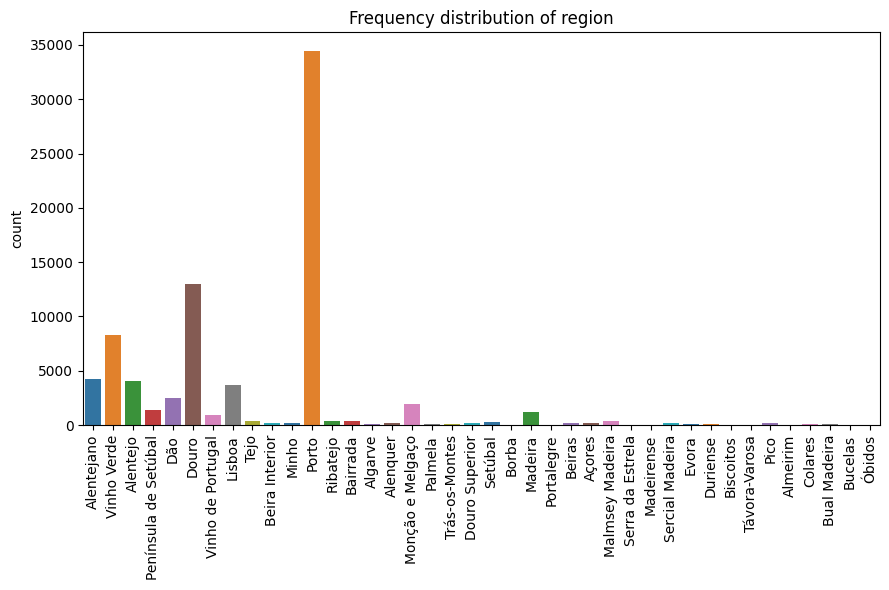

None


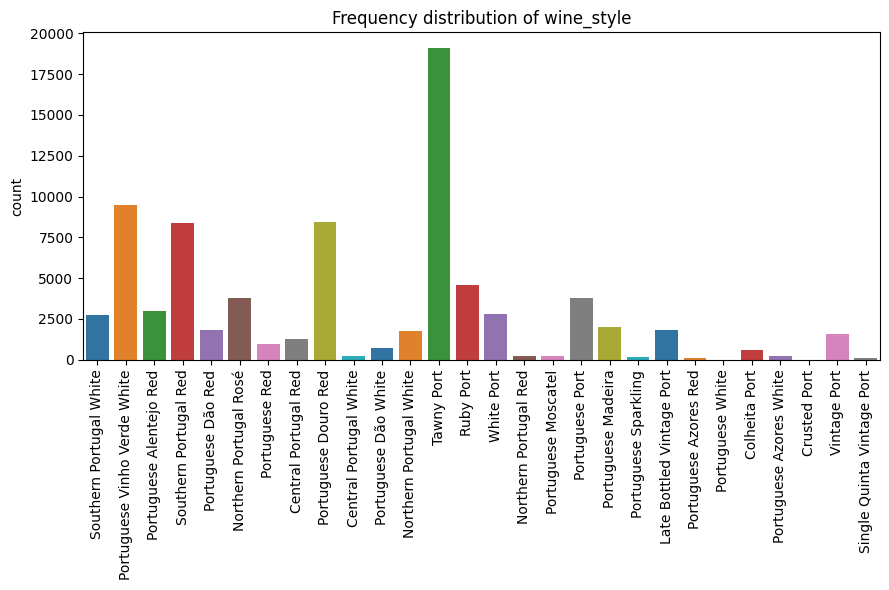

None


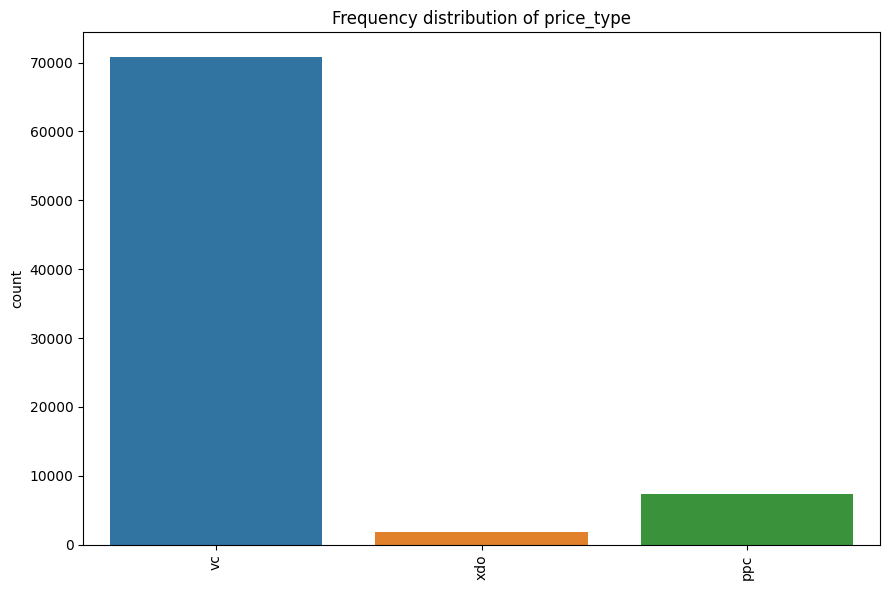

None


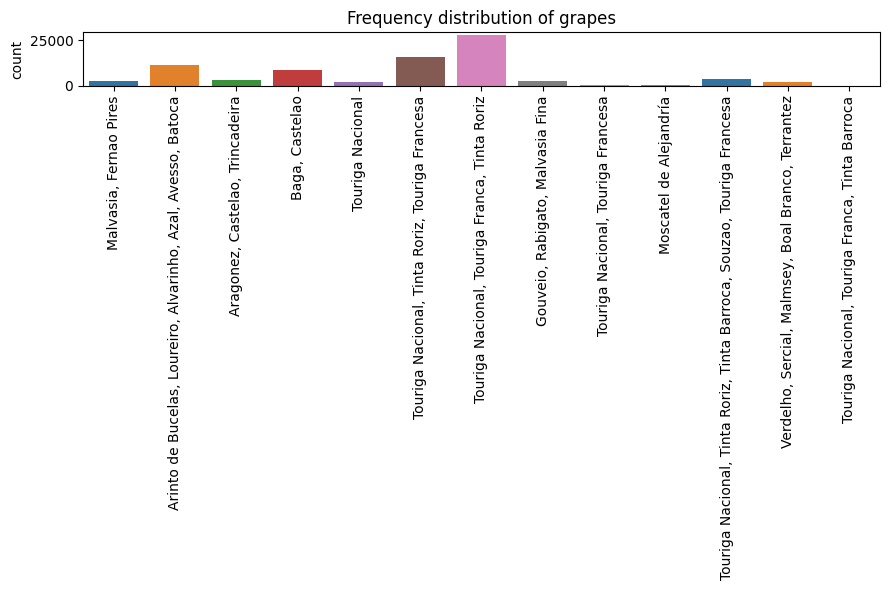

None


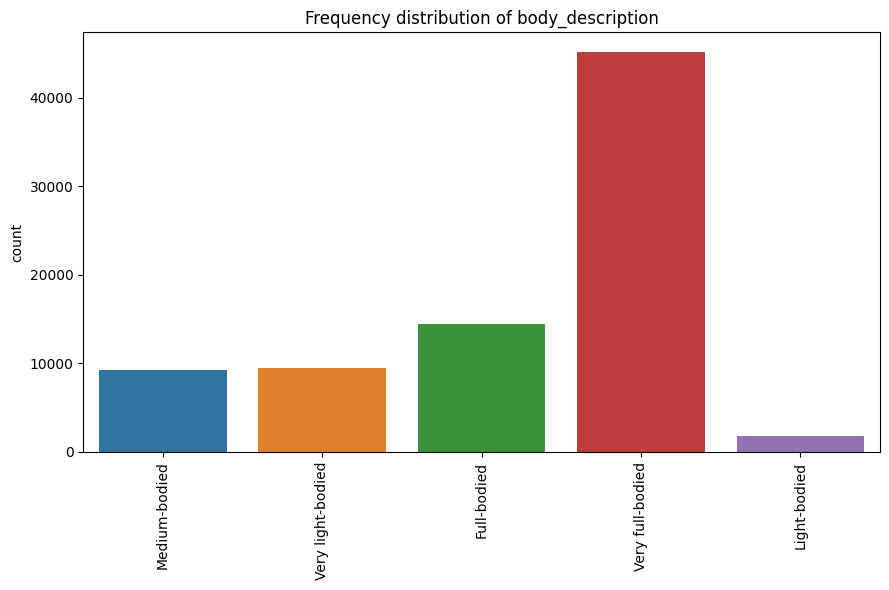

None


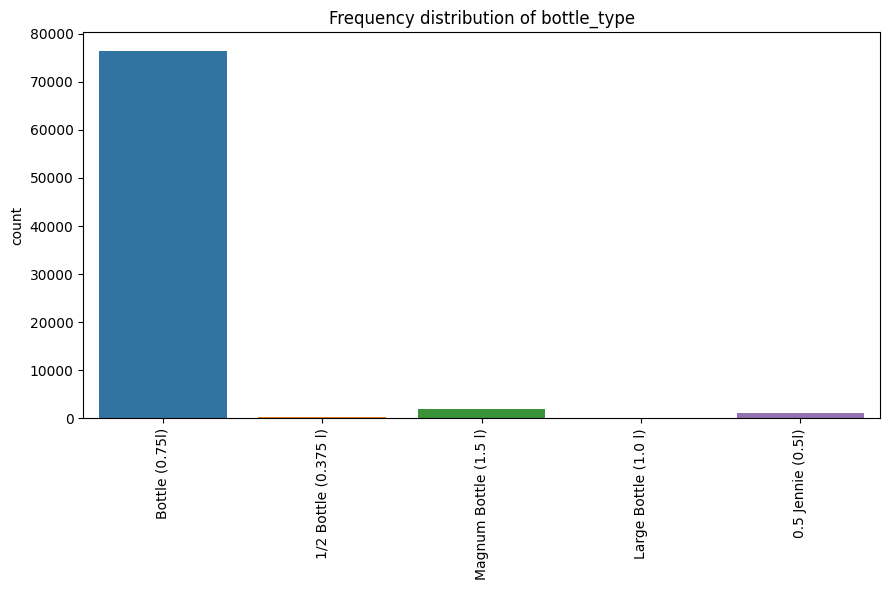

None


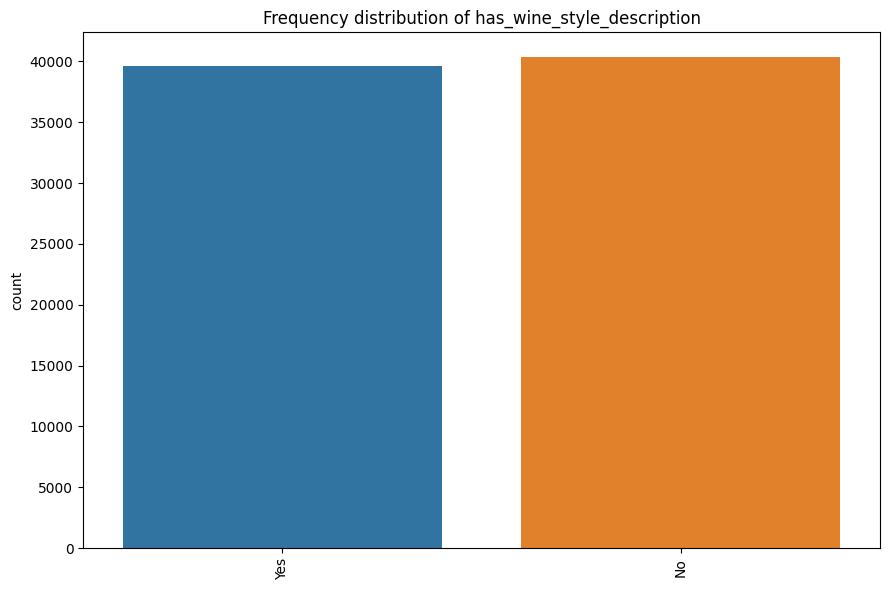

None


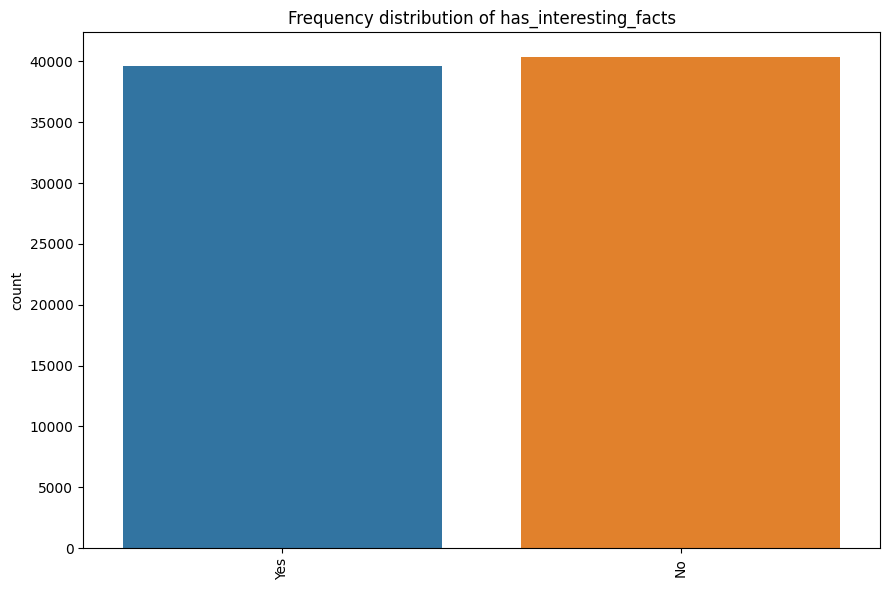

None


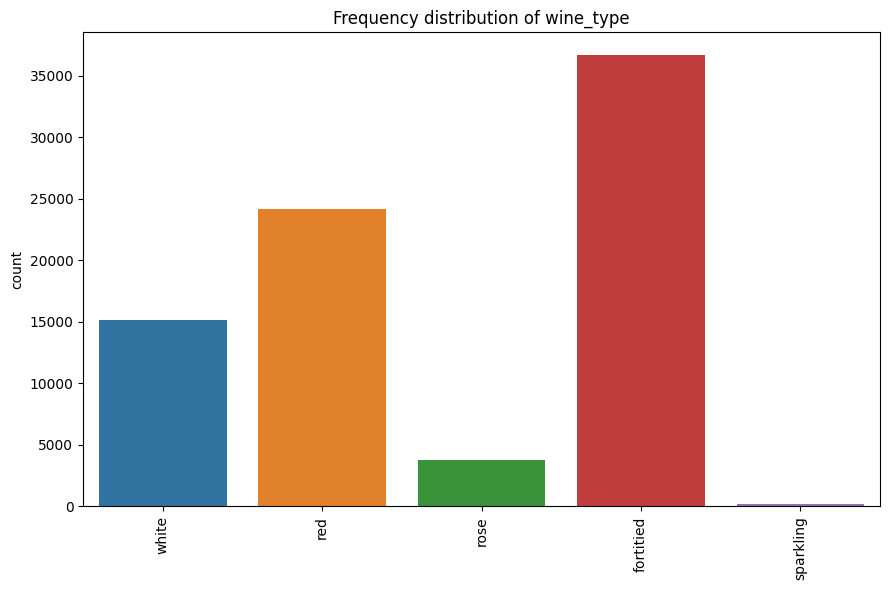

None


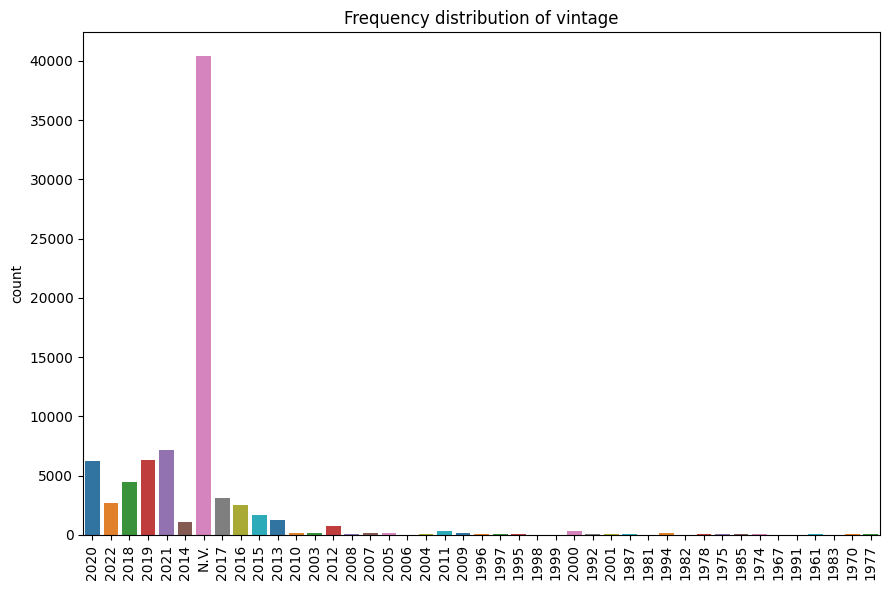

None


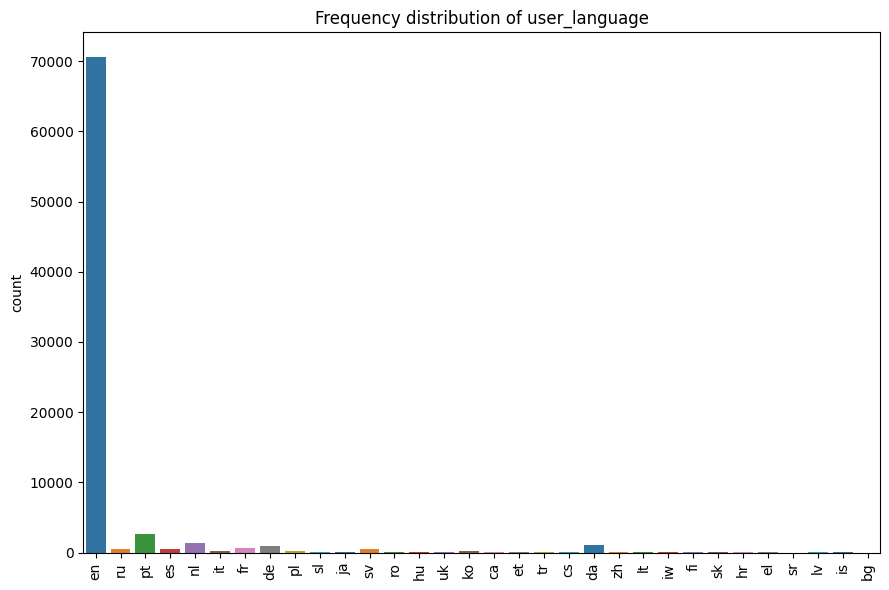

None


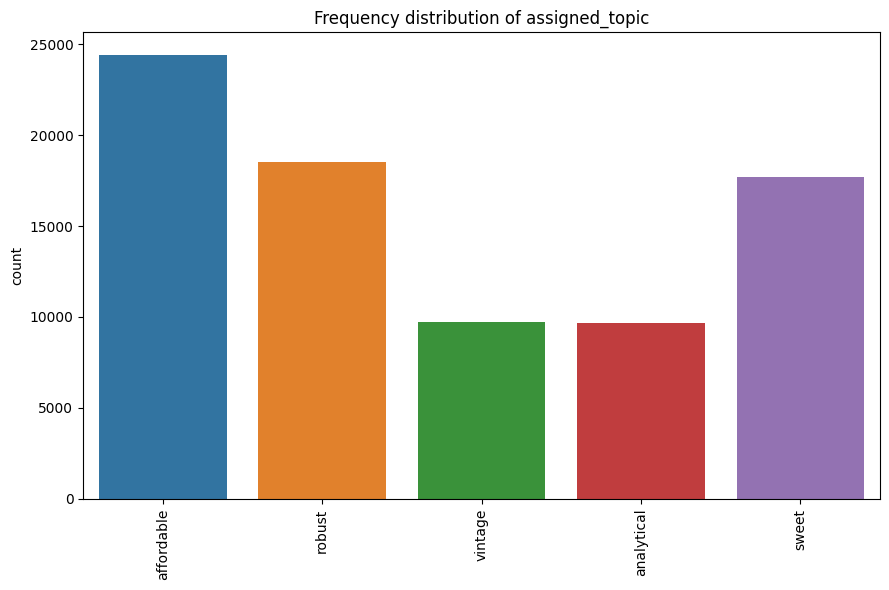

None


In [14]:
for cat in cat_features:
    if cat not in ['wine', 'winery', 'unique_id', 'review', 'date_review', 'time_review', 'wine_style_description', 'interesting_facts']:
        print(frequency_plot(cat, wine_df))

In [20]:
print(f"Time span from {min(wine_df['date_review'])} until {max(wine_df['date_review'])}")

Time span from 2012-04-28 until 2023-10-06


In [16]:
wine_df[['time_review']].head()

time_review
0    20:16:20
1    12:56:12
2    12:18:29
3    14:04:45
4    21:03:41

C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\1745376313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['date_review'] = pd.to_datetime(date_df['date_review'])
C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\1745376313.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['year'] = date_df['date_review'].dt.year


<Figure size 1000x600 with 0 Axes>

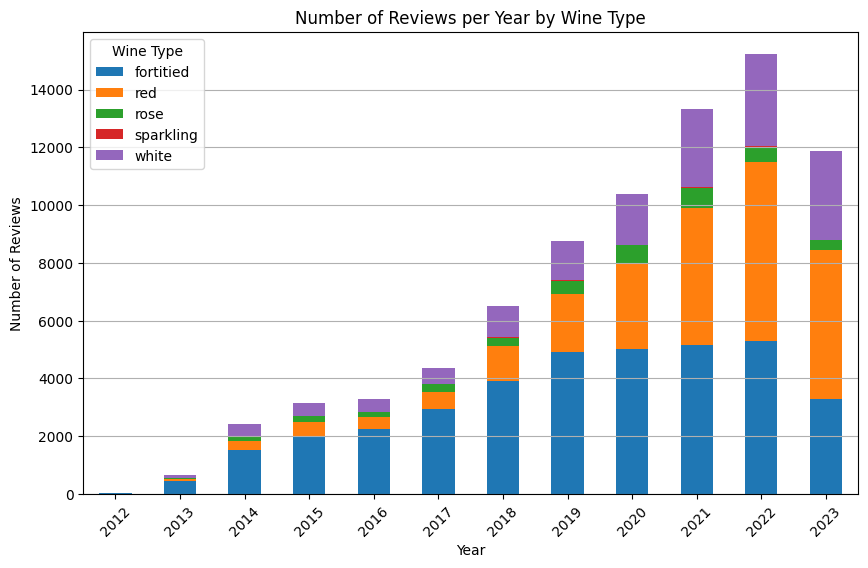

In [21]:
date_df = wine_df[['date_review', 'wine_type']]
# Convert date_review to datetime and extract year
date_df['date_review'] = pd.to_datetime(date_df['date_review'])
date_df['year'] = date_df['date_review'].dt.year

# Group by year and wine_type, and count the number of reviews
yearly_wine_type_counts = date_df.groupby(['year', 'wine_type']).size().reset_index(name='counts')

# Pivot the data to get years as index and wine types as columns filled with the counts
pivot_df = yearly_wine_type_counts.pivot(index='year', columns='wine_type', values='counts').fillna(0)

# Plotting the stacked bar chart
plt.figure(figsize=(10, 6))
pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Number of Reviews per Year by Wine Type')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Wine Type')
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\2944290327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['date_review'] = pd.to_datetime(date_df['date_review'])
C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\2944290327.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_df['year'] = date_df['date_review'].dt.year


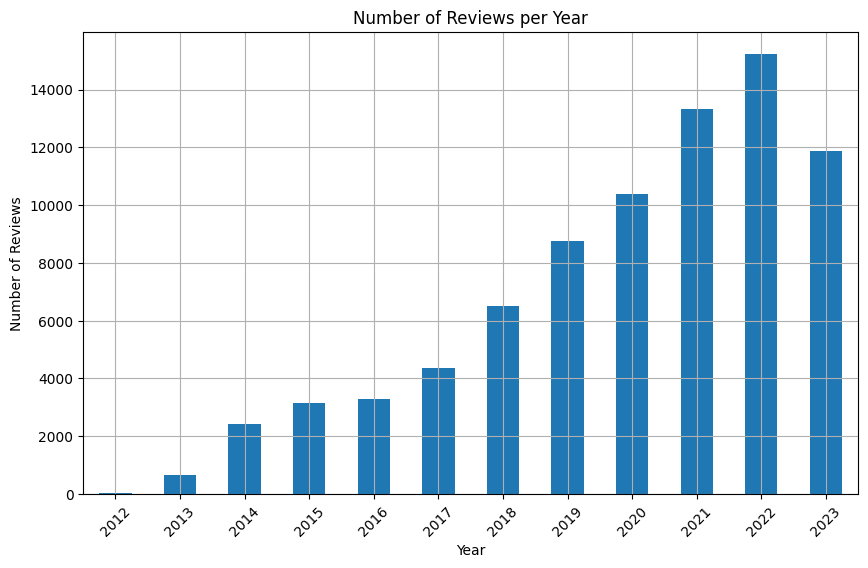

In [22]:
# Convert date_review to datetime
date_df = wine_df[['date_review']]

date_df['date_review'] = pd.to_datetime(date_df['date_review'])

# Extract year from date
date_df['year'] = date_df['date_review'].dt.year

# Group by year and count
yearly_counts = date_df['year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar')  # or use plot(kind='line') for a line plot
plt.title('Number of Reviews per Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\2533325335.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['time_review'] = pd.to_datetime(time_df['time_review'], format='%H:%M:%S').dt.time
C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\2533325335.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_df['hour'] = time_df['time_review'].apply(lambda x: x.hour)


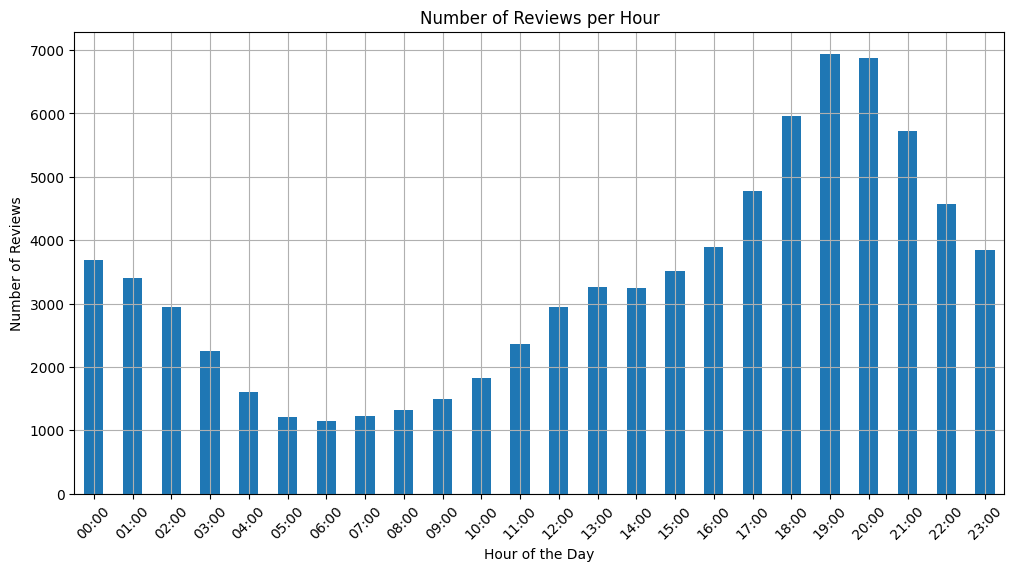

In [23]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your data is in a DataFrame like this:

time_df = wine_df[['time_review']]

# Convert time_review to datetime time object
time_df['time_review'] = pd.to_datetime(time_df['time_review'], format='%H:%M:%S').dt.time

# Extract hour from time
time_df['hour'] = time_df['time_review'].apply(lambda x: x.hour)

# Group by hour and count
hourly_counts = time_df['hour'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar')  # or use plot(kind='line') for a line plot
plt.title('Number of Reviews per Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Reviews')
plt.xticks(range(24), [f"{h:02d}:00" for h in range(24)], rotation=45)  # Adjust x-axis labels
plt.grid(True)
plt.show()


C:\Users\lukas\AppData\Local\Temp\ipykernel_22456\2073473402.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_datetime(df['time_review'], format='%H:%M:%S').dt.hour


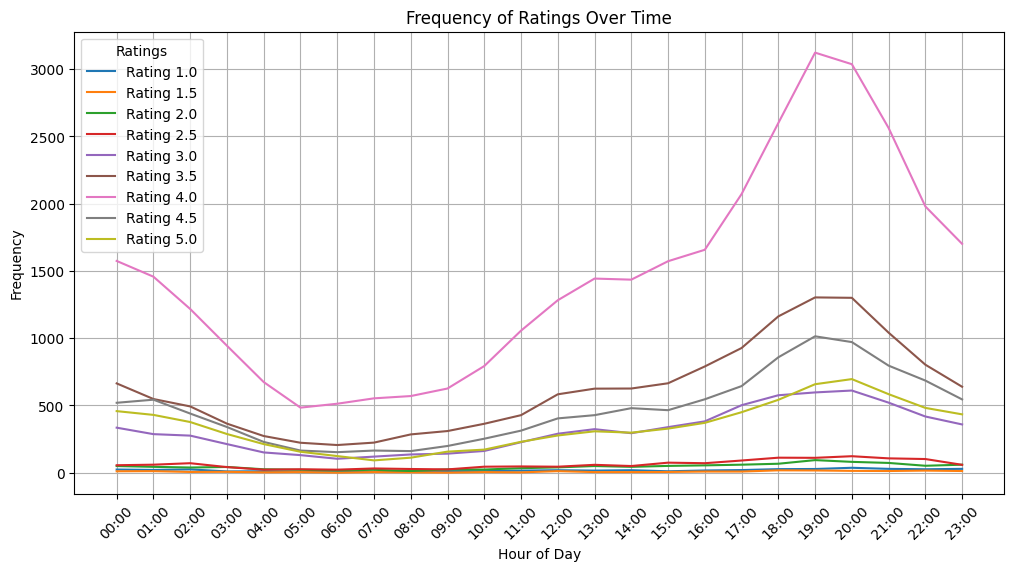

In [24]:
df = wine_df[['time_review', 'rating_label']]

# Convert time_review to datetime time object and extract hours
df['hour'] = pd.to_datetime(df['time_review'], format='%H:%M:%S').dt.hour

# Group by hour and rating, then count the occurrences
grouped = df.groupby(['hour', 'rating_label']).size().reset_index(name='count')

# Pivot the data to have hours as index and ratings as columns
pivot_df = grouped.pivot(index='hour', columns='rating_label', values='count').fillna(0)

# Plotting
plt.figure(figsize=(12, 6))

for column in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[column], label=f'Rating {column}')

plt.title('Frequency of Ratings Over Time')
plt.xlabel('Hour of Day')
plt.ylabel('Frequency')
plt.xticks(range(24), [f"{h:02d}:00" for h in range(24)], rotation=45)
plt.legend(title='Ratings')
plt.grid(True)
plt.show()

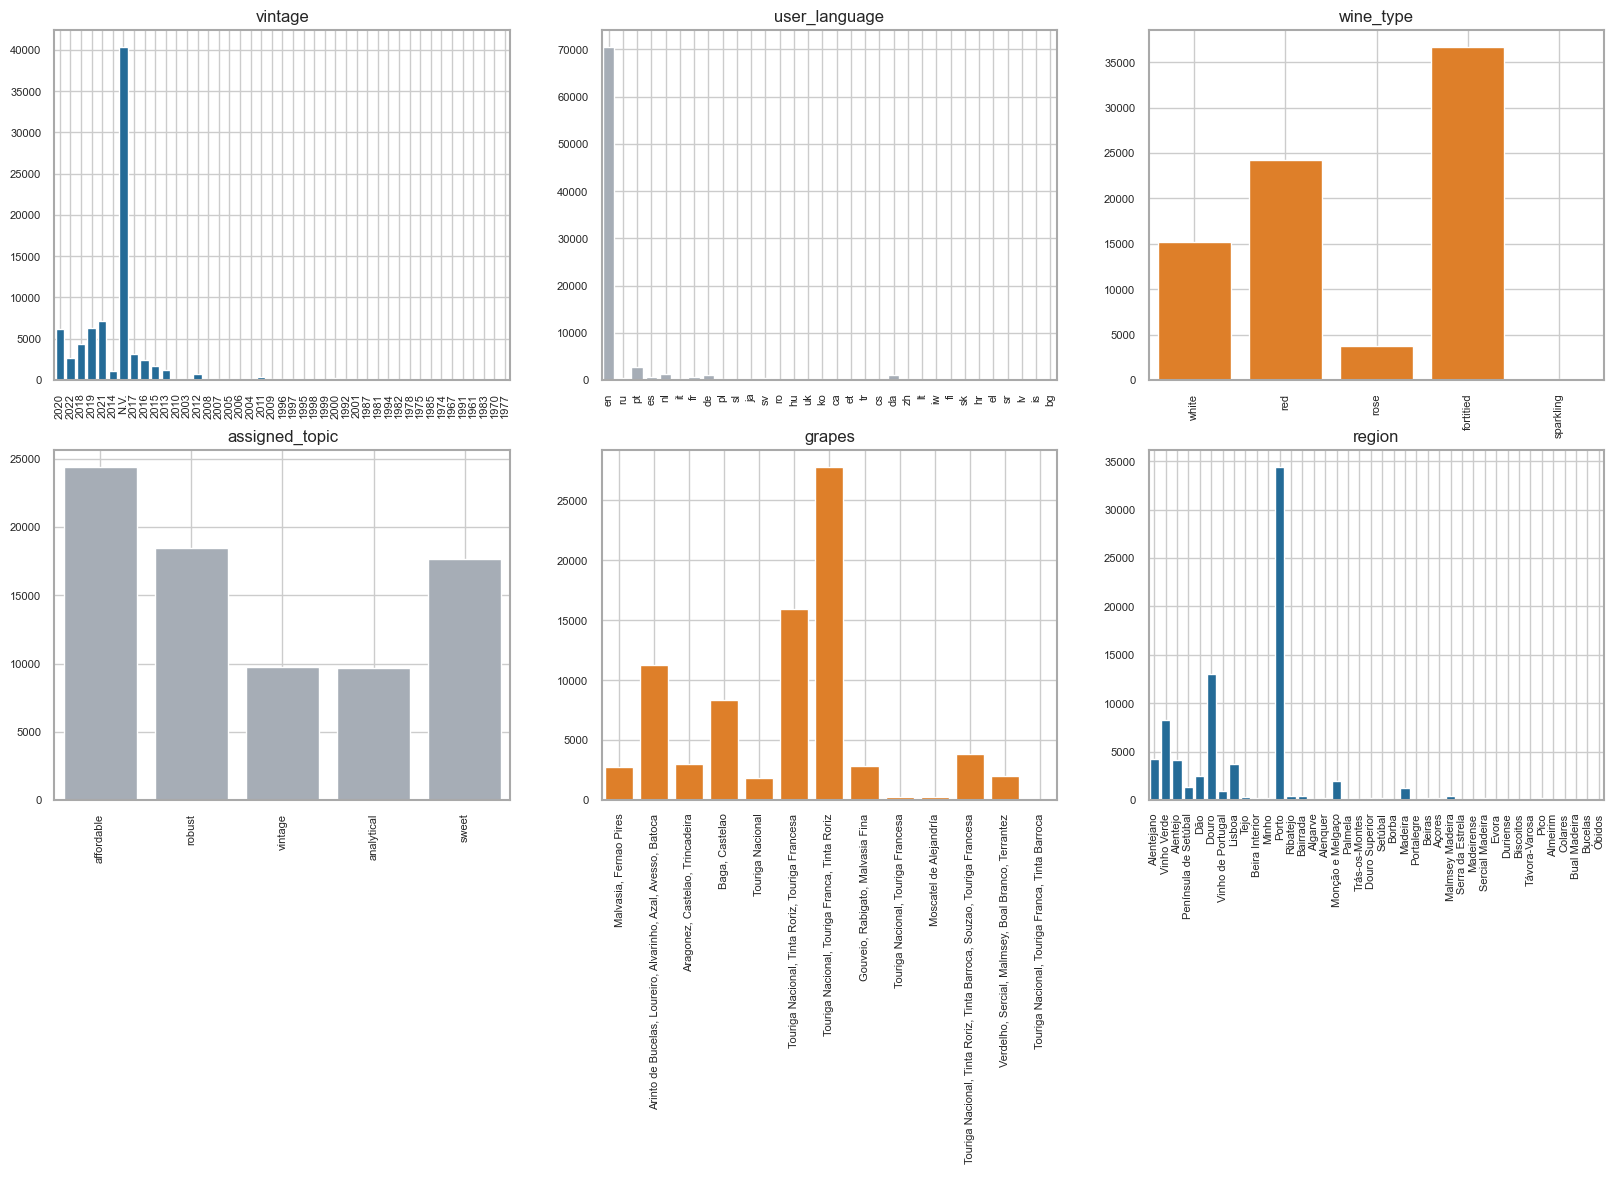

In [25]:
categorical_columns = ['vintage', 'user_language', 'wine_type','assigned_topic', 'grapes', 'region'] 

df = wine_df[categorical_columns]
sns.set(style="whitegrid")
palette = [extrinsic, personal , intrinsic, personal, intrinsic, extrinsic]
n_rows = 2
n_cols = 3

plt.figure(figsize=(20, 10)) 

# Enhanced style settings
plt.rcParams['font.family'] = 'Times New Roman'
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 150 

for i, category in enumerate(df.columns):
    ax = plt.subplot(n_rows, n_cols, i + 1)
    sns.countplot(x=df[category], palette=[palette[i]], ax=ax)
    ax.set_title(f'{category}', fontsize=12)
    ax.set_ylabel('', fontsize=8)
    ax.set_xlabel(' ', fontsize=10)  # Set x-axis label
    ax.tick_params(axis='x', rotation=90, labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(True)  # Stylish grid lines

    # Customize axis style here
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1.5)
        spine.set_color('darkgrey')

In [26]:
wine_df['assigned_topic']

0        affordable
1            robust
2        affordable
3           vintage
4        affordable
            ...    
80016       vintage
80017    analytical
80018    affordable
80019         sweet
80020    affordable
Name: assigned_topic, Length: 80021, dtype: object

In [29]:
wine_df['region'].value_counts()

region
Porto                   34430
Douro                   12998
Vinho Verde              8277
Alentejano               4208
Alentejo                 4109
Lisboa                   3725
Dão                      2479
Monção e Melgaço         1942
Península de Setúbal     1392
Madeira                  1215
Vinho de Portugal         933
Malmsey Madeira           426
Ribatejo                  426
Bairrada                  369
Tejo                      356
Setúbal                   258
Sercial Madeira           240
Douro Superior            206
Beiras                    201
Alenquer                  190
Minho                     175
Beira Interior            171
Açores                    162
Pico                      157
Bual Madeira              148
Algarve                   139
Duriense                  120
Palmela                   108
Colares                    86
Trás-os-Montes             74
Evora                      61
Biscoitos                  50
Borba                      41
Ser

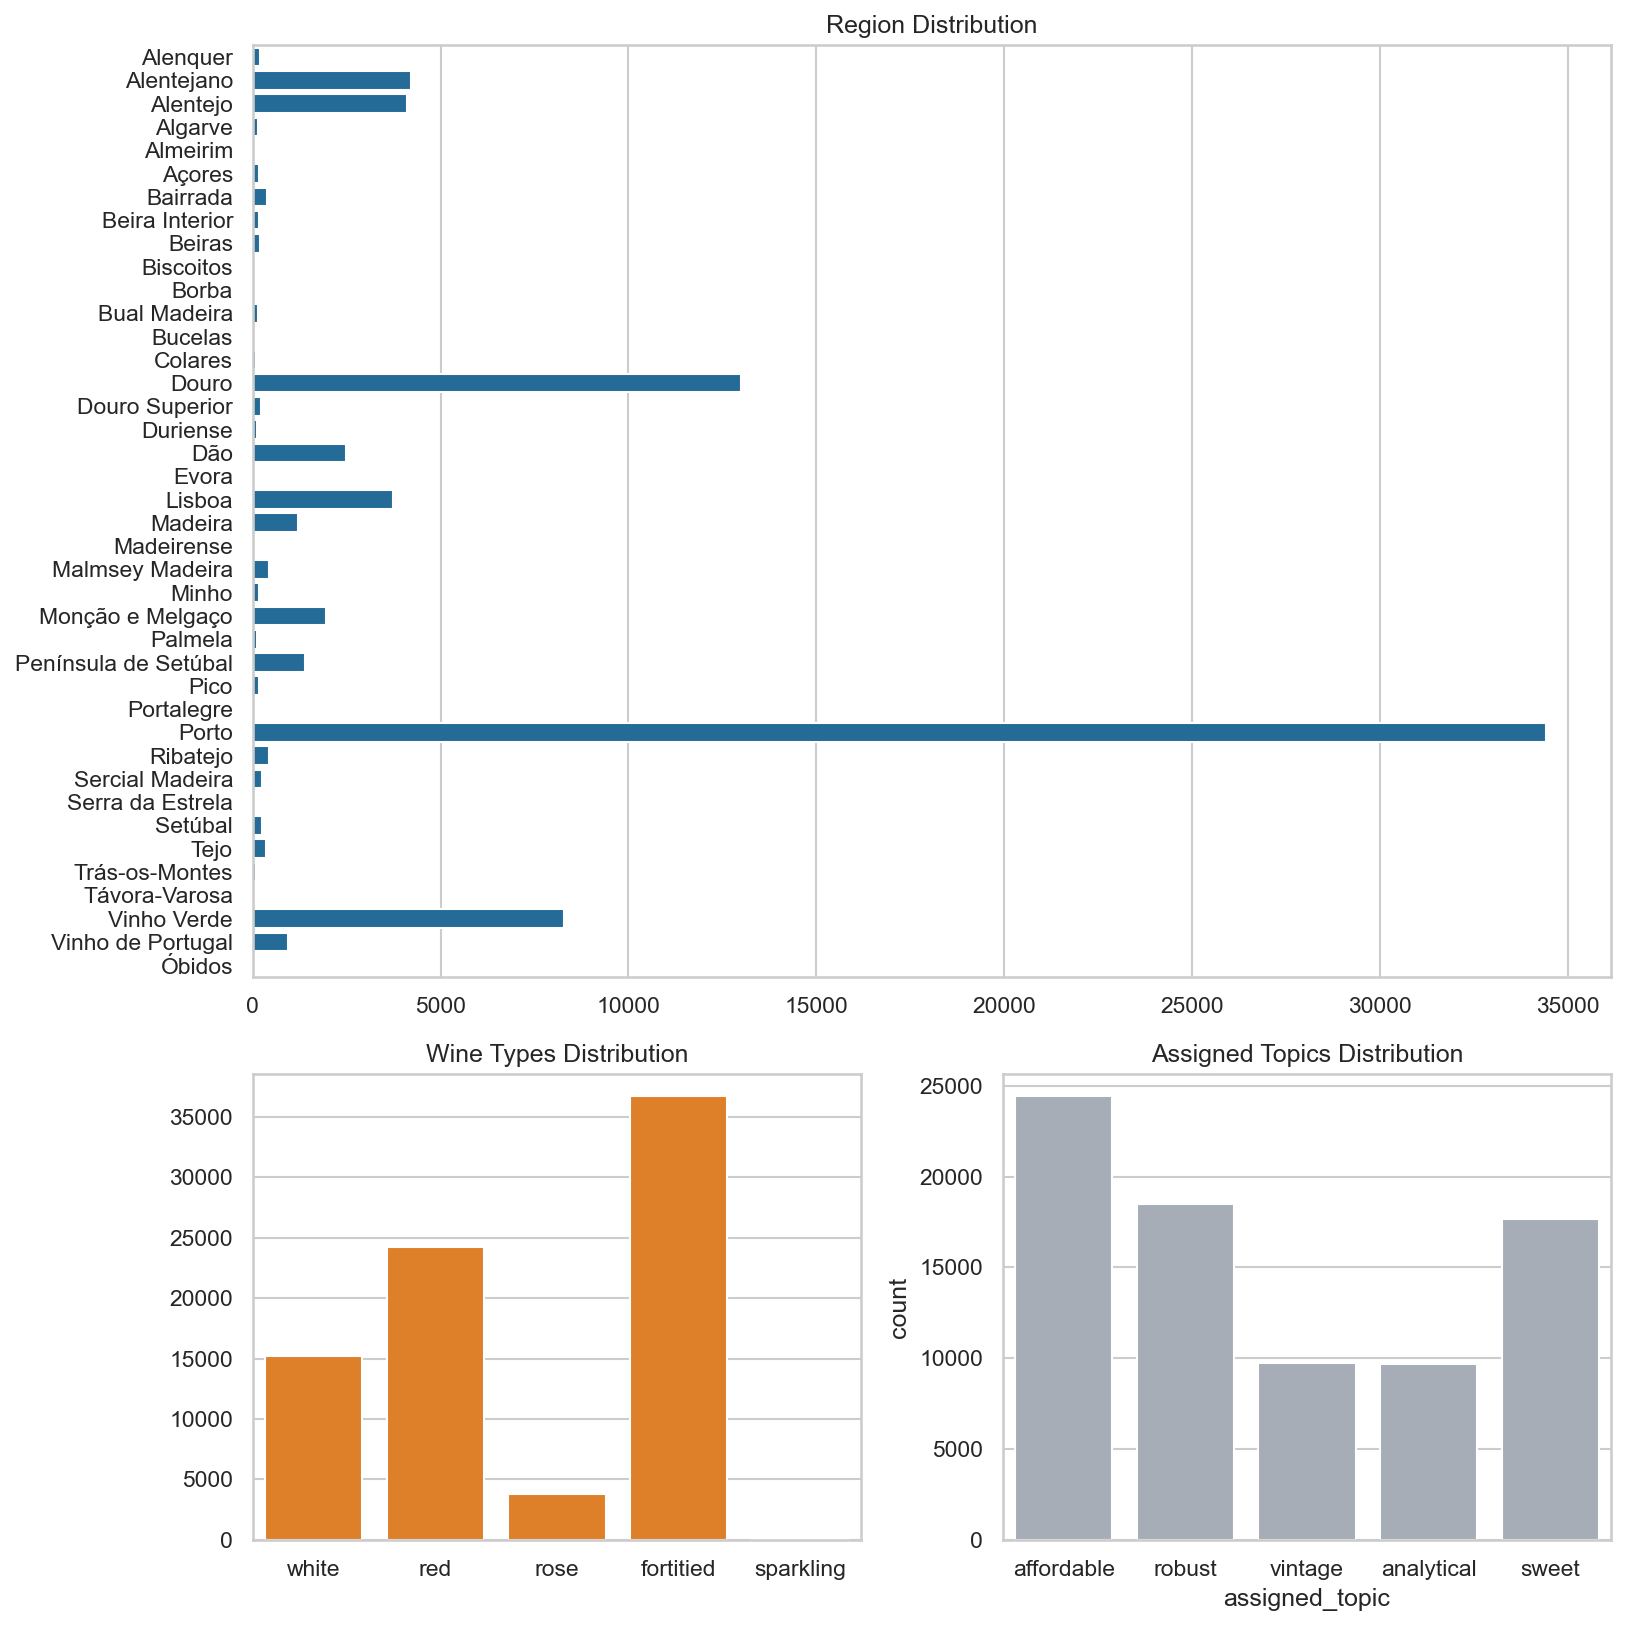

In [30]:
from matplotlib.gridspec import GridSpec
# Creating a new figure layout with one main plot and three subplots
fig = plt.figure(figsize=(11,11))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[1, 1], figure=fig)

plt.rcParams['font.family'] = 'Times New Roman'
sns.set(style="whitegrid")
plt.rcParams['figure.dpi'] = 150 

# Main plot
main_ax = fig.add_subplot(gs[0, :])
sns.countplot(y='region', data=wine_df.sort_values(by='region'), ax=main_ax, color=extrinsic)
main_ax.set_title('Region Distribution')
main_ax.set_xlabel('')
main_ax.set_ylabel('')


# Subplot 1
sub_ax1 = fig.add_subplot(gs[1, 0])
sns.countplot(x='wine_type', data=wine_df, ax=sub_ax1, color=intrinsic)
sub_ax1.set_title('Wine Types Distribution')
sub_ax1.set_xlabel('')
sub_ax1.set_ylabel('')


# Subplot 2
sub_ax2 = fig.add_subplot(gs[1, 1])
sns.countplot(x='assigned_topic', data=wine_df, ax=sub_ax2, color=personal)
sub_ax2.set_title('Assigned Topics Distribution')

plt.tight_layout()
plt.show()

#### numerical

In [31]:
desc_stats = wine_df.describe()

# Adding median, IQR and count distinct
desc_stats.loc['median'] = wine_df.median(numeric_only=True)
desc_stats.loc['IQR'] = desc_stats.loc['75%'] - desc_stats.loc['25%']
desc_stats.loc['distinct'] = wine_df.nunique()

# Transposing the dataframe for better readability
desc_stats = desc_stats.transpose()

# Now creating a new dataframe with only the required statistics and rounding to 2 decimal places
final_stats = desc_stats[['distinct', 'mean', 'std', 'min', '25%', '50%', '75%', 'max', 'IQR']].round(1).reset_index()
final_stats.rename(columns={'index': 'feature'}, inplace=True)

final_stats.set_index('feature')

distinct         mean         std      min  \
feature                                                                   
ratings_average                  18.0          3.9         0.6      0.0   
ratings_number                  673.0      10229.4     22301.4      0.0   
all_vintage_ratings_average      17.0          3.9         0.2      3.1   
all_vintage_ratings_count      1125.0      17184.8     24007.8     25.0   
price                          1035.0         27.1        39.5      3.5   
acidity                        1405.0          3.2         0.4      2.1   
sweetness                      1399.0          3.1         1.4      0.0   
intensity                      1404.0          3.8         0.9      1.5   
tannin                          690.0          1.0         1.5      0.0   
fizziness                        10.0          0.0         0.2      0.0   
alcohol                          59.0         16.3         3.5      9.0   
amount_food_words                 5.0          3.5         0.8      2.0   
amount_flavor_words              13.0         12.2         1.5      1.0   
amount_grapes                     5.0          3.4         1.3      1.0   
review_id                     80021.0  176193972.2  81476860.4  35689.0   
user_id                       47620.0   22182284.2  17725389.2    140.0   
rating                           41.0          3.9         0.7      1.0   
likes_on_review                 346.0          7.2        26.3      0.0   
comments_on_review              116.0          0.9         5.3      0.0   
user_follower                  1514.0        357.2      2051.4      0.0   
user_following                 1152.0        131.0       488.3      0.0   
user_total_given_ratings       3032.0        865.0      1624.0      0.0   
user_total_sum_ratings        19224.0       3224.9      6069.3      0.0   
user_total_given_reviews       2681.0        748.0      1535.7      0.0   
user_purchase_made              139.0          2.5        12.1      0.0   
rating_label                      9.0          3.9         0.7      1.0   

                                     25%          50%          75%  \
feature                                                              
ratings_average                      3.8          3.9          4.1   
ratings_number                     460.0       1811.0       6458.0   
all_vintage_ratings_average          3.8          3.9          4.1   
all_vintage_ratings_count         2295.0       6458.0      18385.0   
price                                9.2         15.0         27.0   
acidity                              3.0          3.0          3.3   
sweetness                            1.8          2.2          4.4   
intensity                            3.5          4.2          4.4   
tannin                               0.0          0.0          2.8   
fizziness                            0.0          0.0          0.0   
alcohol                             13.0         14.5         20.0   
amount_food_words                    3.0          3.0          4.0   
amount_flavor_words                 12.0         13.0         13.0   
amount_grapes                        3.0          3.0          3.0   
review_id                    112691573.0  191093752.0  247849288.0   
user_id                        5958163.0   19367806.0   35554227.0   
rating                               3.5          4.0          4.2   
likes_on_review                      0.0          1.0          2.0   
comments_on_review                   0.0          0.0          0.0   
user_follower                        1.0          7.0         59.0   
user_following                       1.0          7.0         50.0   
user_total_given_ratings            41.0        231.0        938.0   
user_total_sum_ratings             159.5        870.8       3473.6   
user_total_given_reviews            24.0        157.0        739.0   
user_purchase_made                   0.0          0.0          0.0   
rating_label                         3

In [32]:
final_stats.set_index('feature').to_csv()

'feature,distinct,mean,std,min,25%,50%,75%,max,IQR\r\nratings_average,18.0,3.9,0.6,0.0,3.8,3.9,4.1,4.8,0.3\r\nratings_number,673.0,10229.4,22301.4,0.0,460.0,1811.0,6458.0,87919.0,5998.0\r\nall_vintage_ratings_average,17.0,3.9,0.2,3.1,3.8,3.9,4.1,4.7,0.3\r\nall_vintage_ratings_count,1125.0,17184.8,24007.8,25.0,2295.0,6458.0,18385.0,87919.0,16090.0\r\nprice,1035.0,27.1,39.5,3.5,9.2,15.0,27.0,470.0,17.8\r\nacidity,1405.0,3.2,0.4,2.1,3.0,3.0,3.3,4.6,0.3\r\nsweetness,1399.0,3.1,1.4,0.0,1.8,2.2,4.4,5.0,2.7\r\nintensity,1404.0,3.8,0.9,1.5,3.5,4.2,4.4,5.0,0.8\r\ntannin,690.0,1.0,1.5,0.0,0.0,0.0,2.8,4.1,2.8\r\nfizziness,10.0,0.0,0.2,0.0,0.0,0.0,0.0,4.0,0.0\r\nalcohol,59.0,16.3,3.5,9.0,13.0,14.5,20.0,21.5,7.0\r\namount_food_words,5.0,3.5,0.8,2.0,3.0,3.0,4.0,6.0,1.0\r\namount_flavor_words,13.0,12.2,1.5,1.0,12.0,13.0,13.0,13.0,1.0\r\namount_grapes,5.0,3.4,1.3,1.0,3.0,3.0,3.0,6.0,0.0\r\nreview_id,80021.0,176193972.2,81476860.4,35689.0,112691573.0,191093752.0,247849288.0,289250957.0,135157715.0\r\nu

In [35]:
final_stats.set_index('feature').to_csv('numeric.csv', index=True)

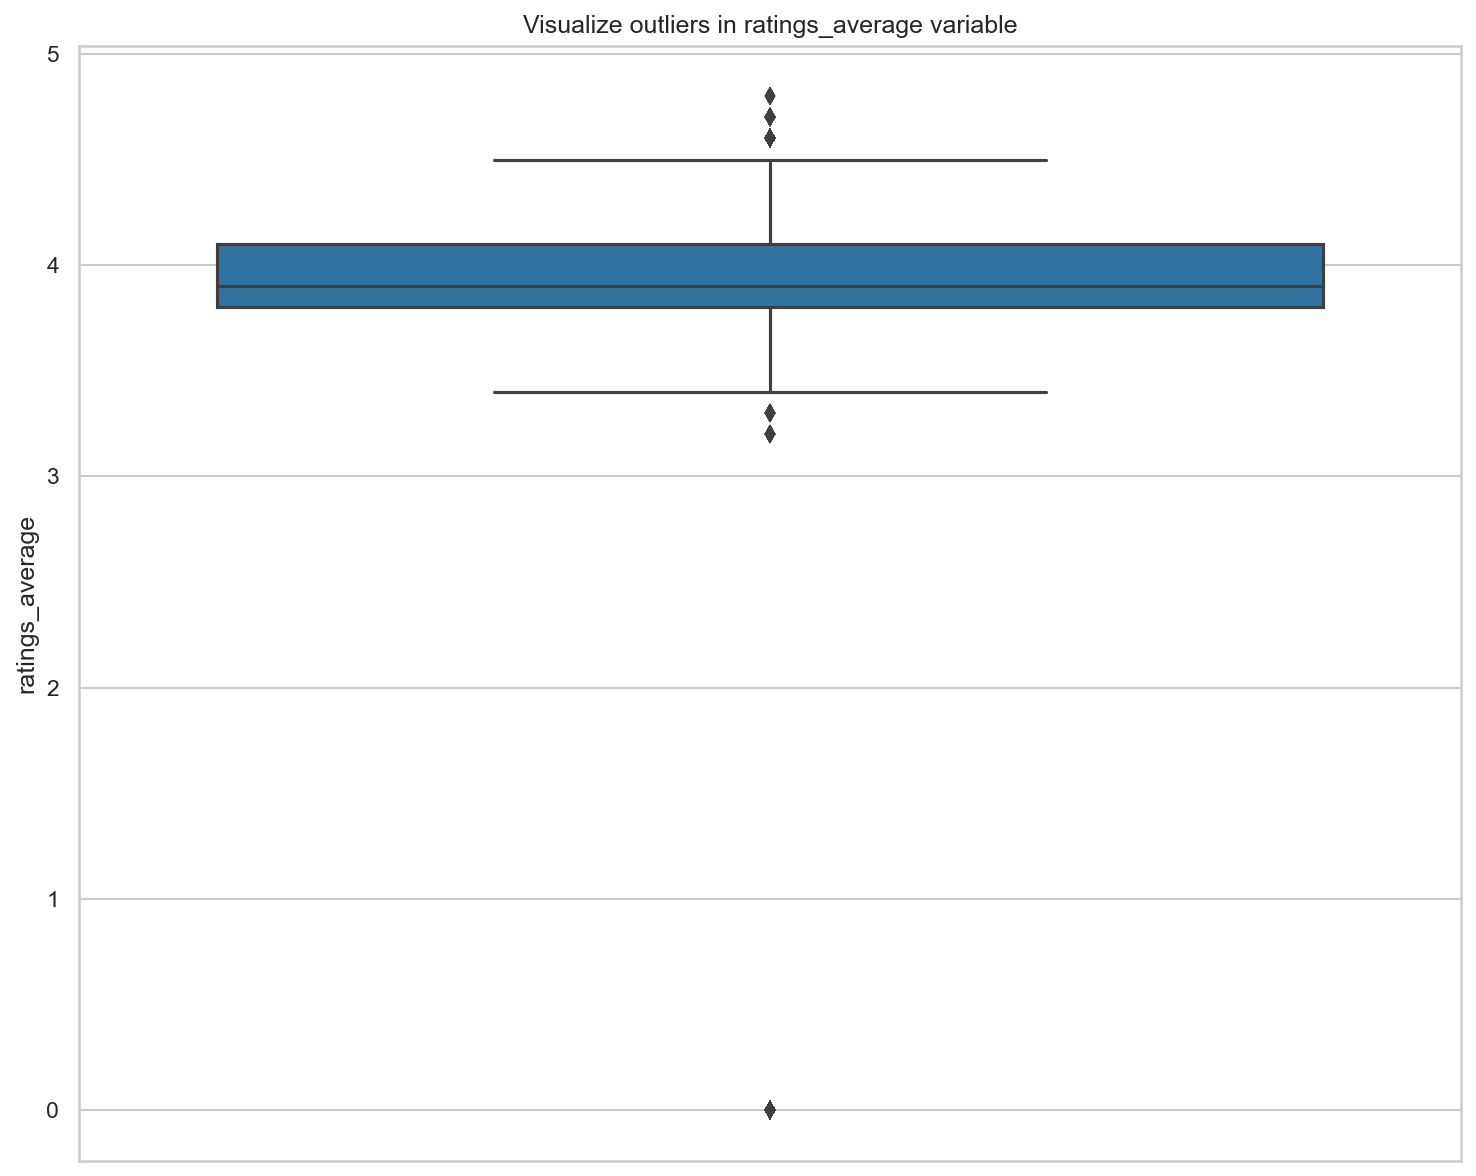

None


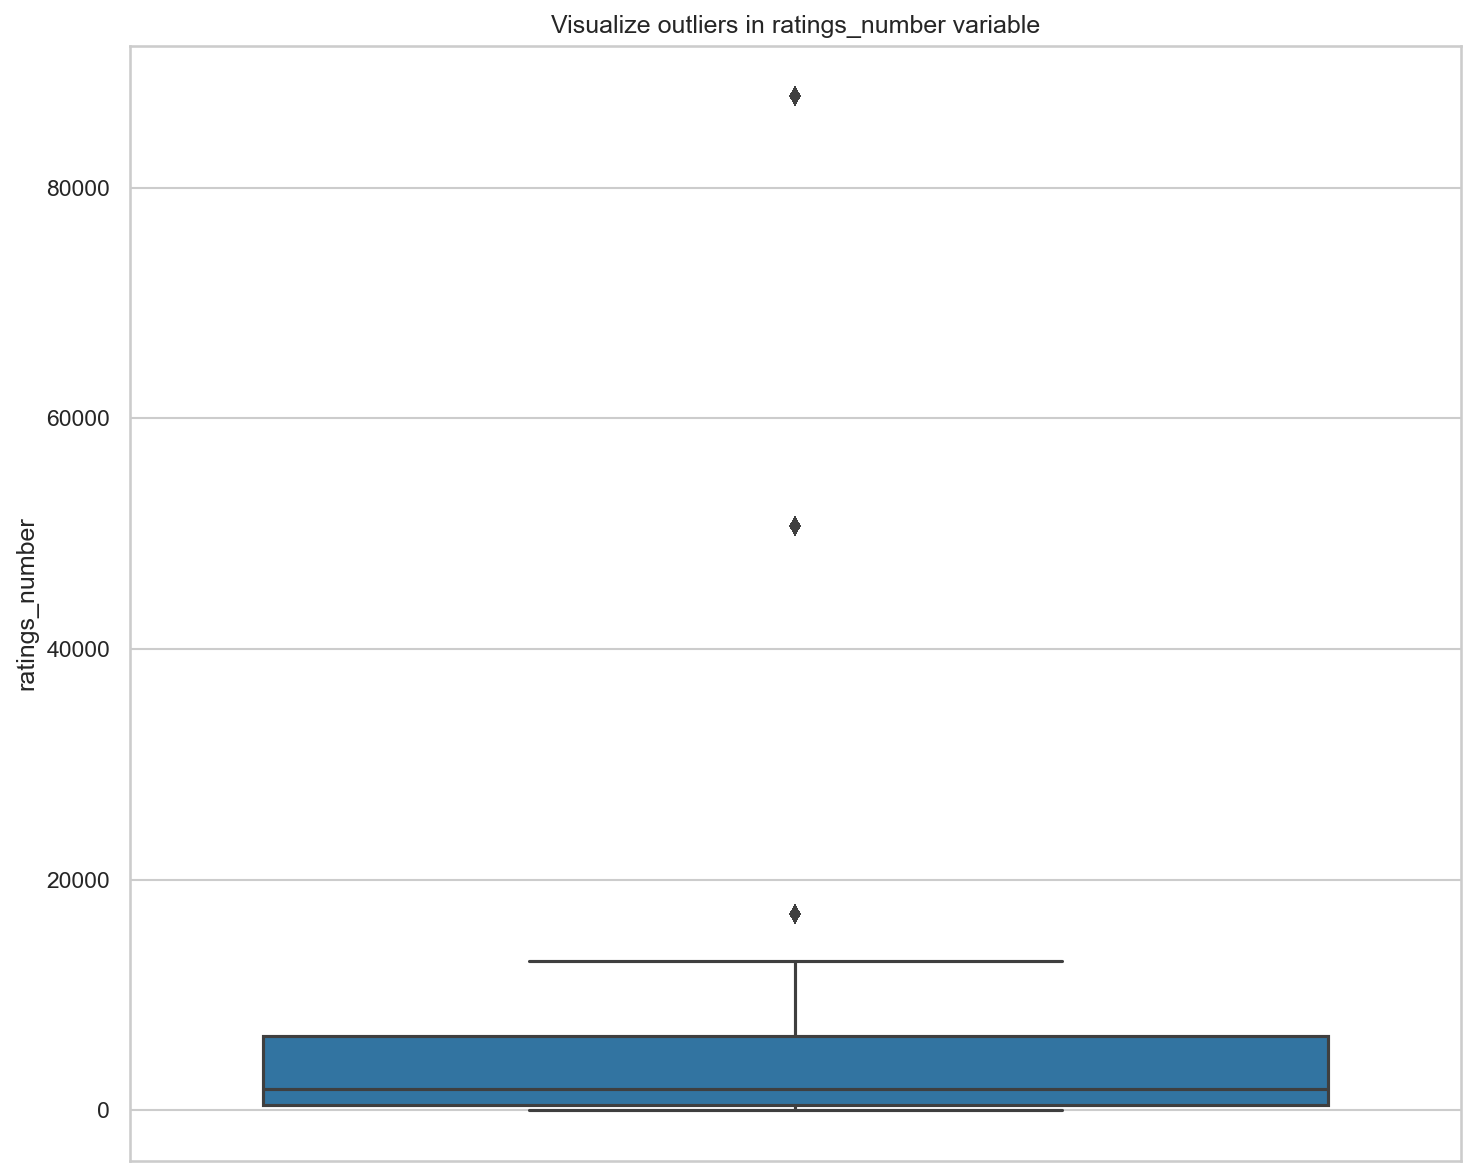

None


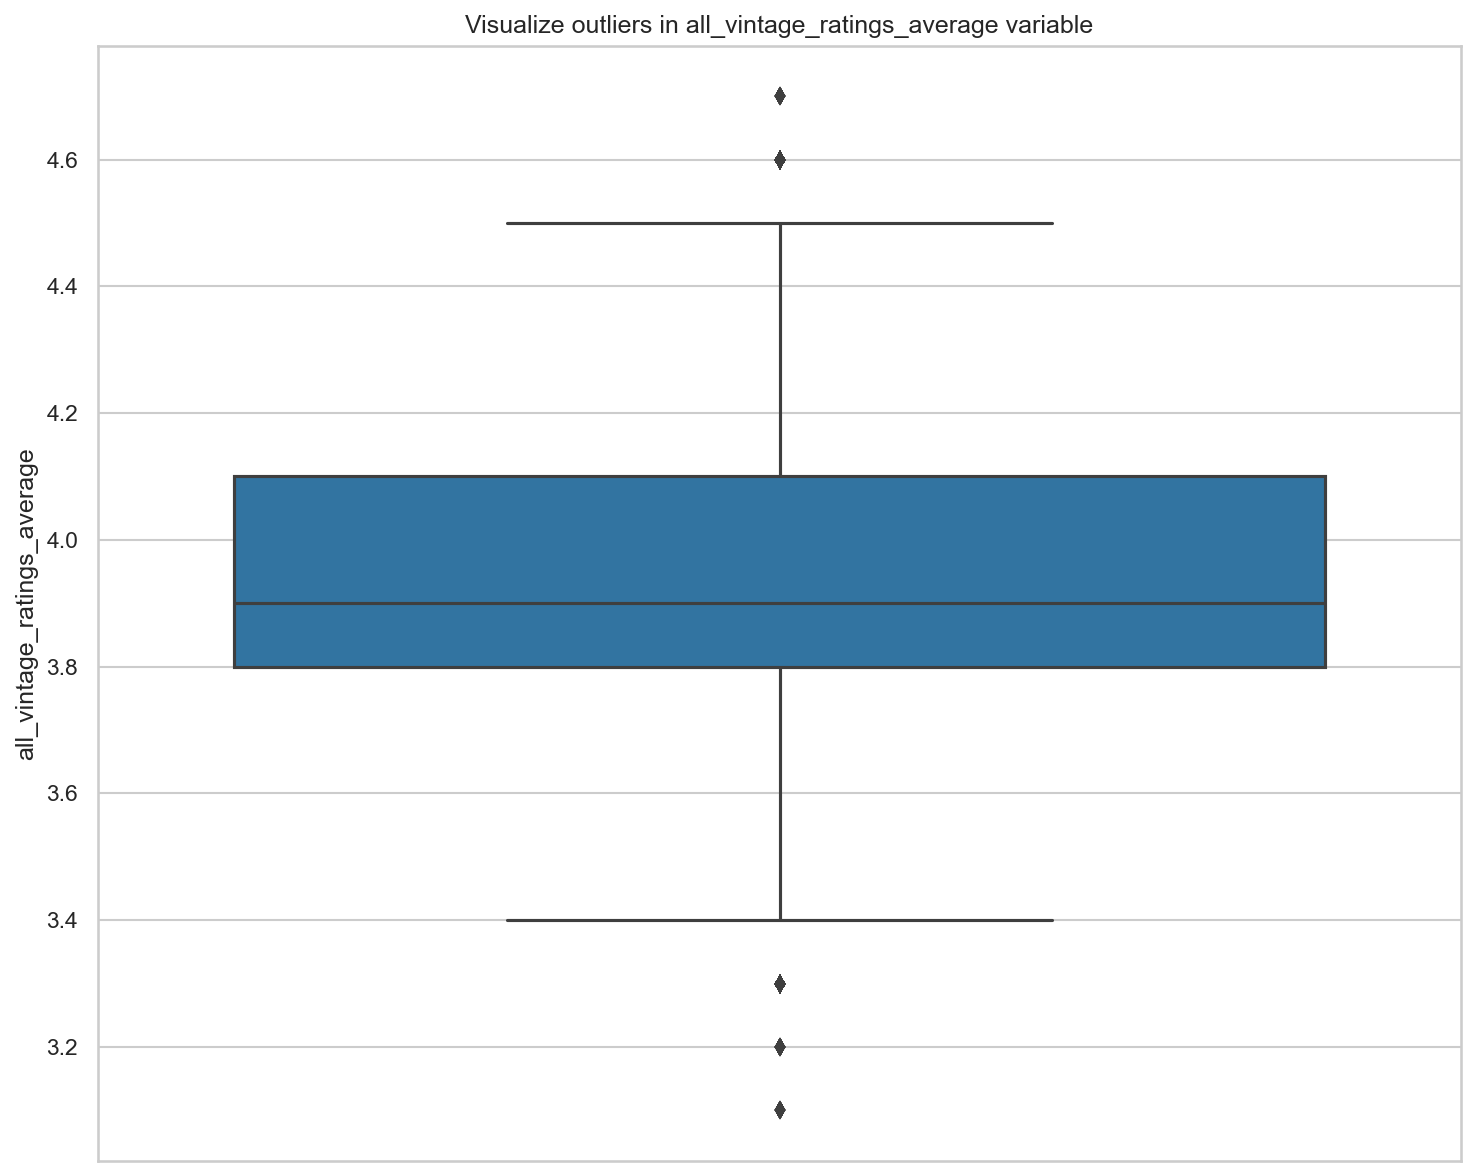

None


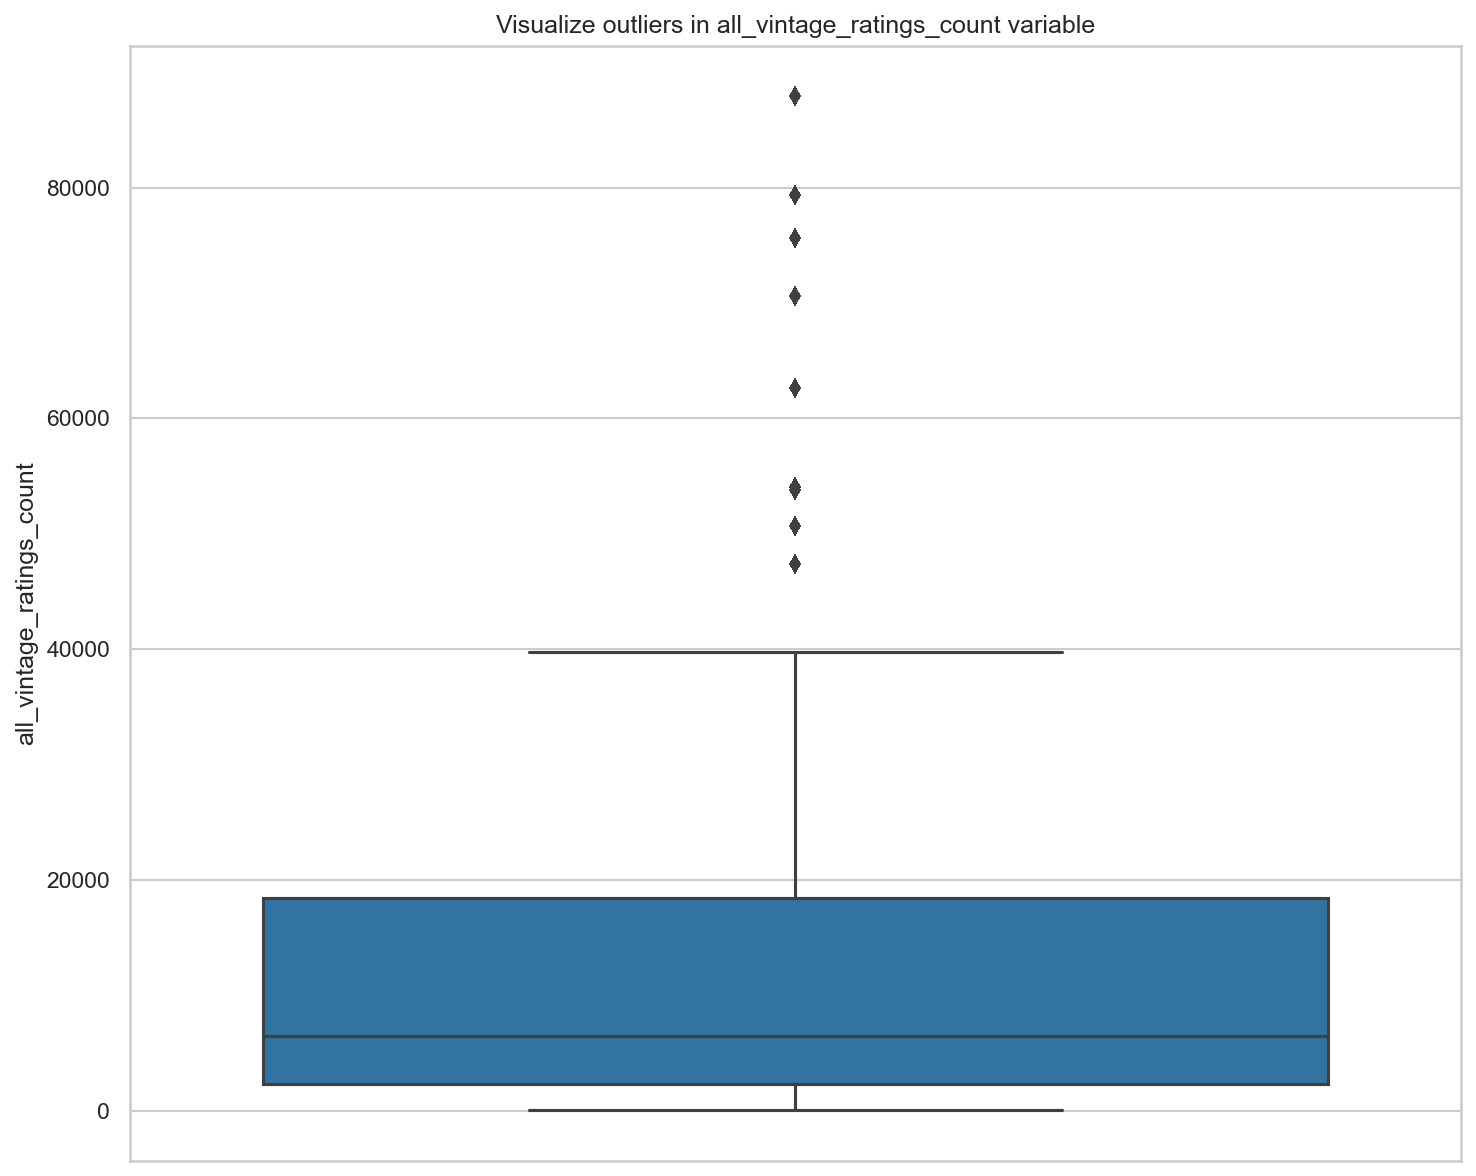

None


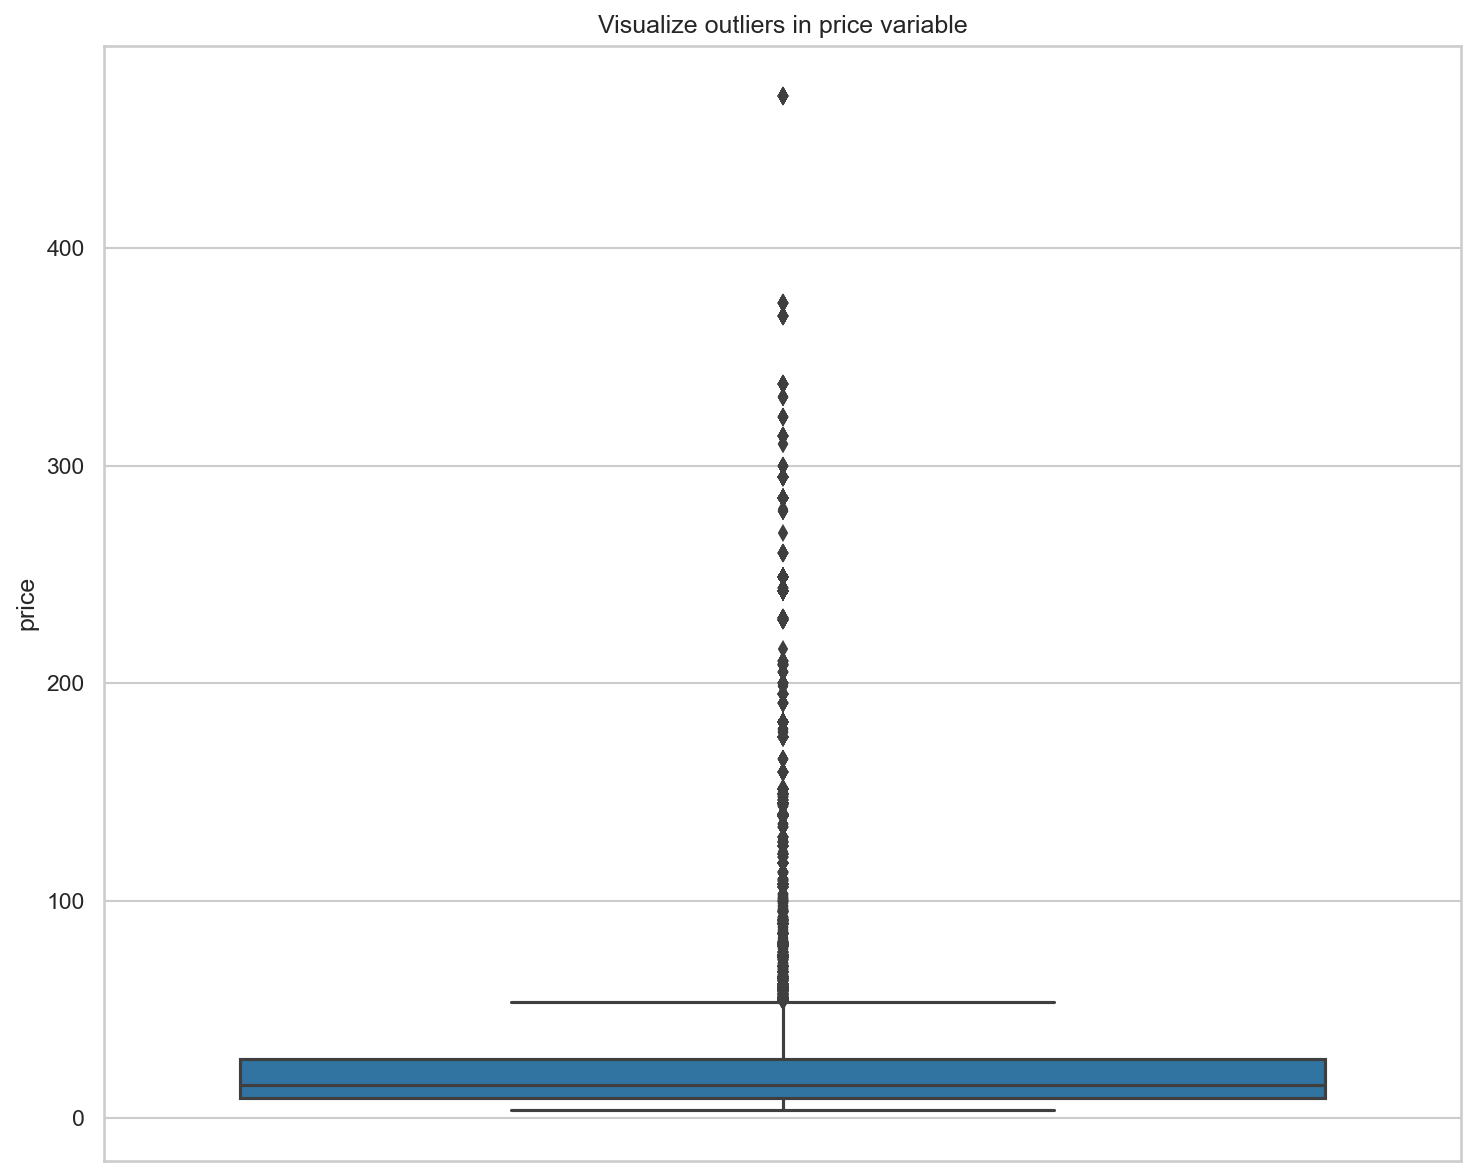

None


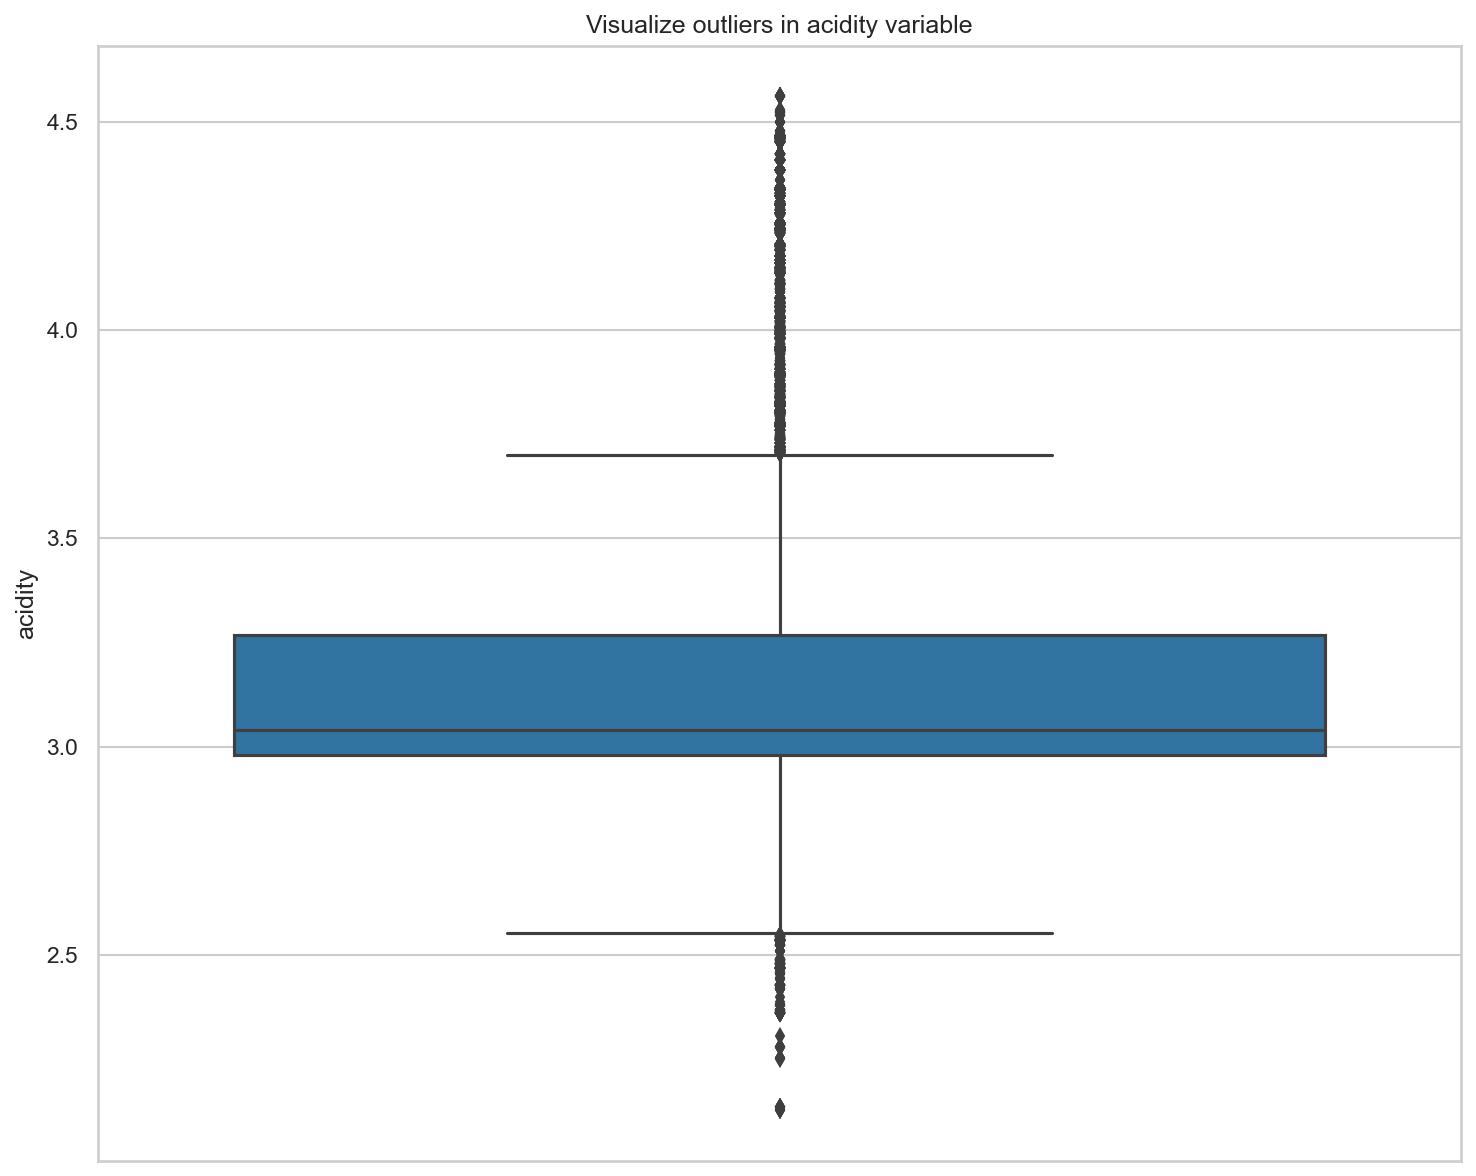

None


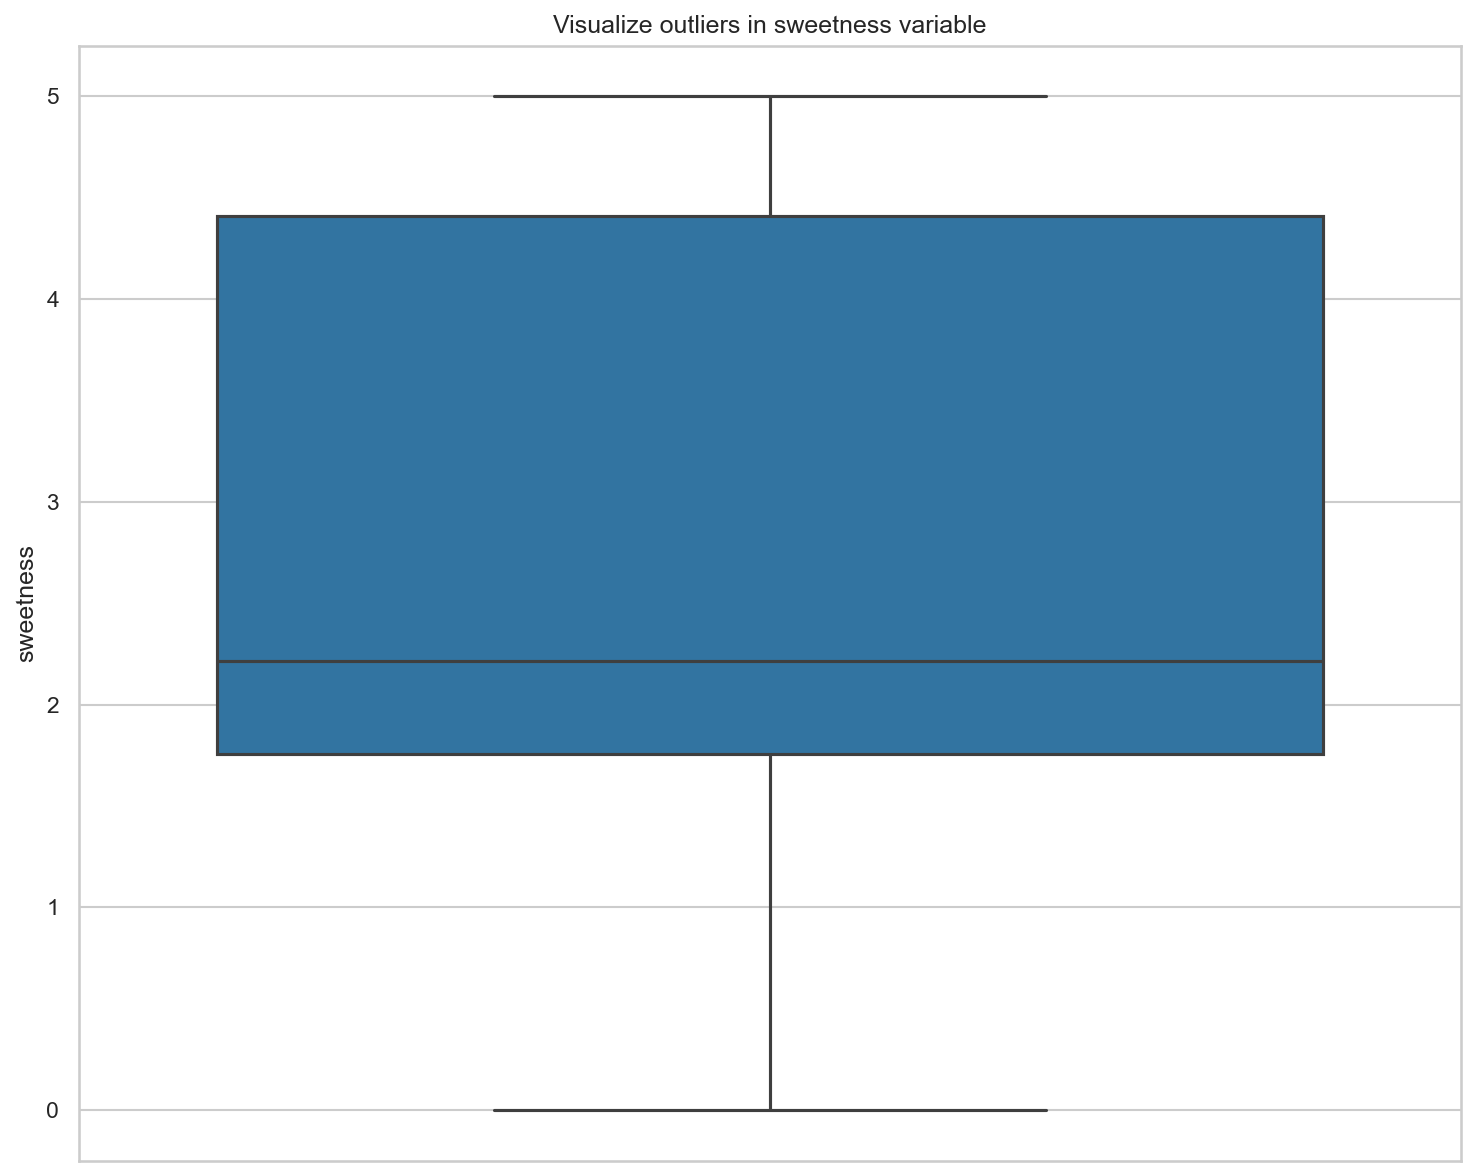

None


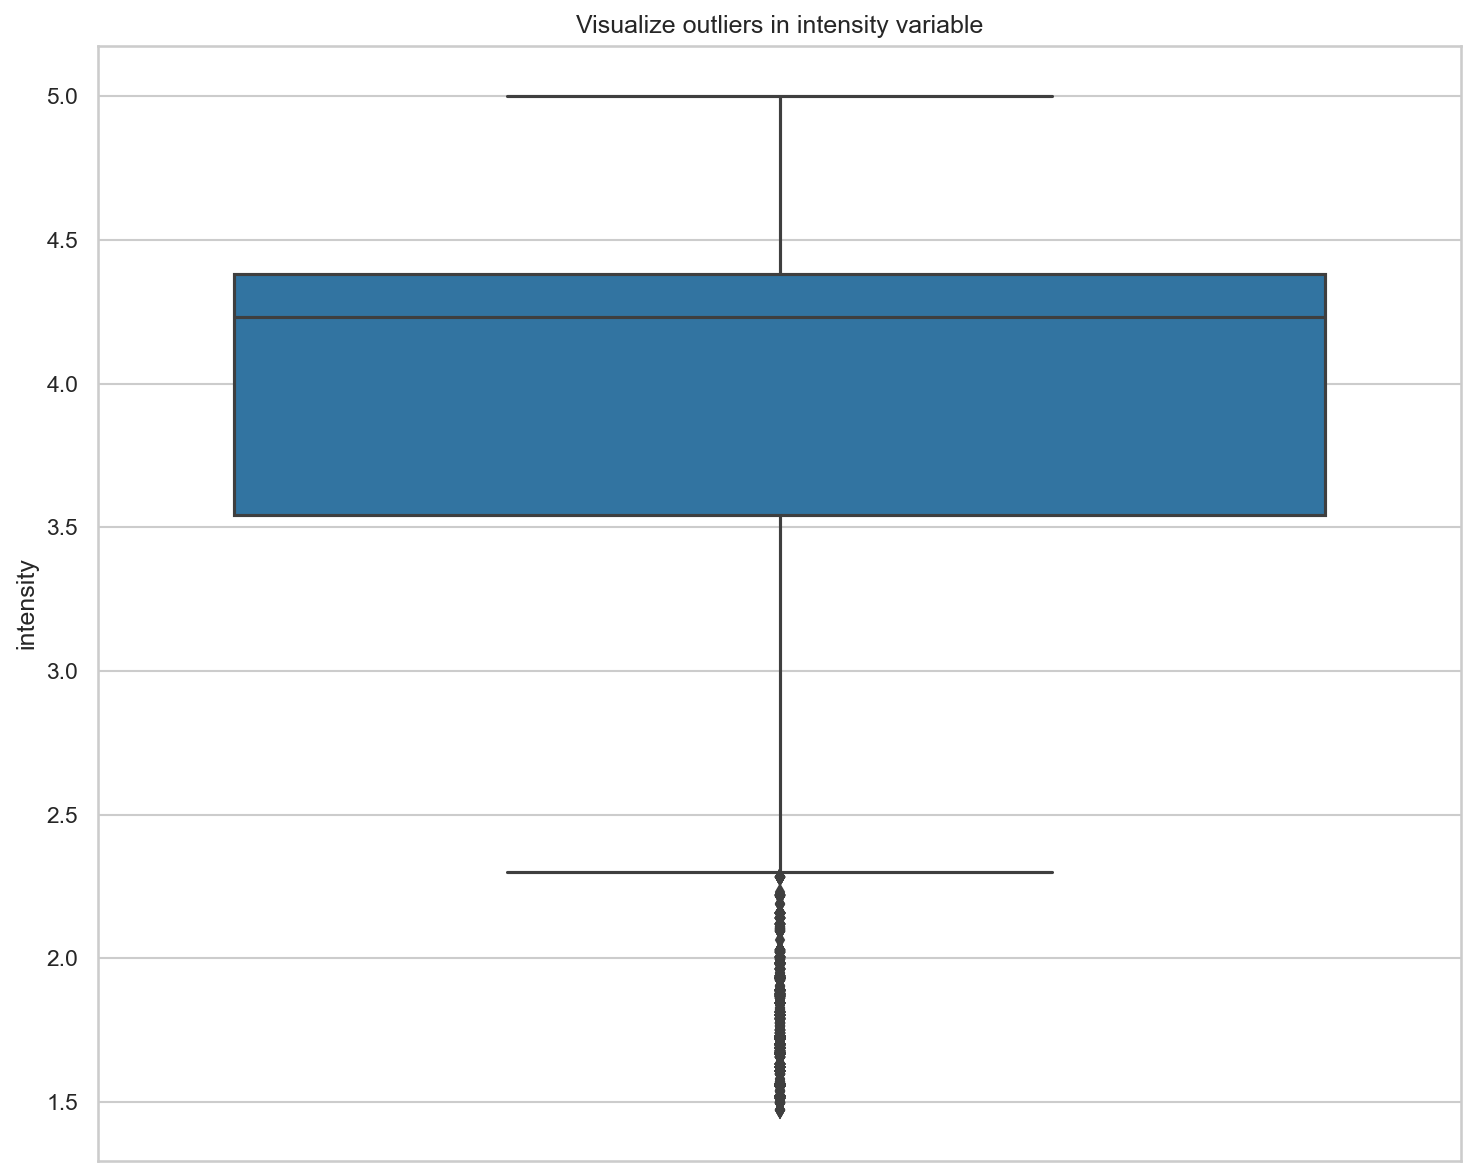

None


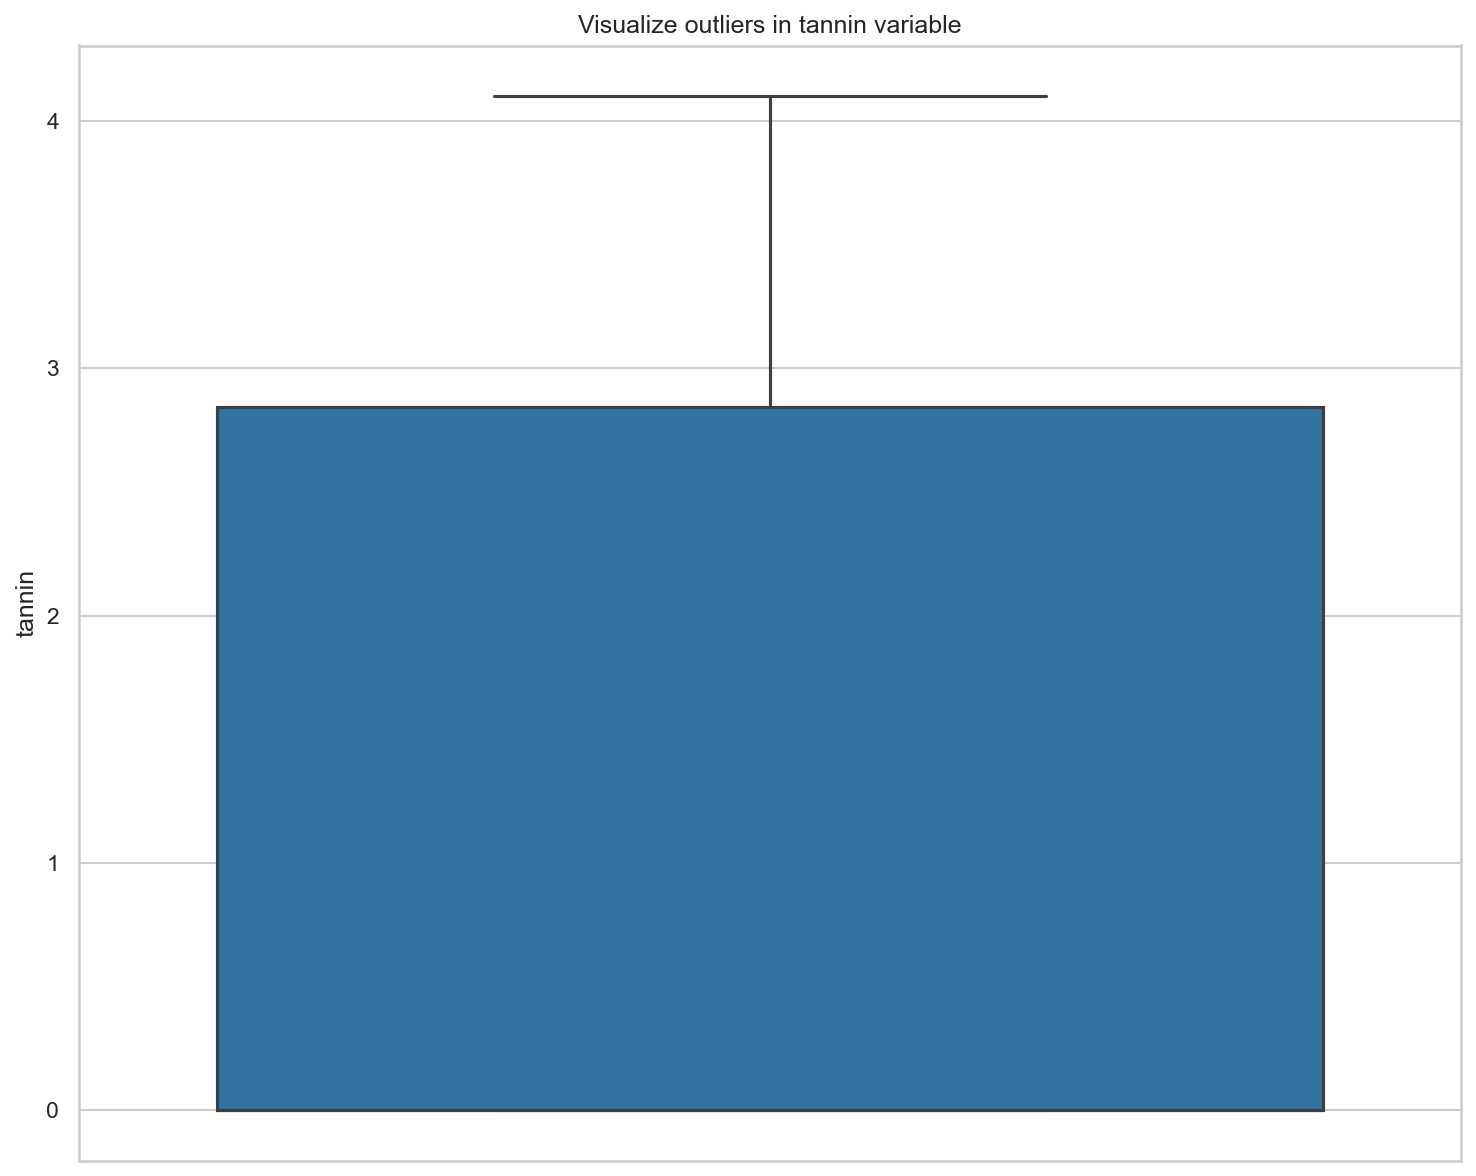

None


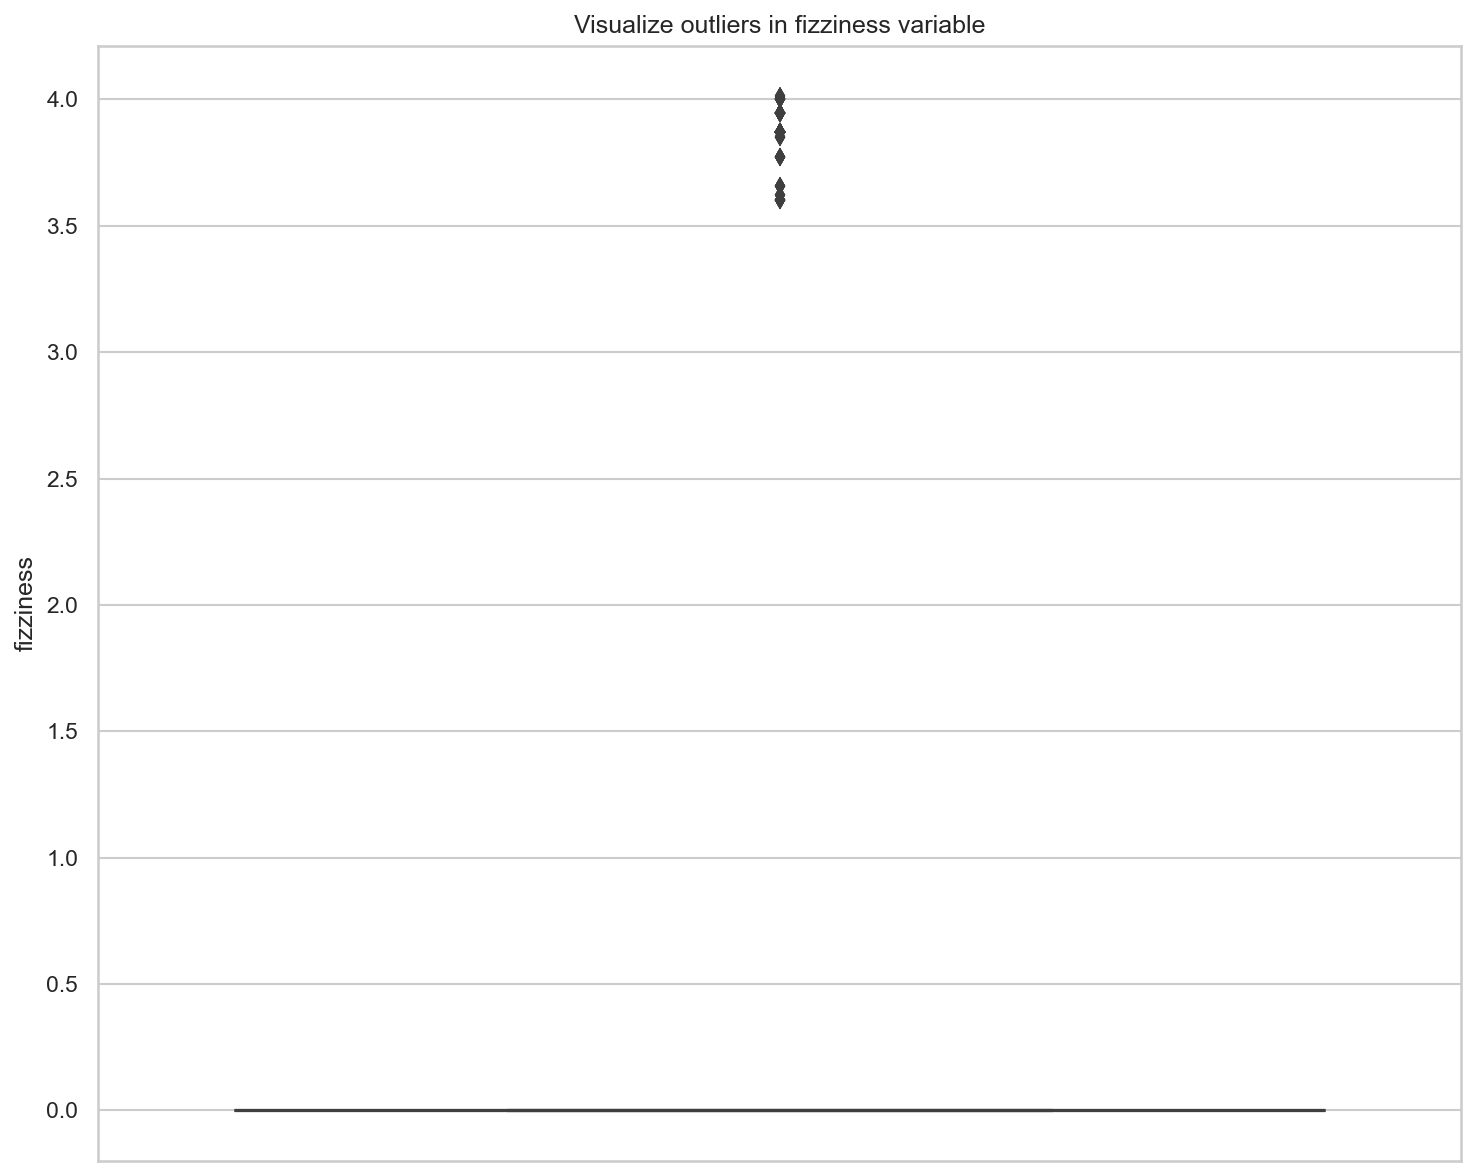

None


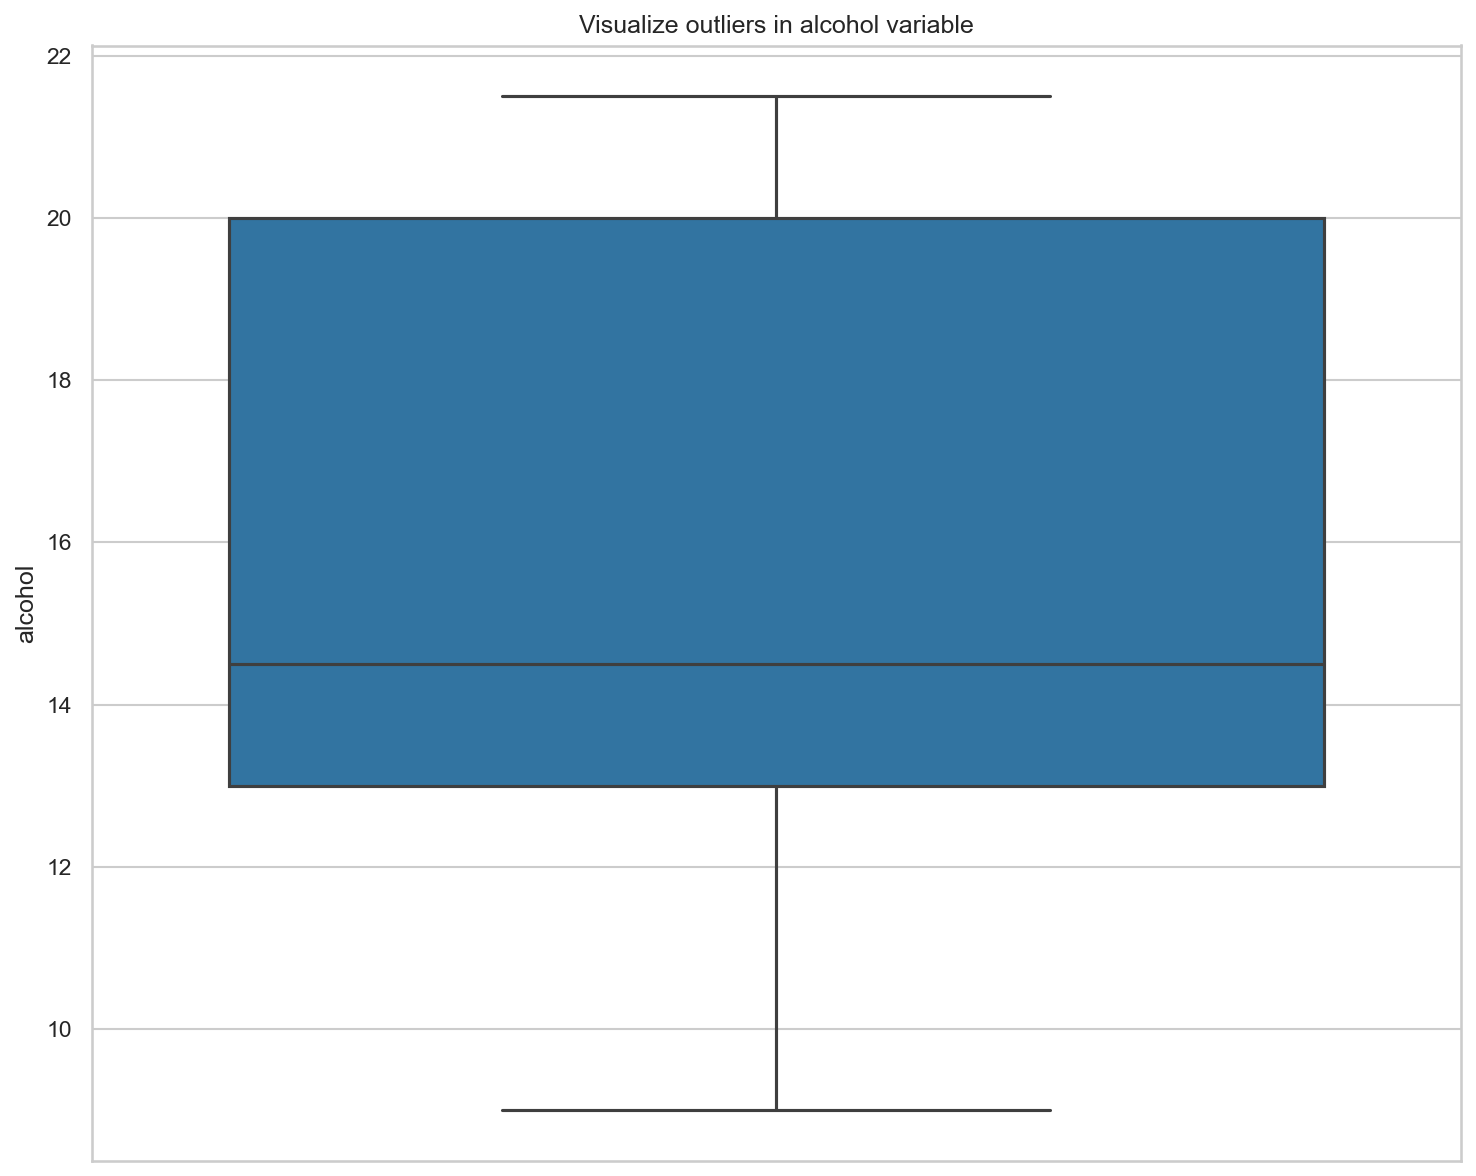

None


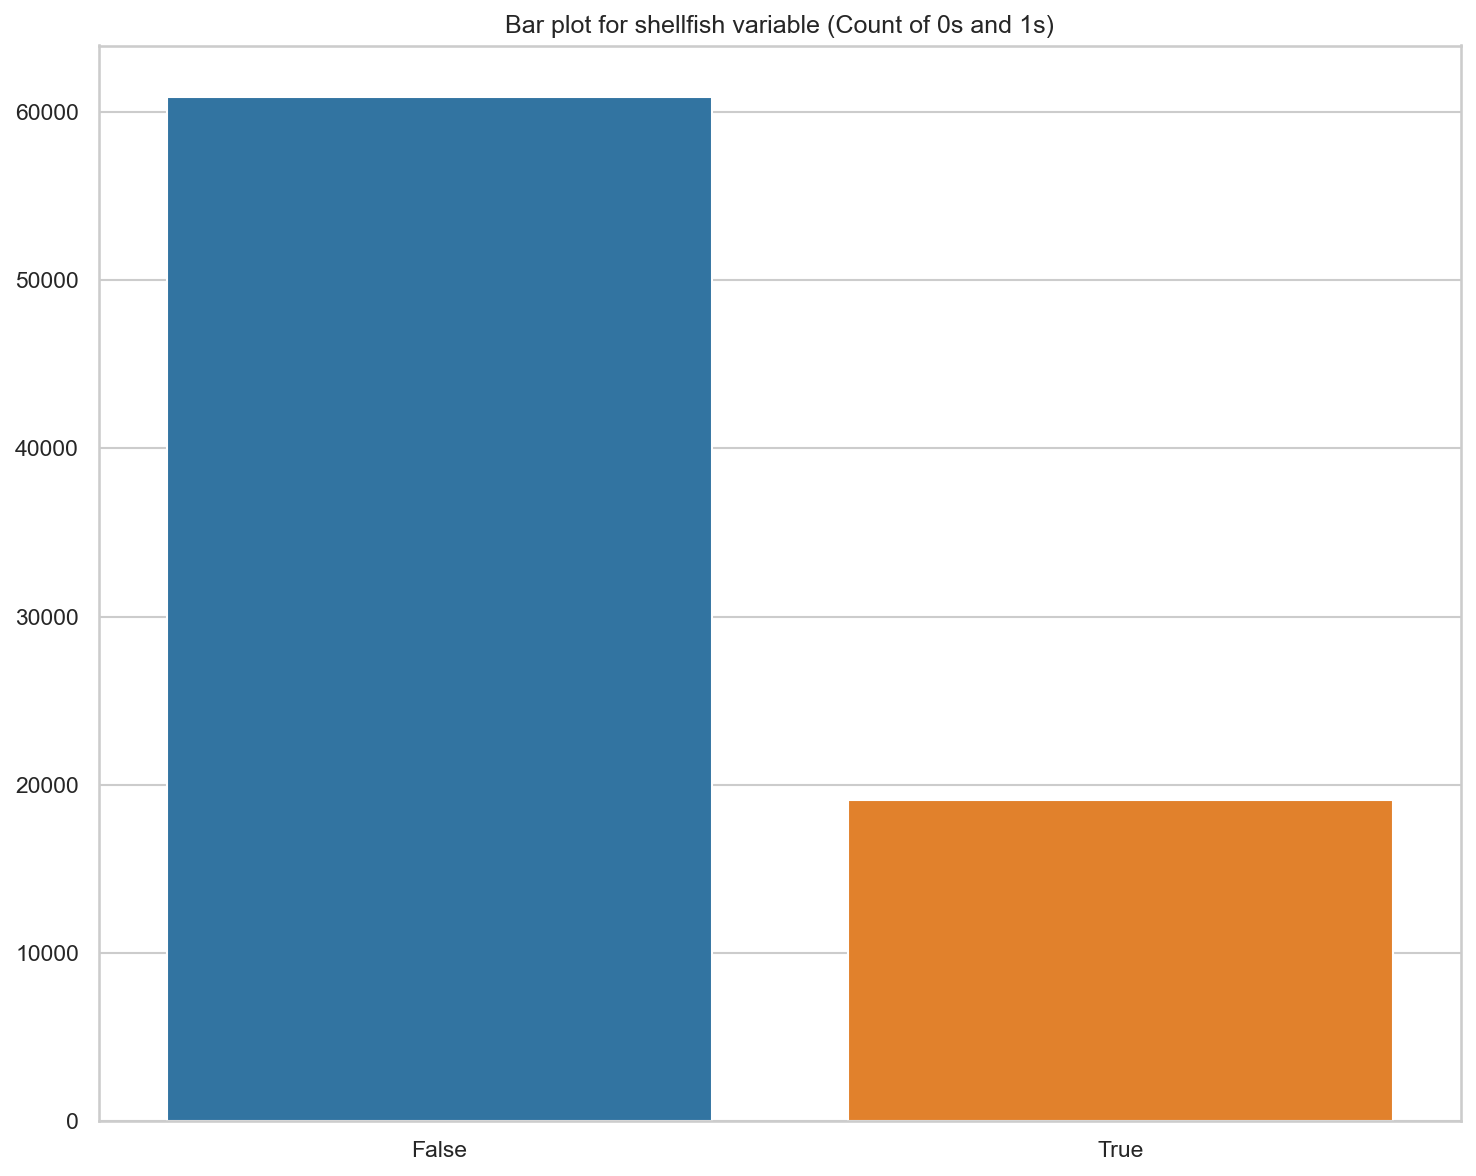

None


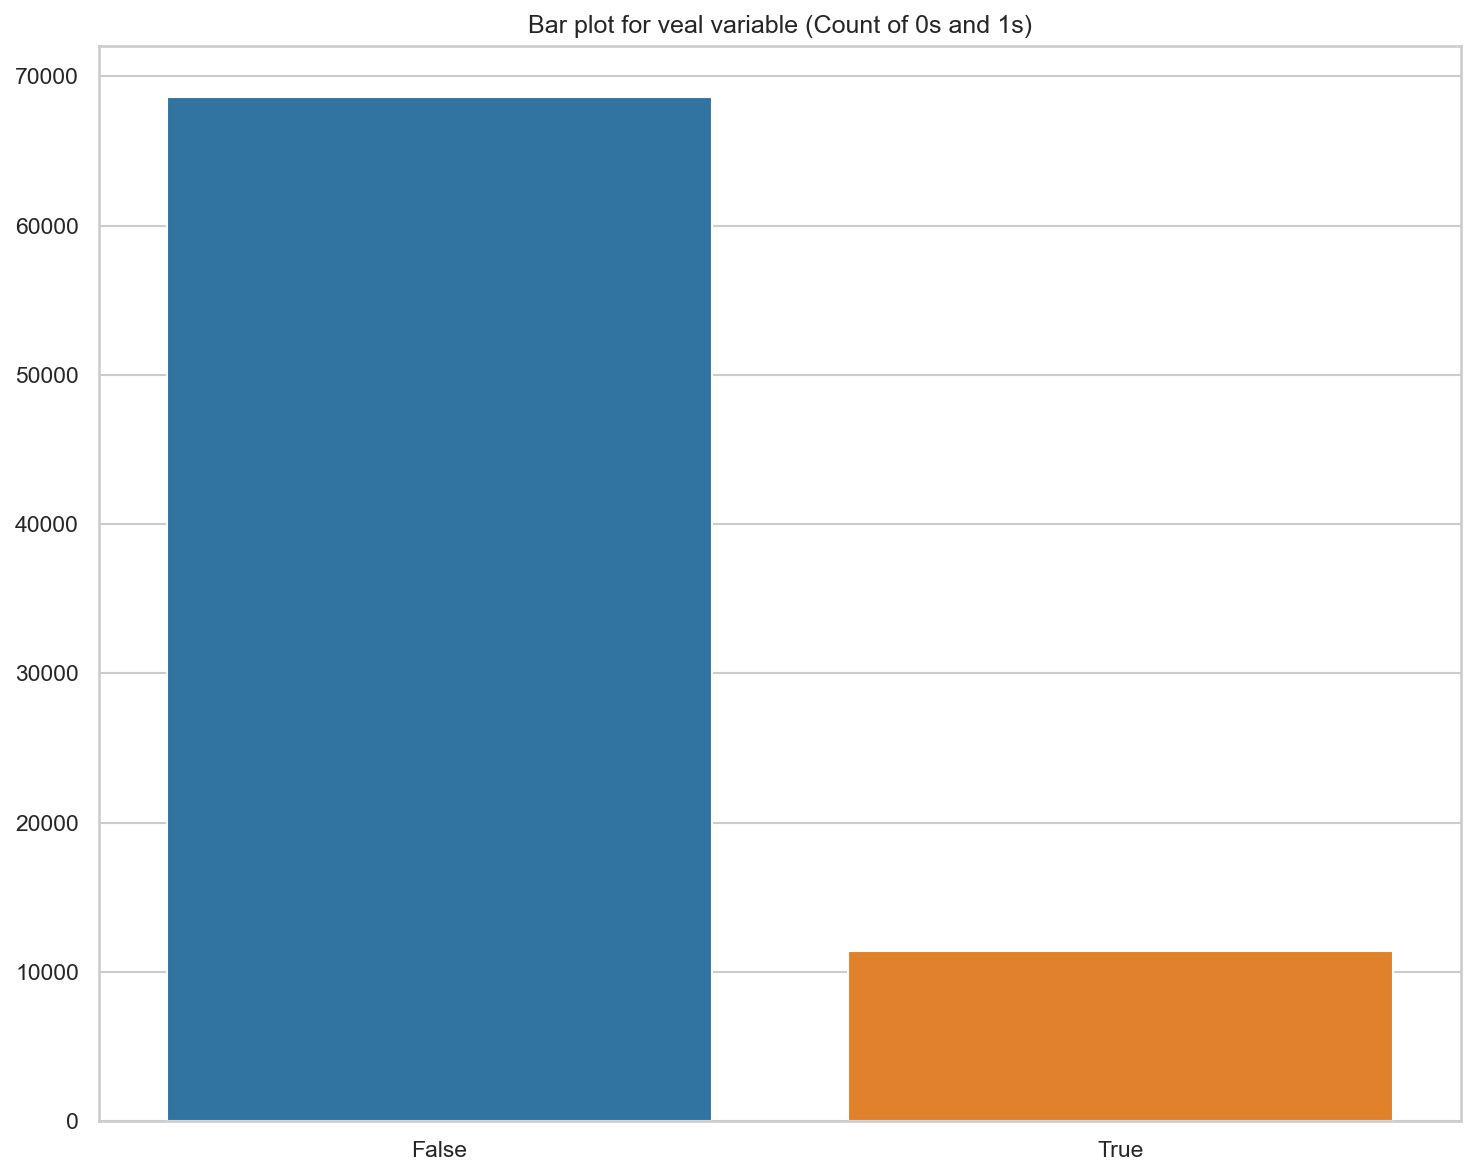

None


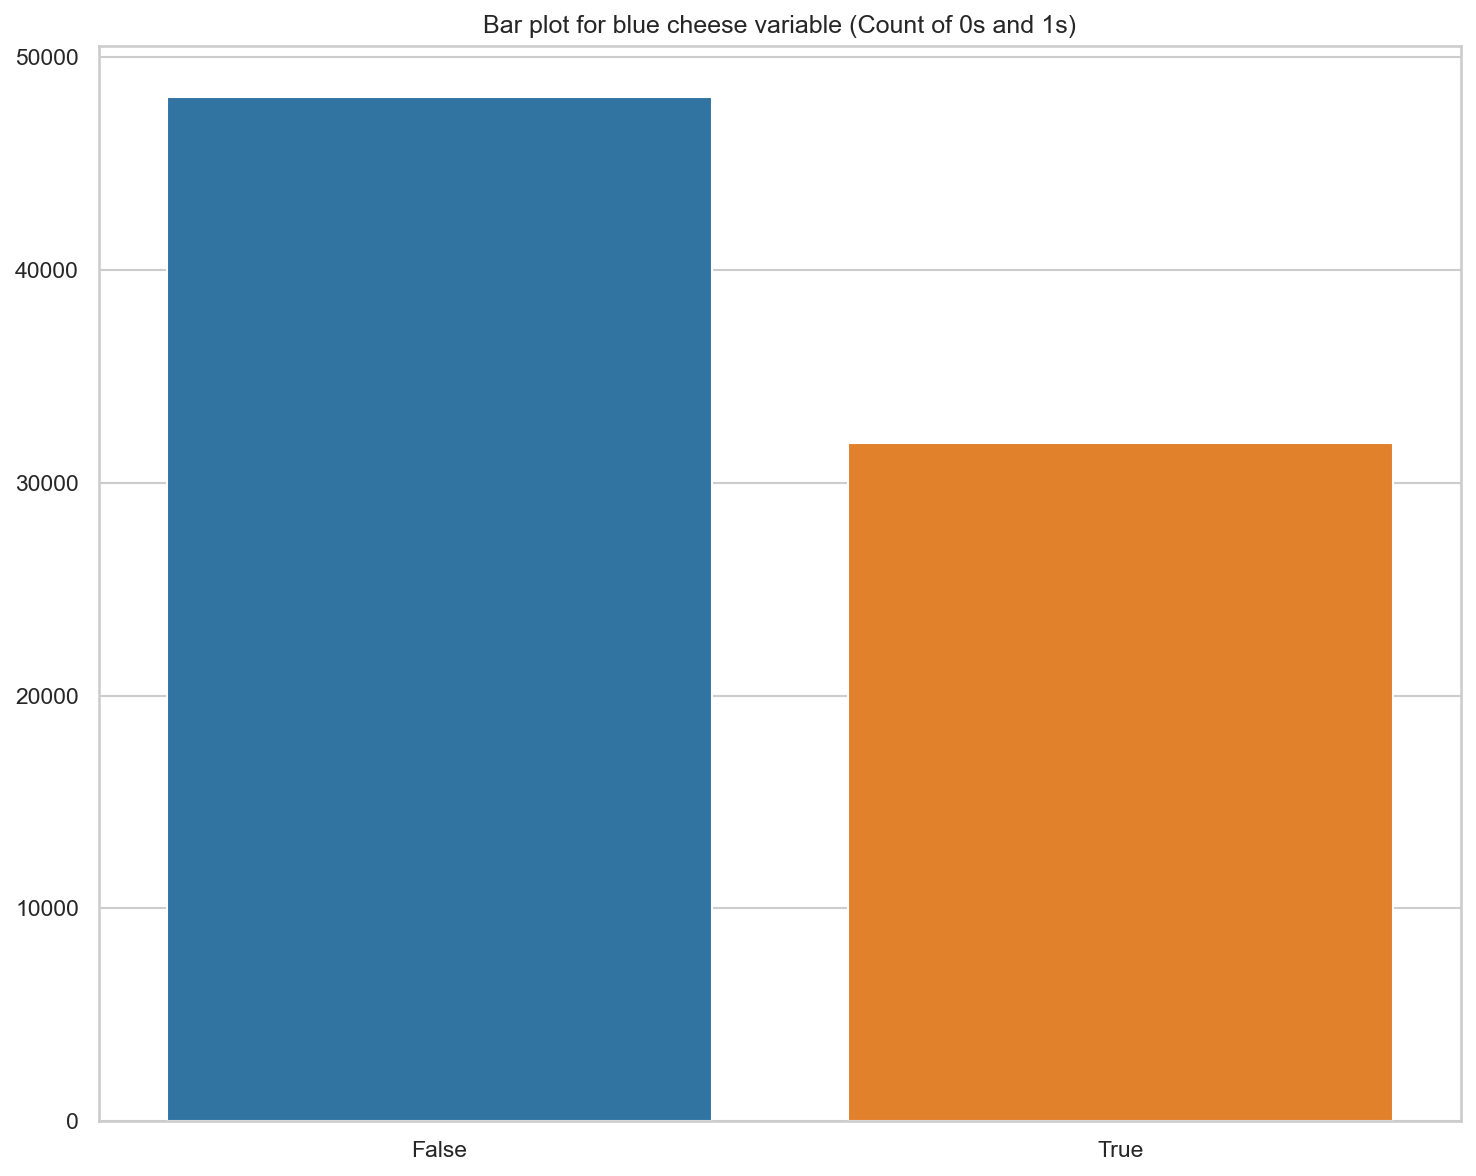

None


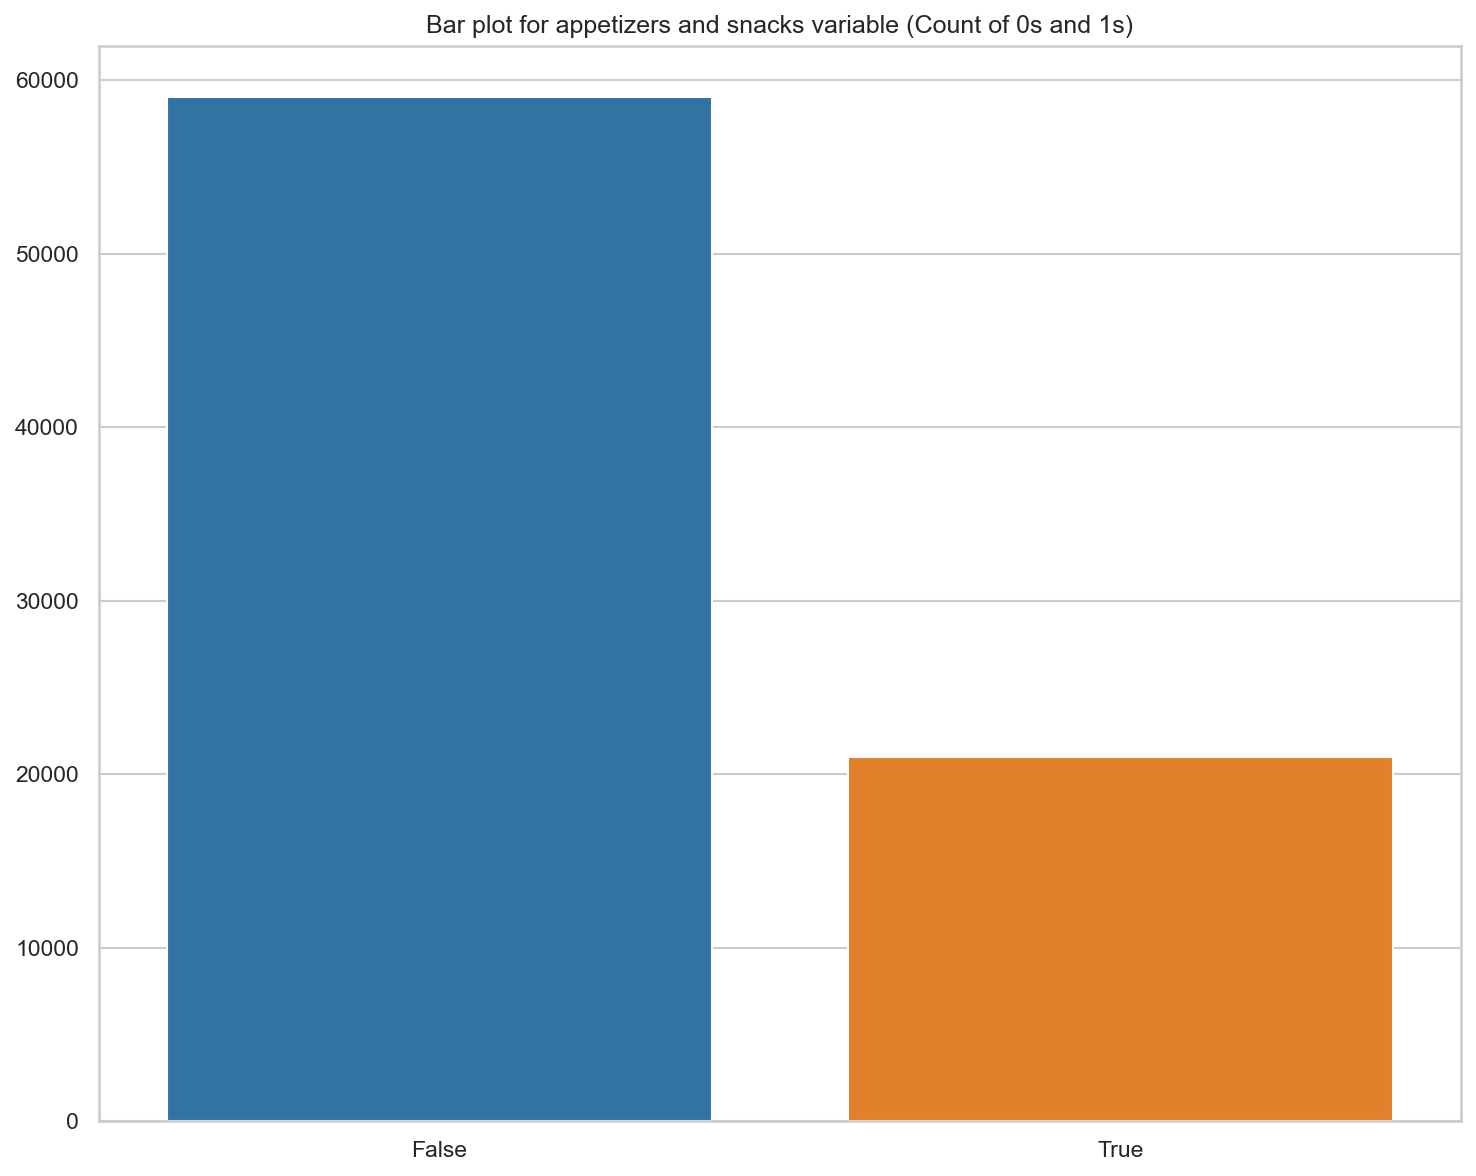

None


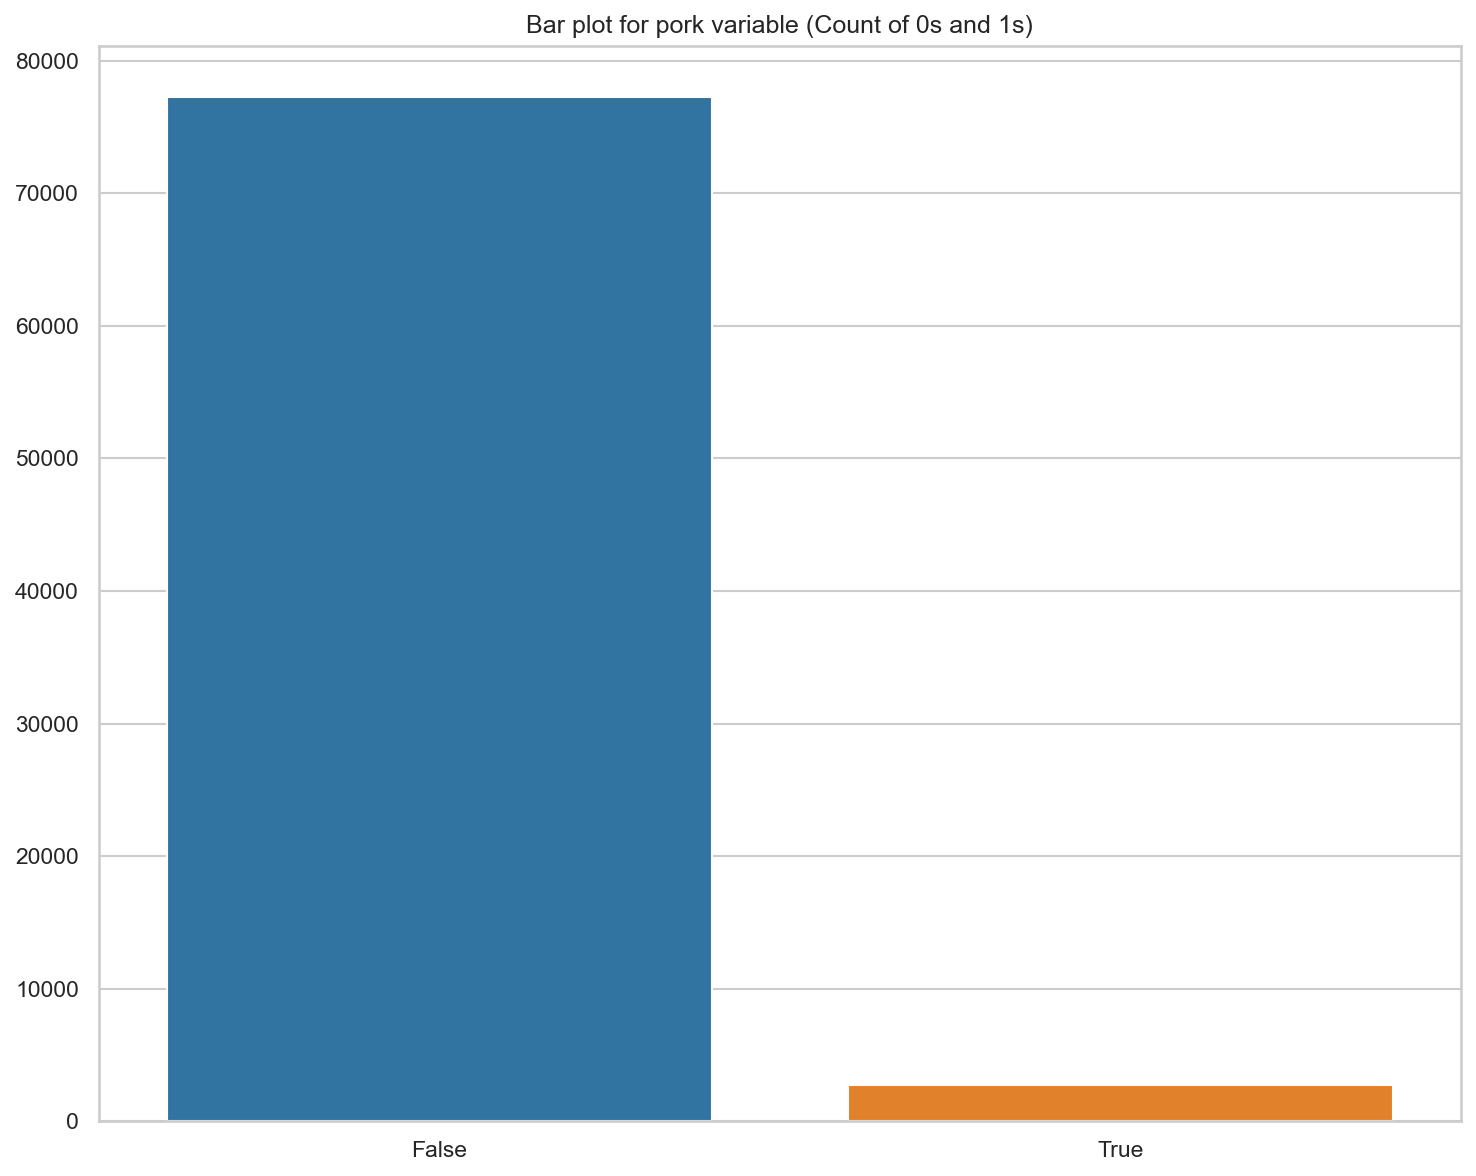

None


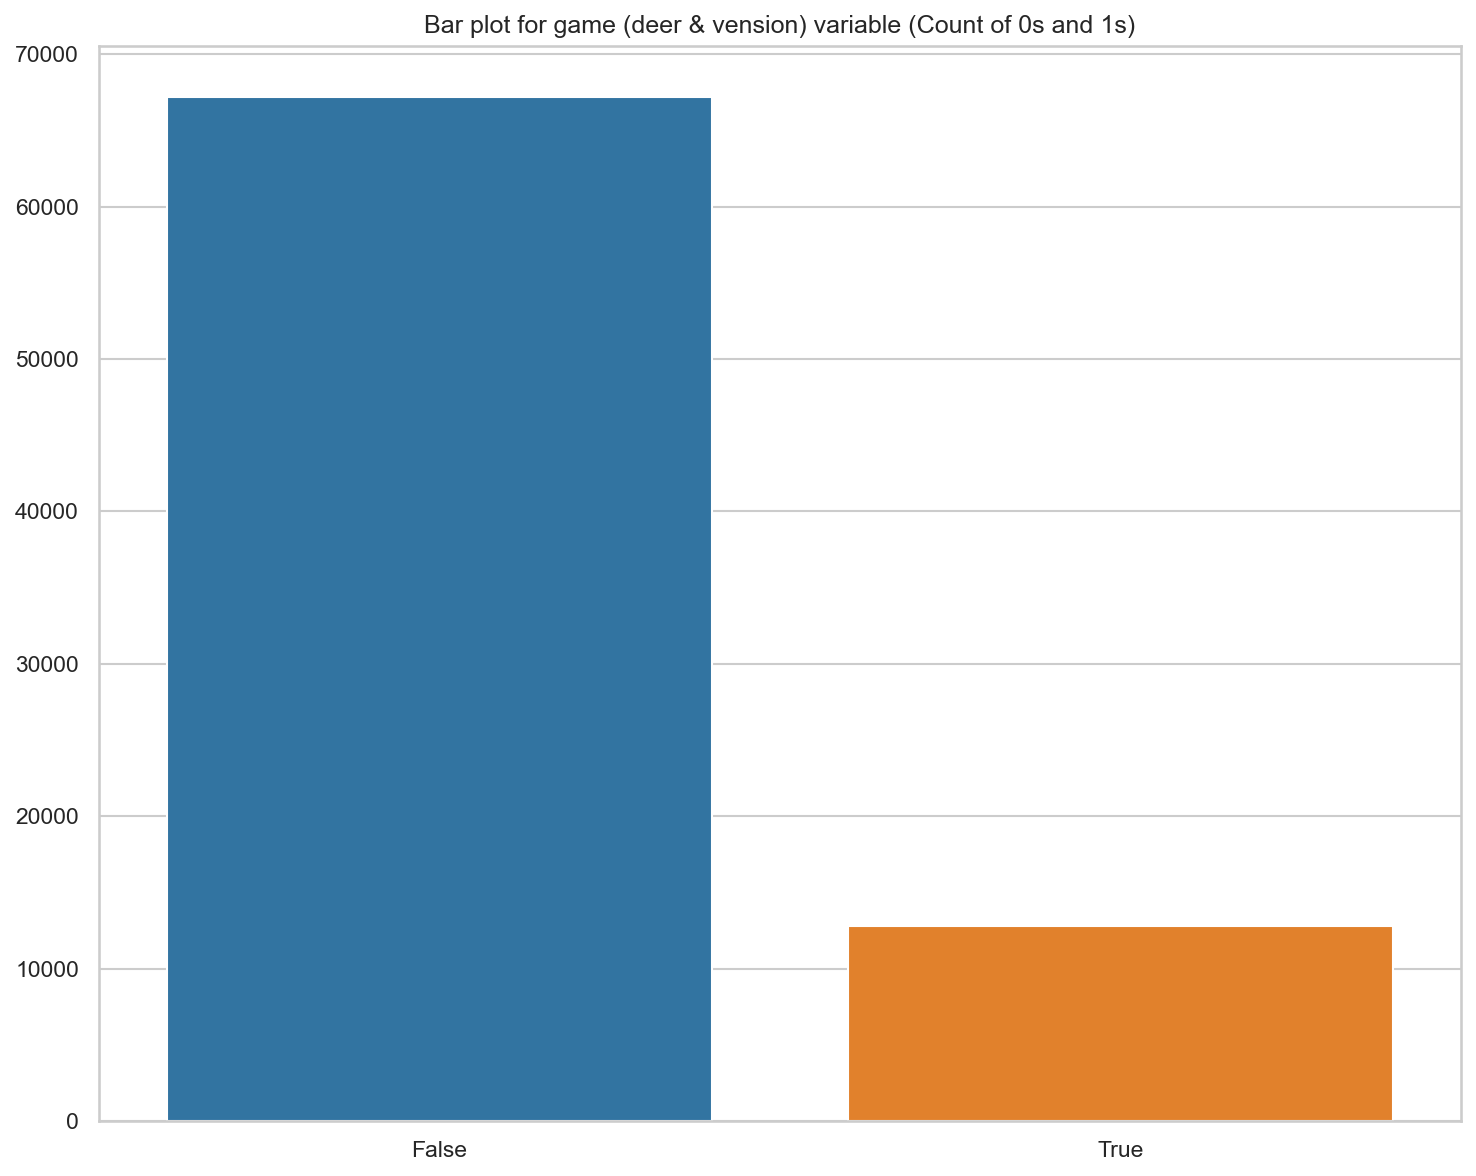

None


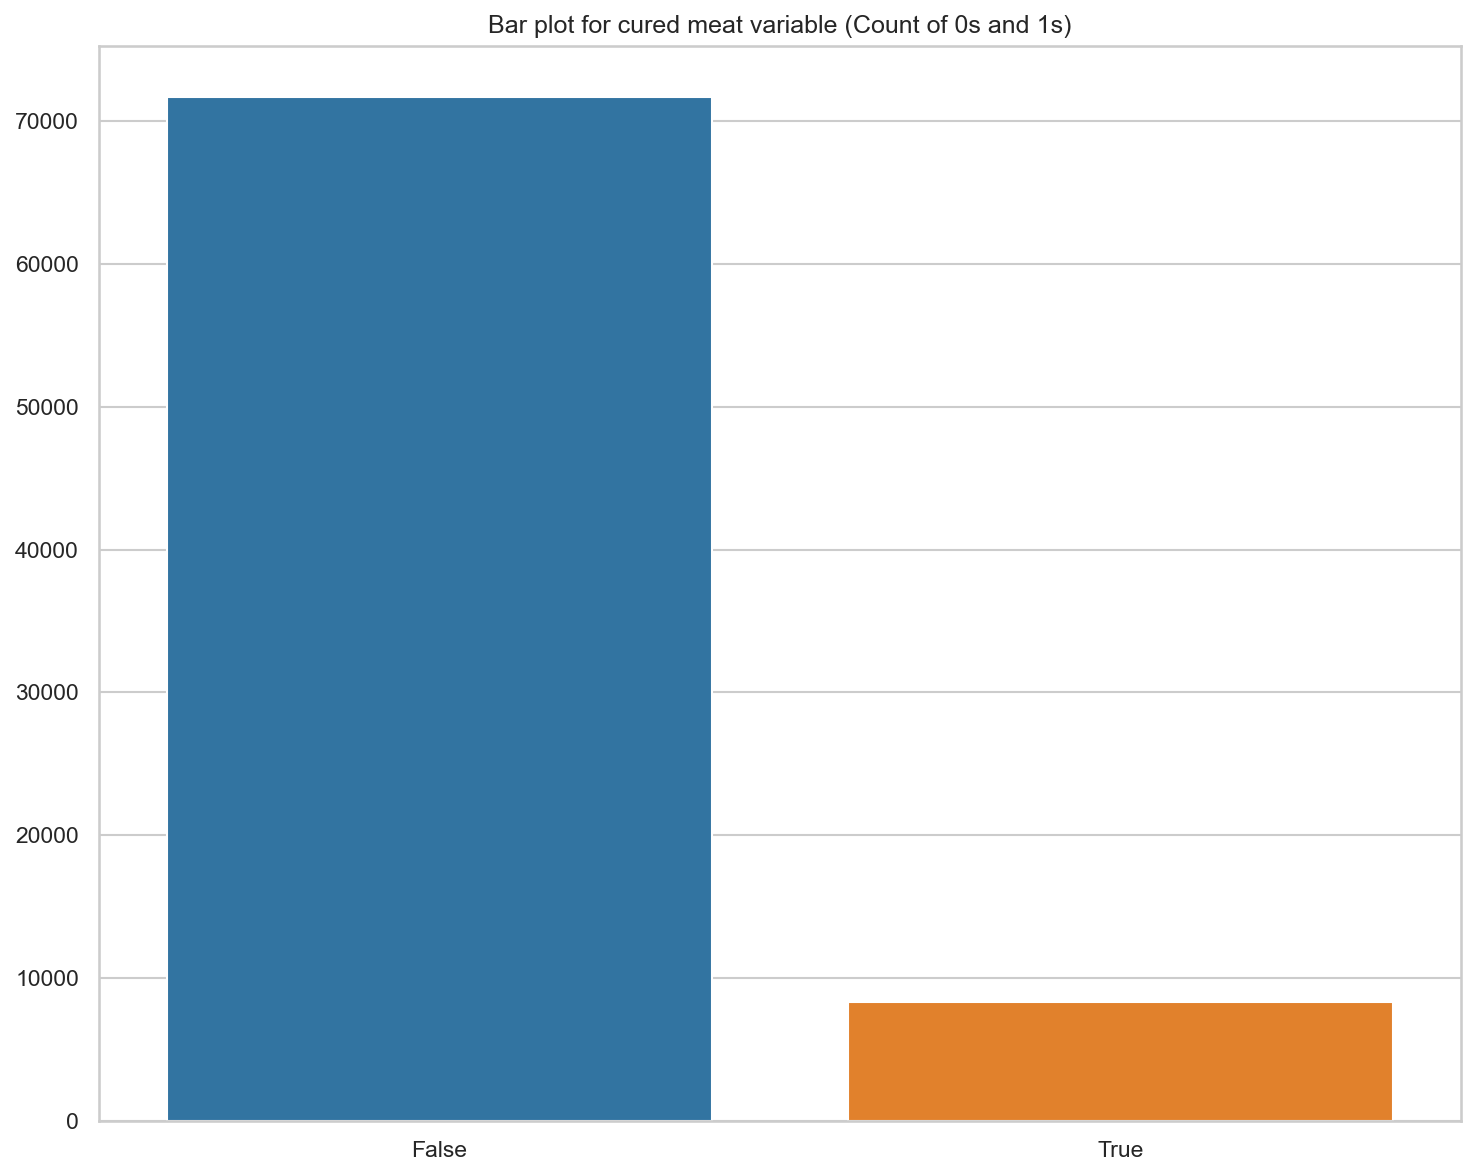

None


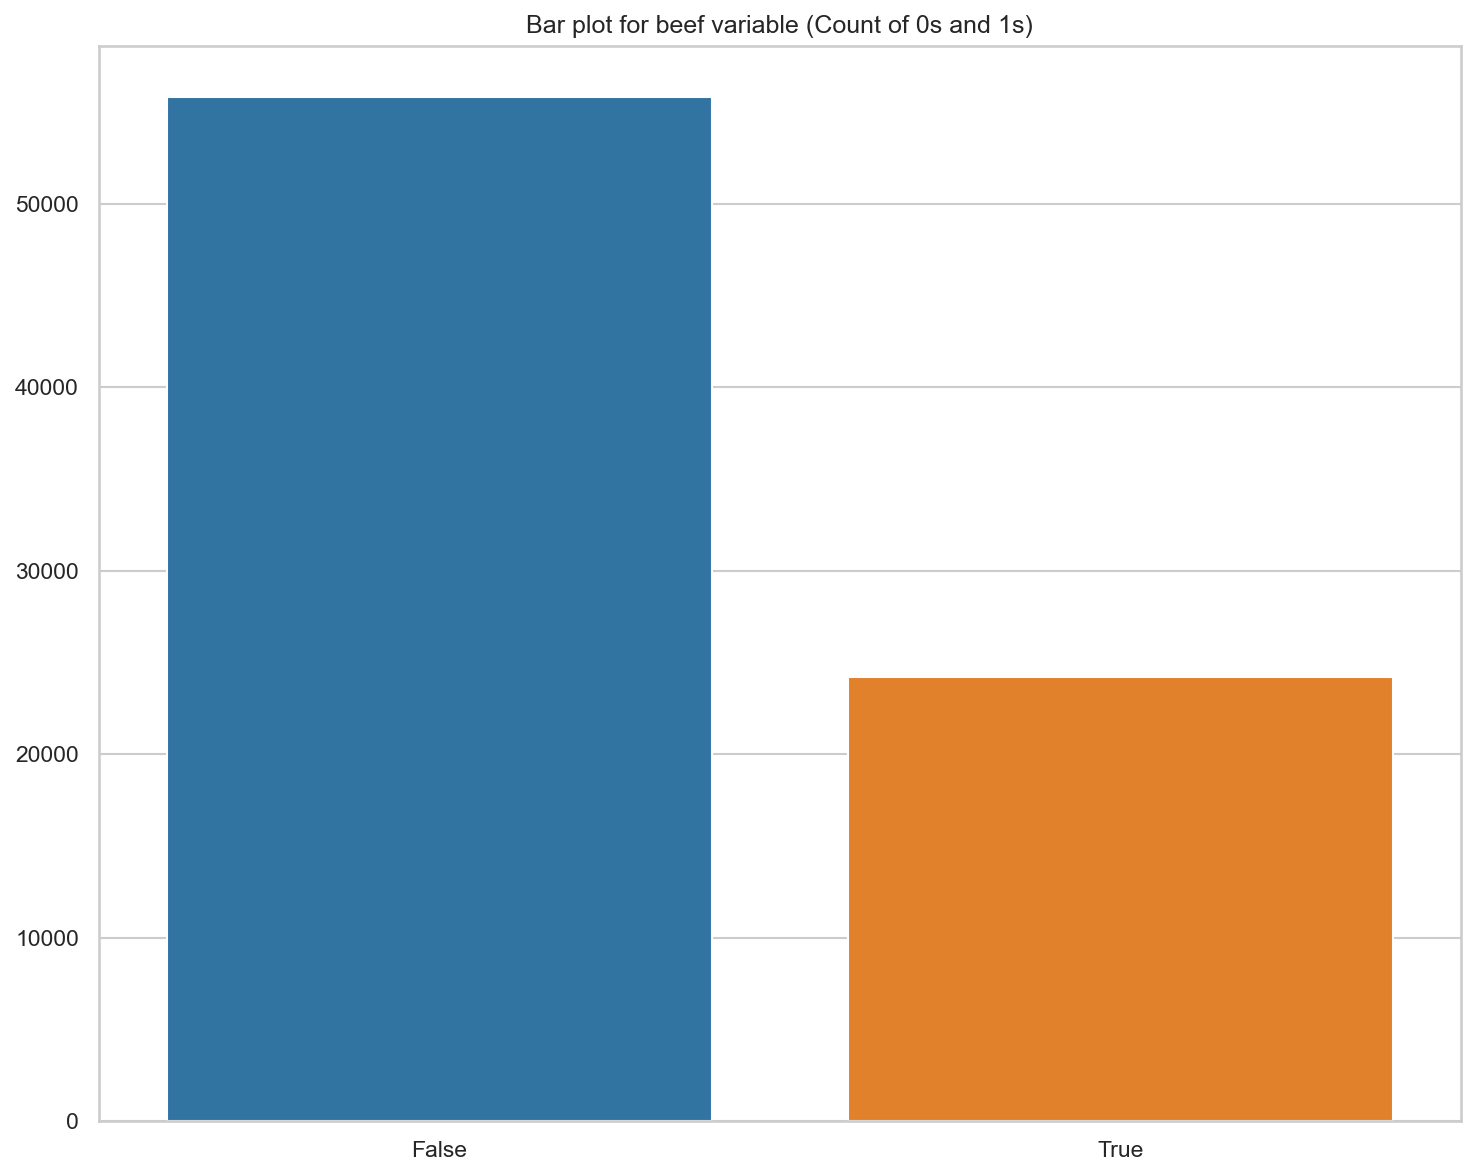

None


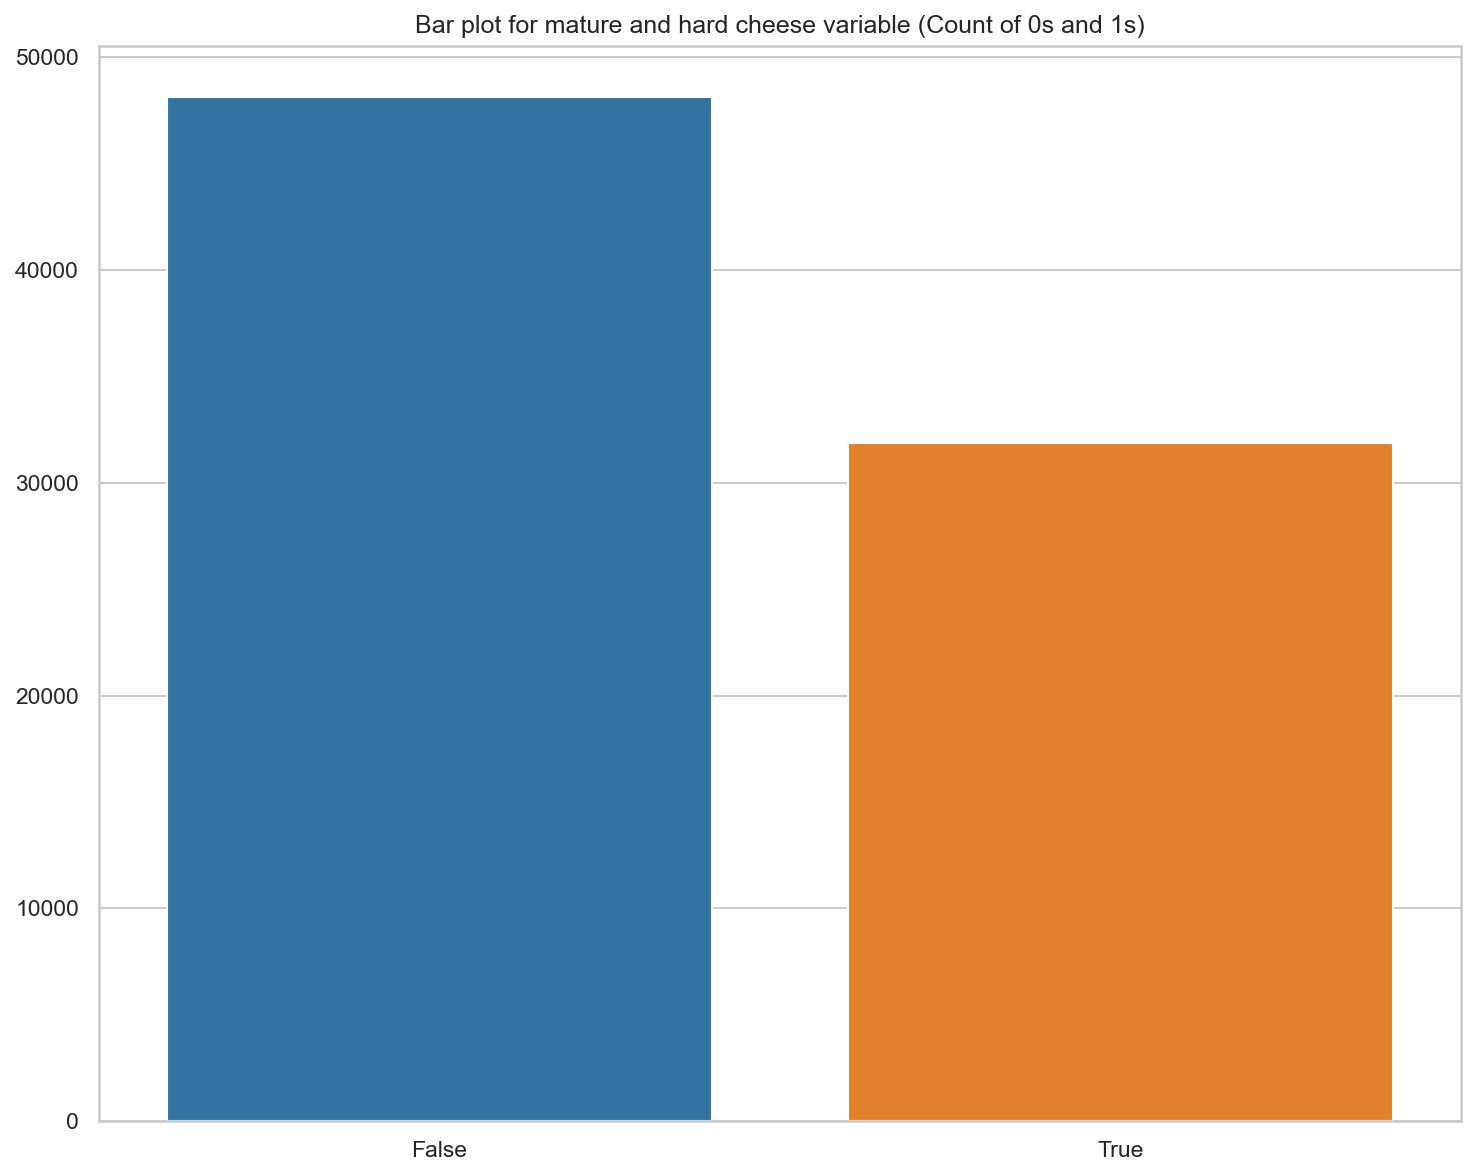

None


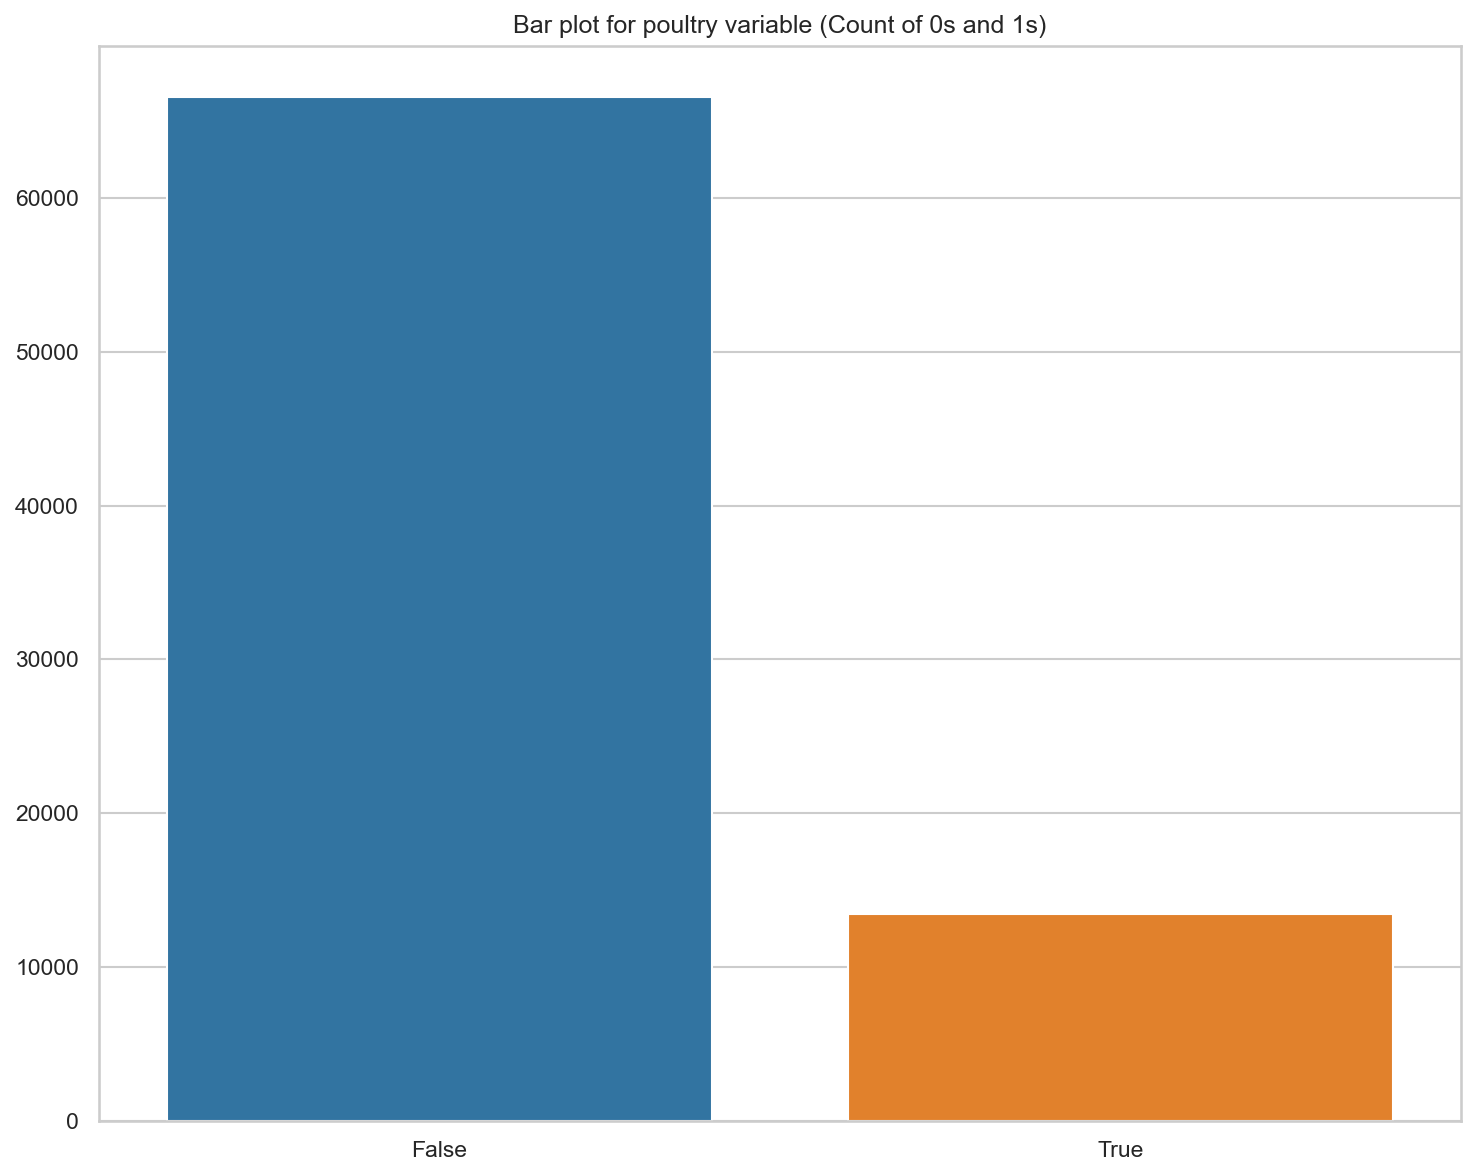

None


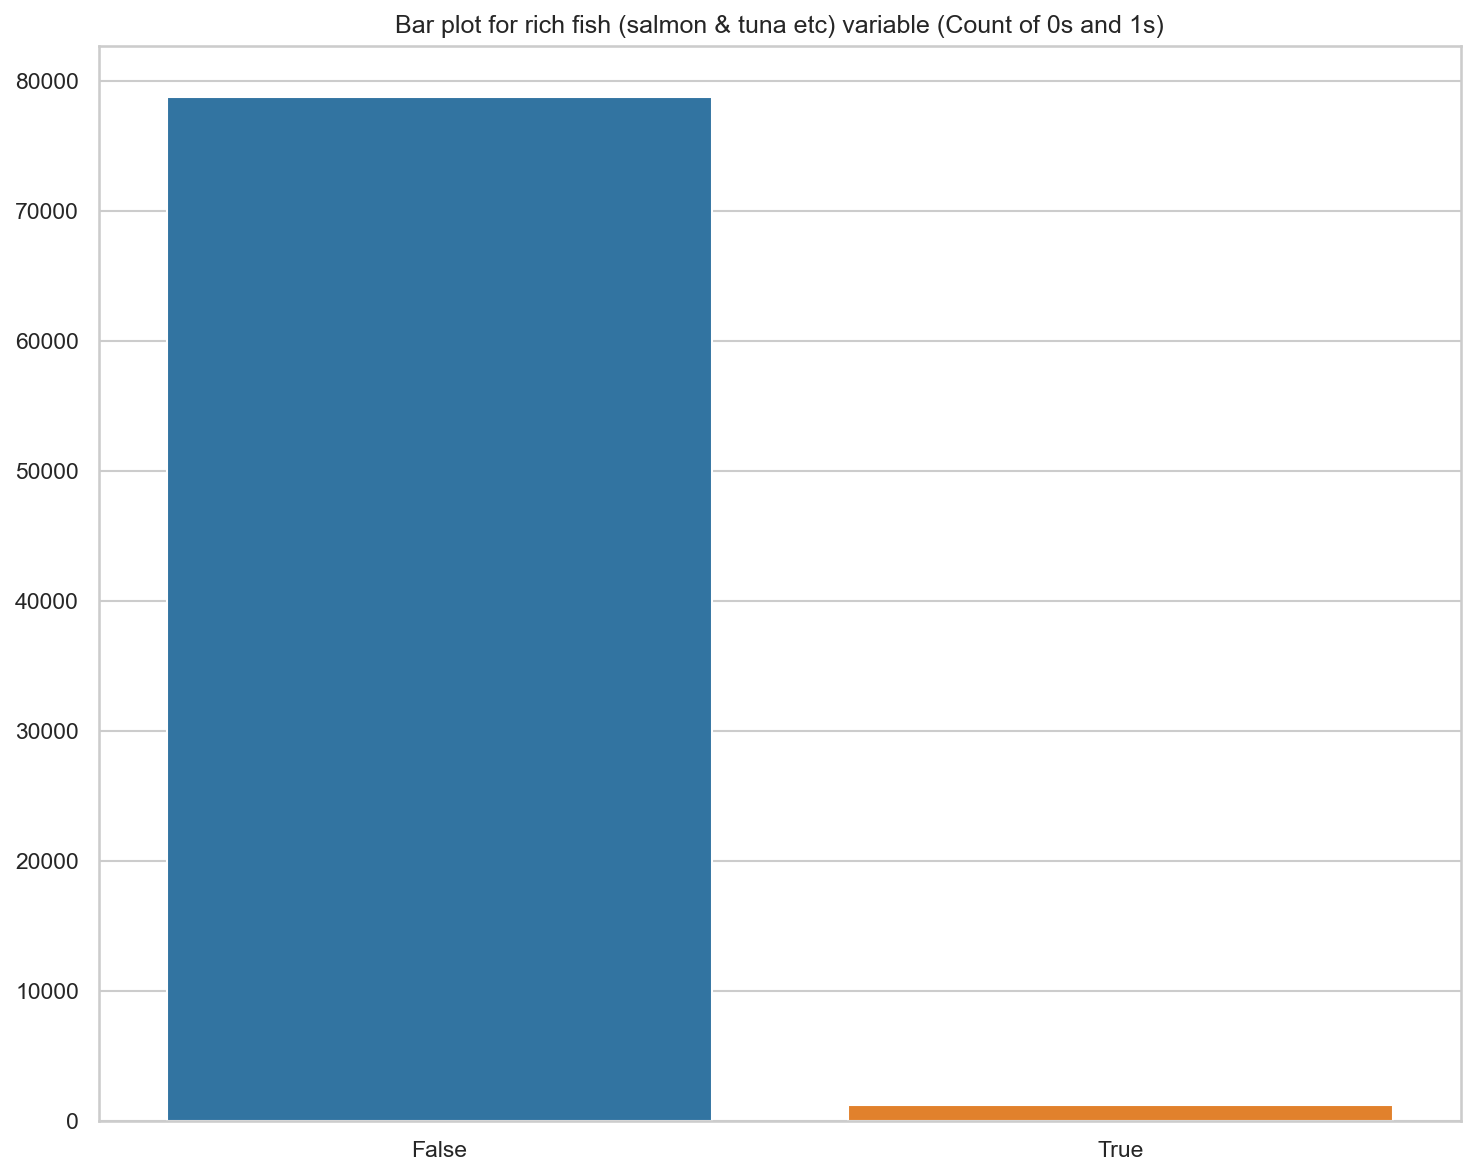

None


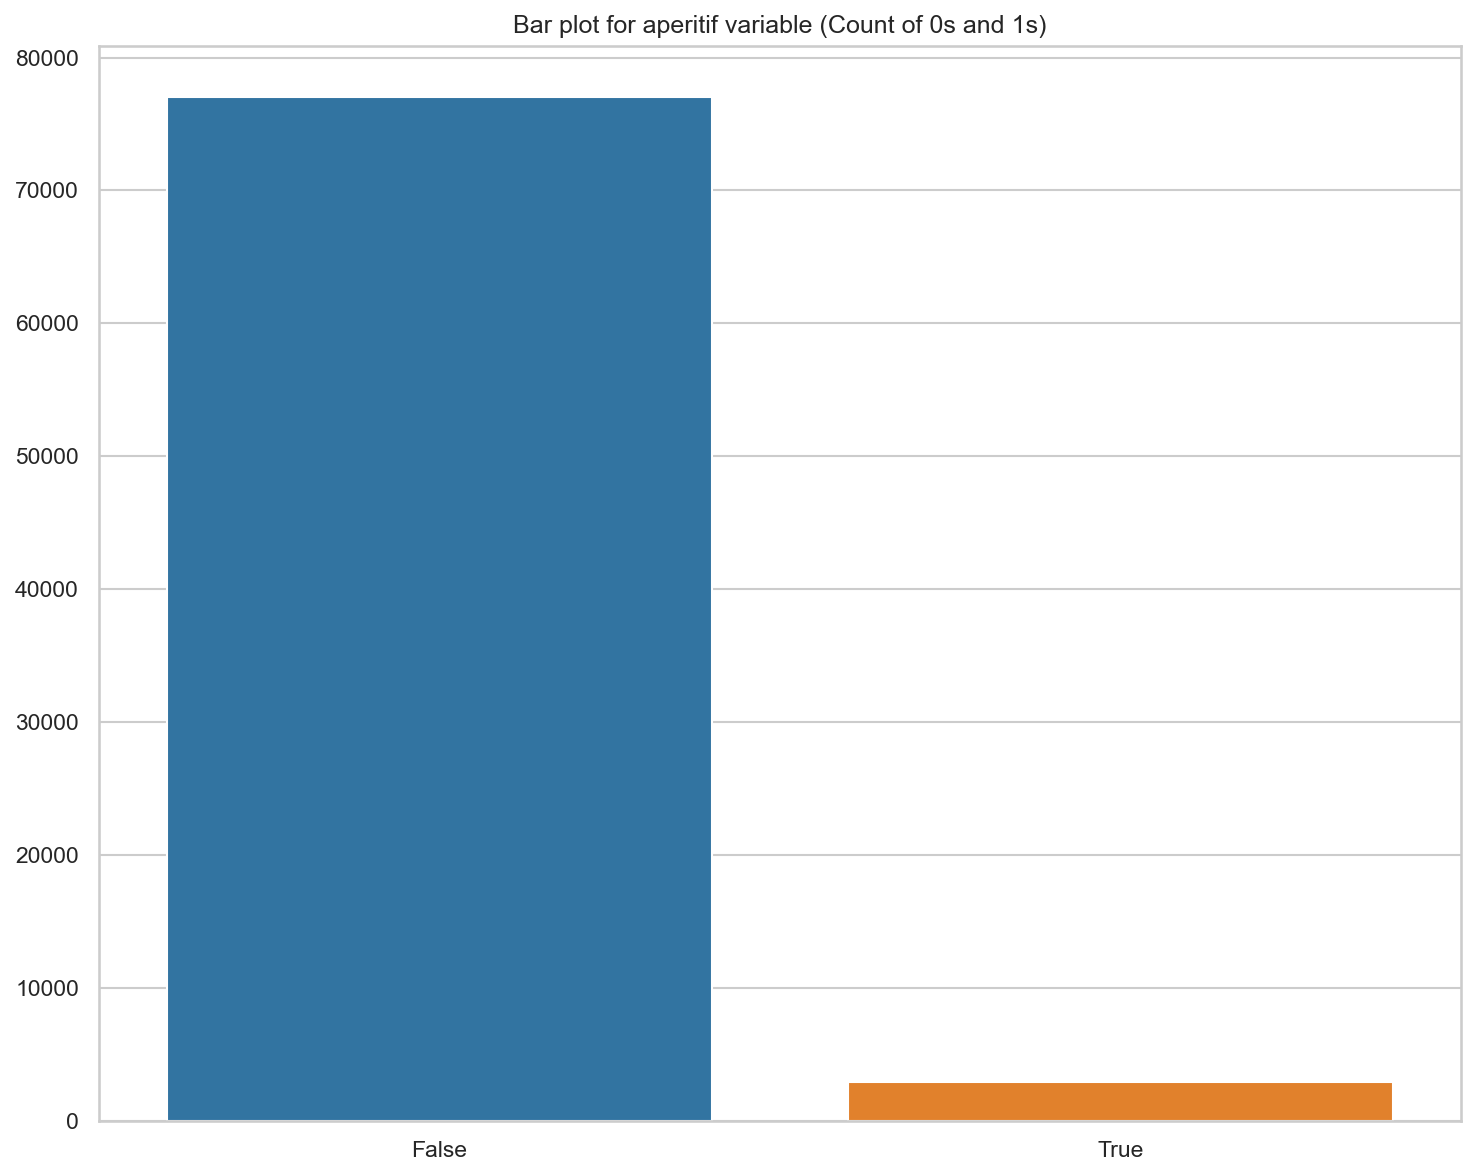

None


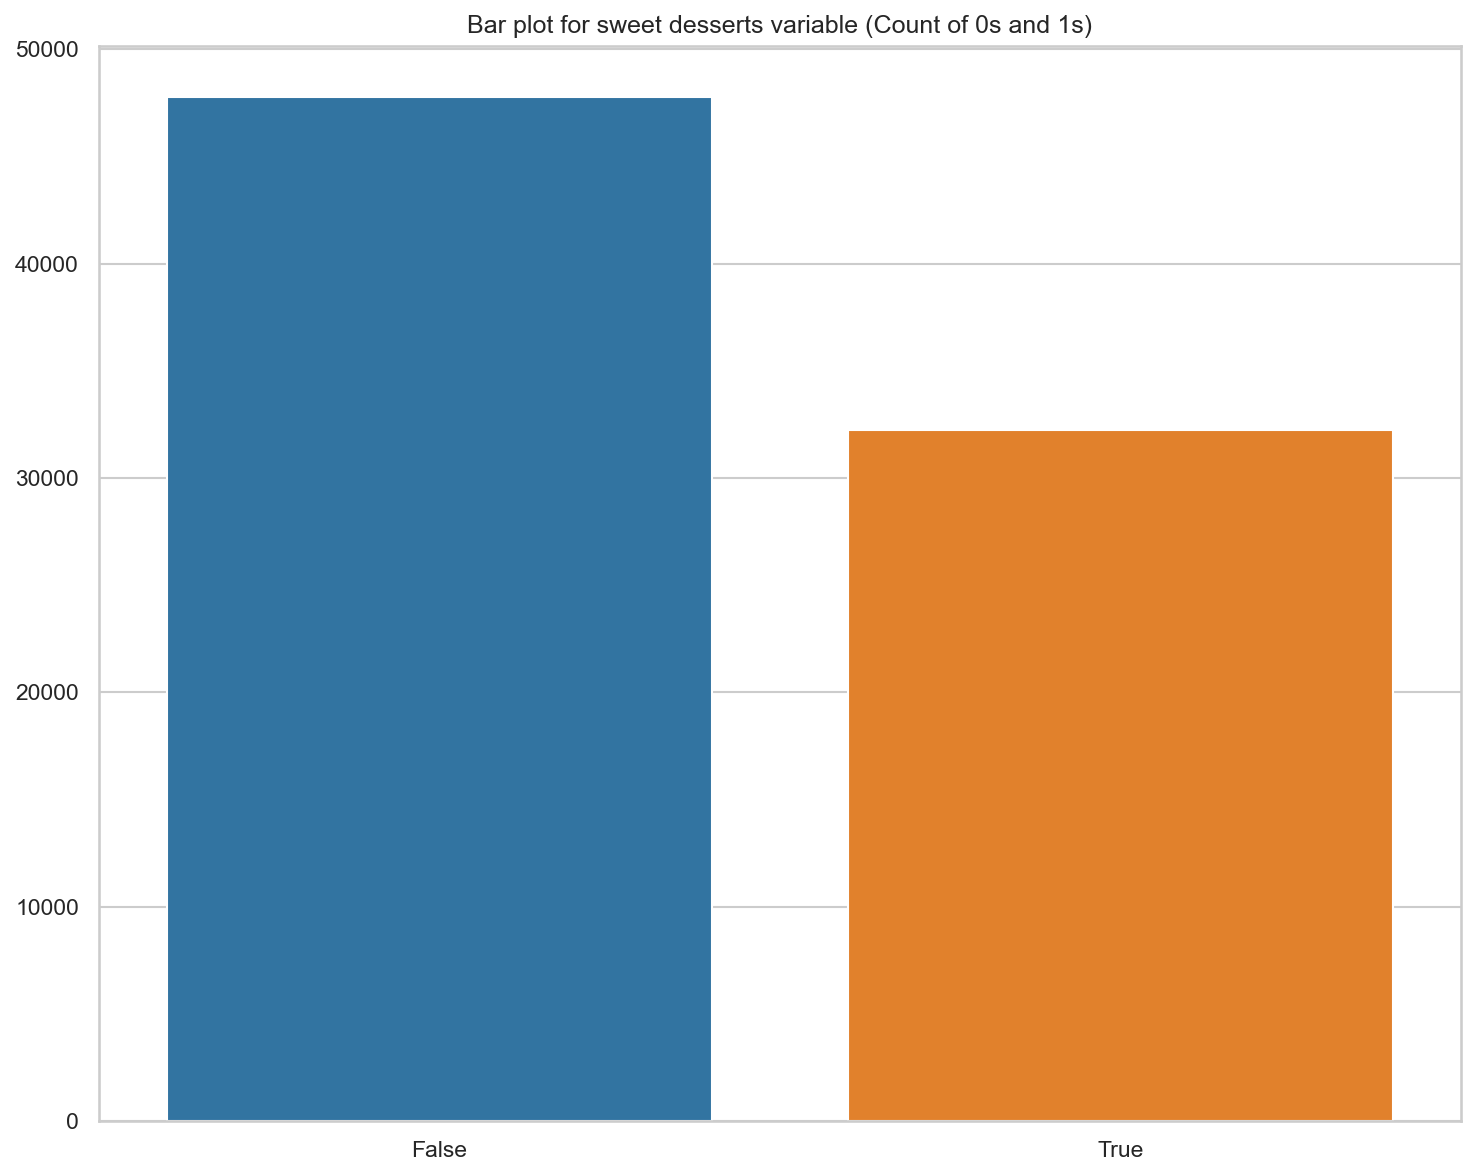

None


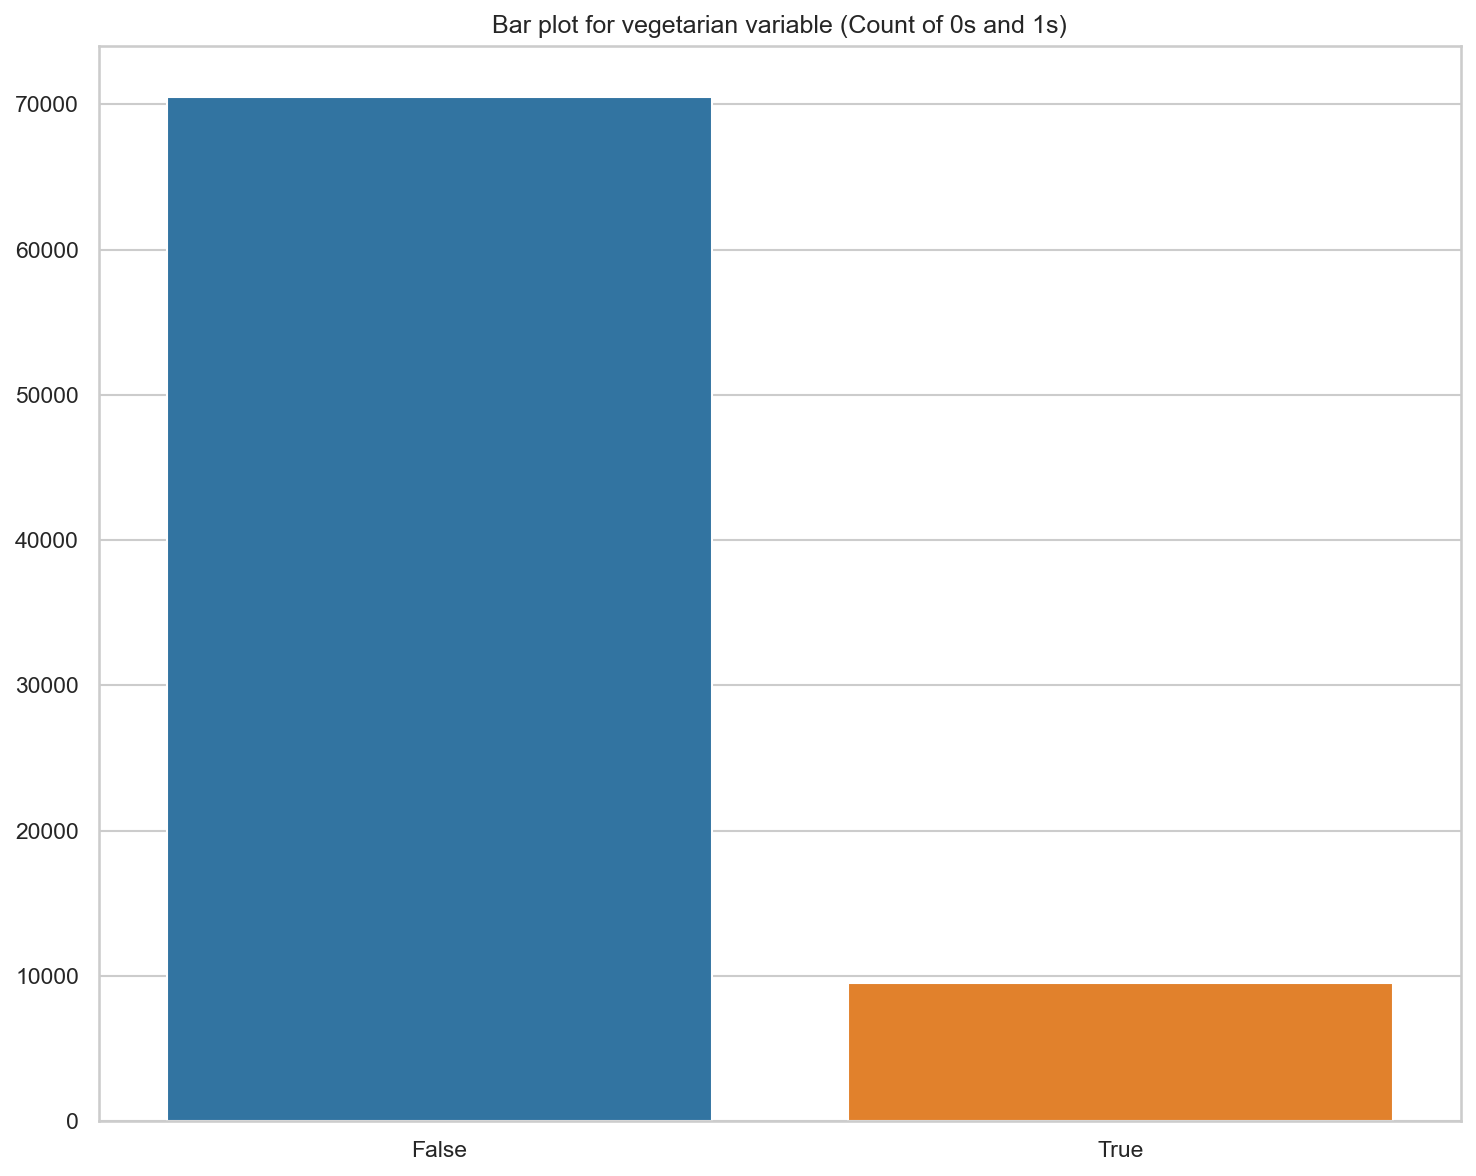

None


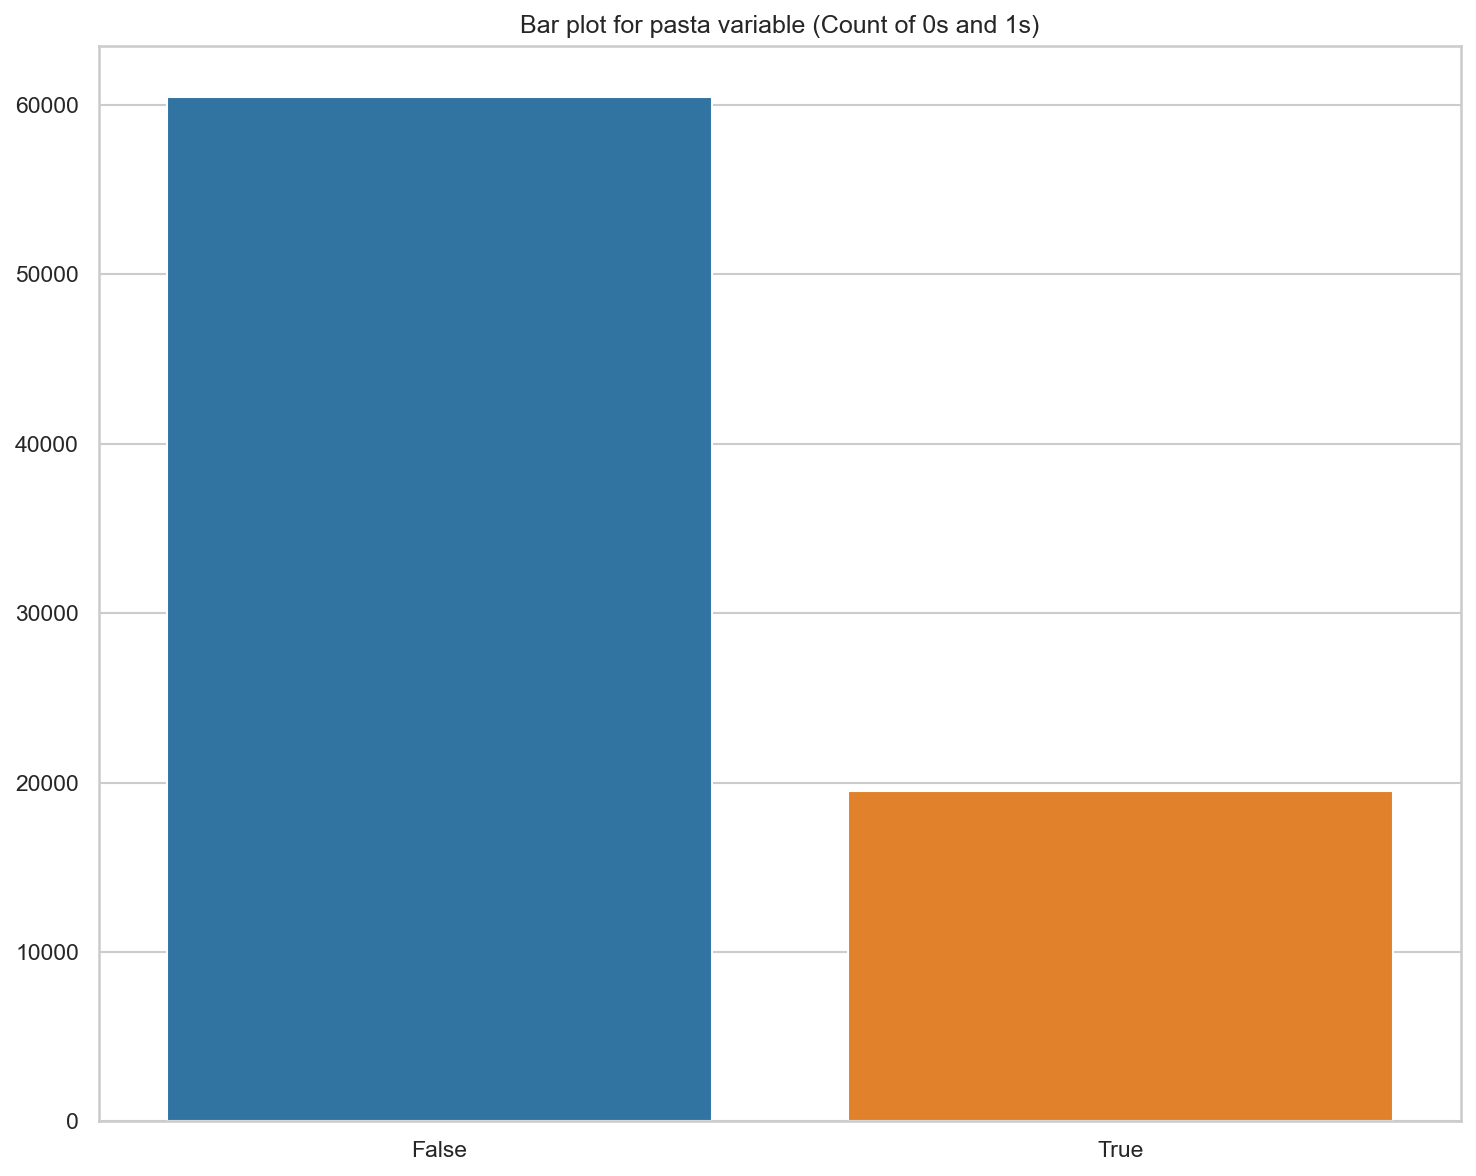

None


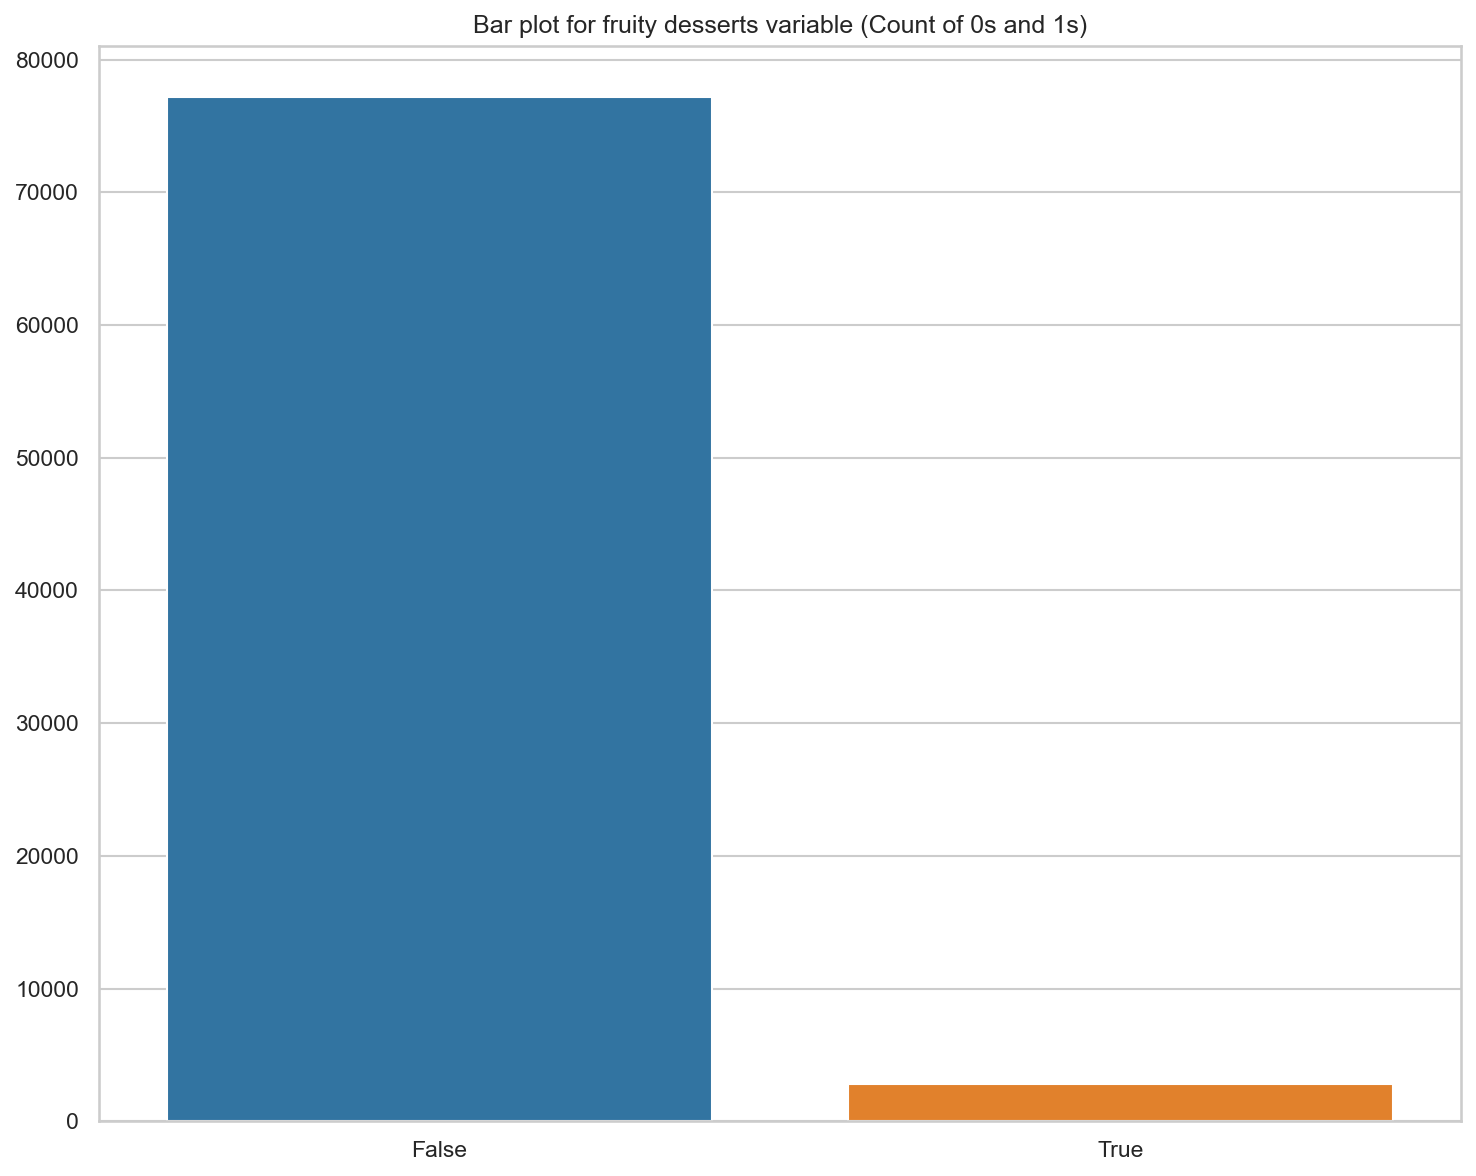

None


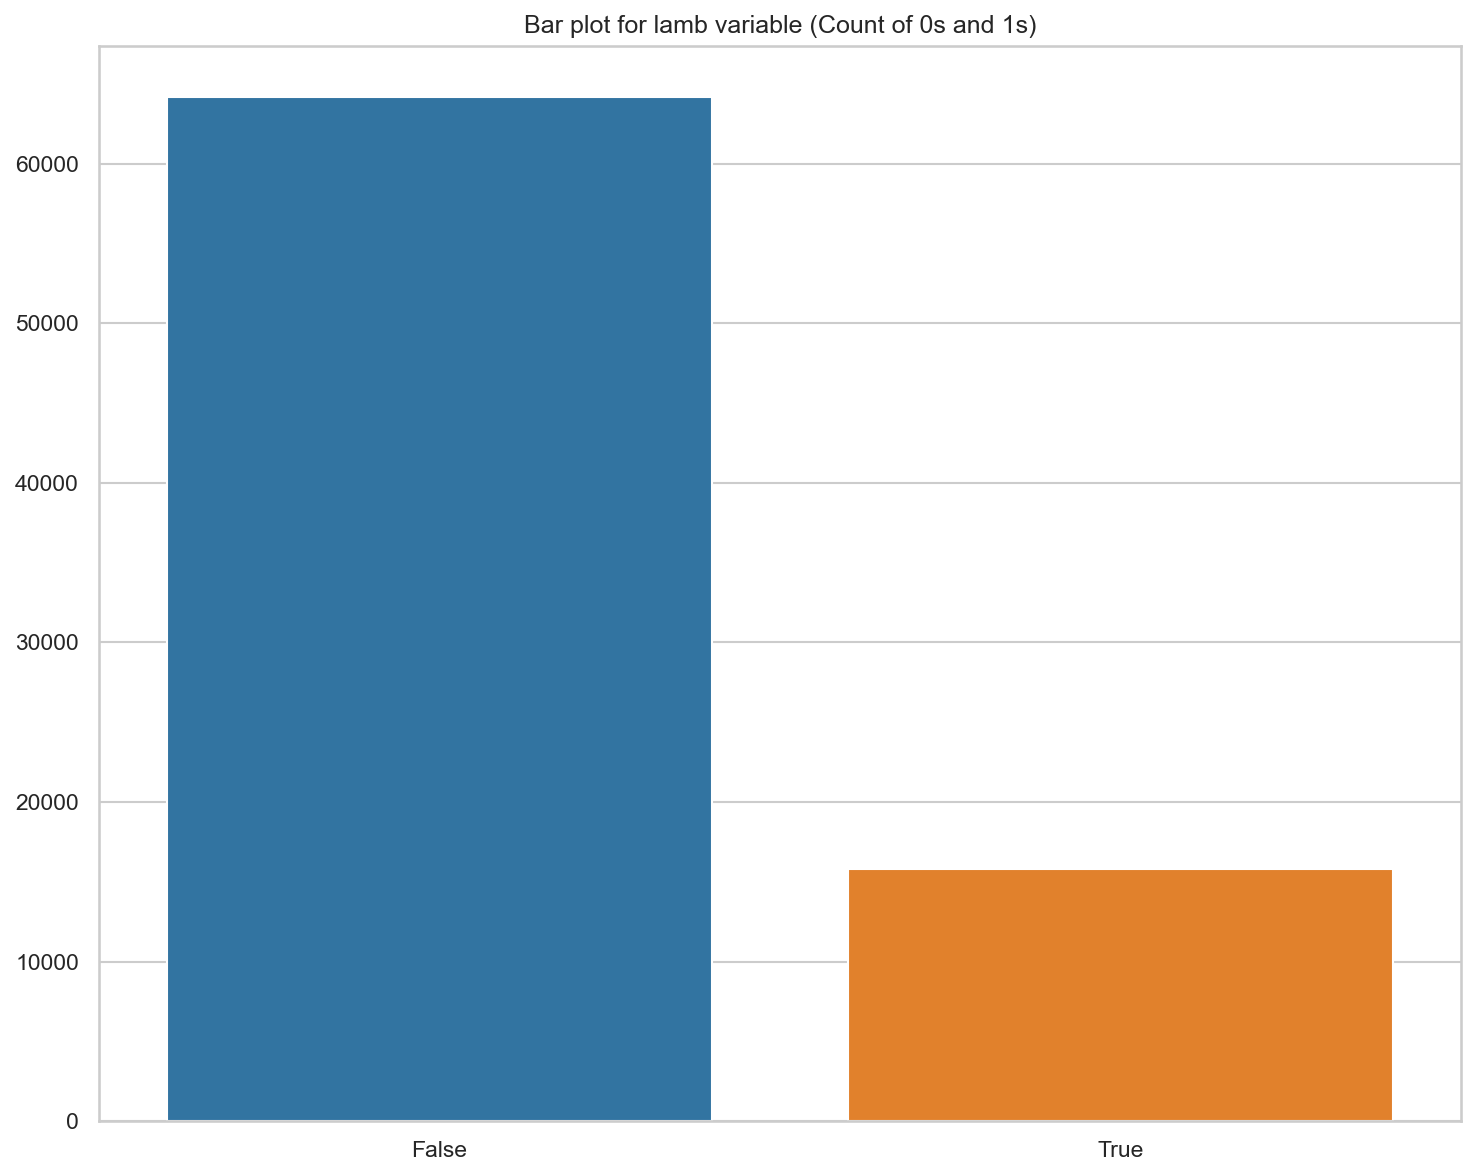

None


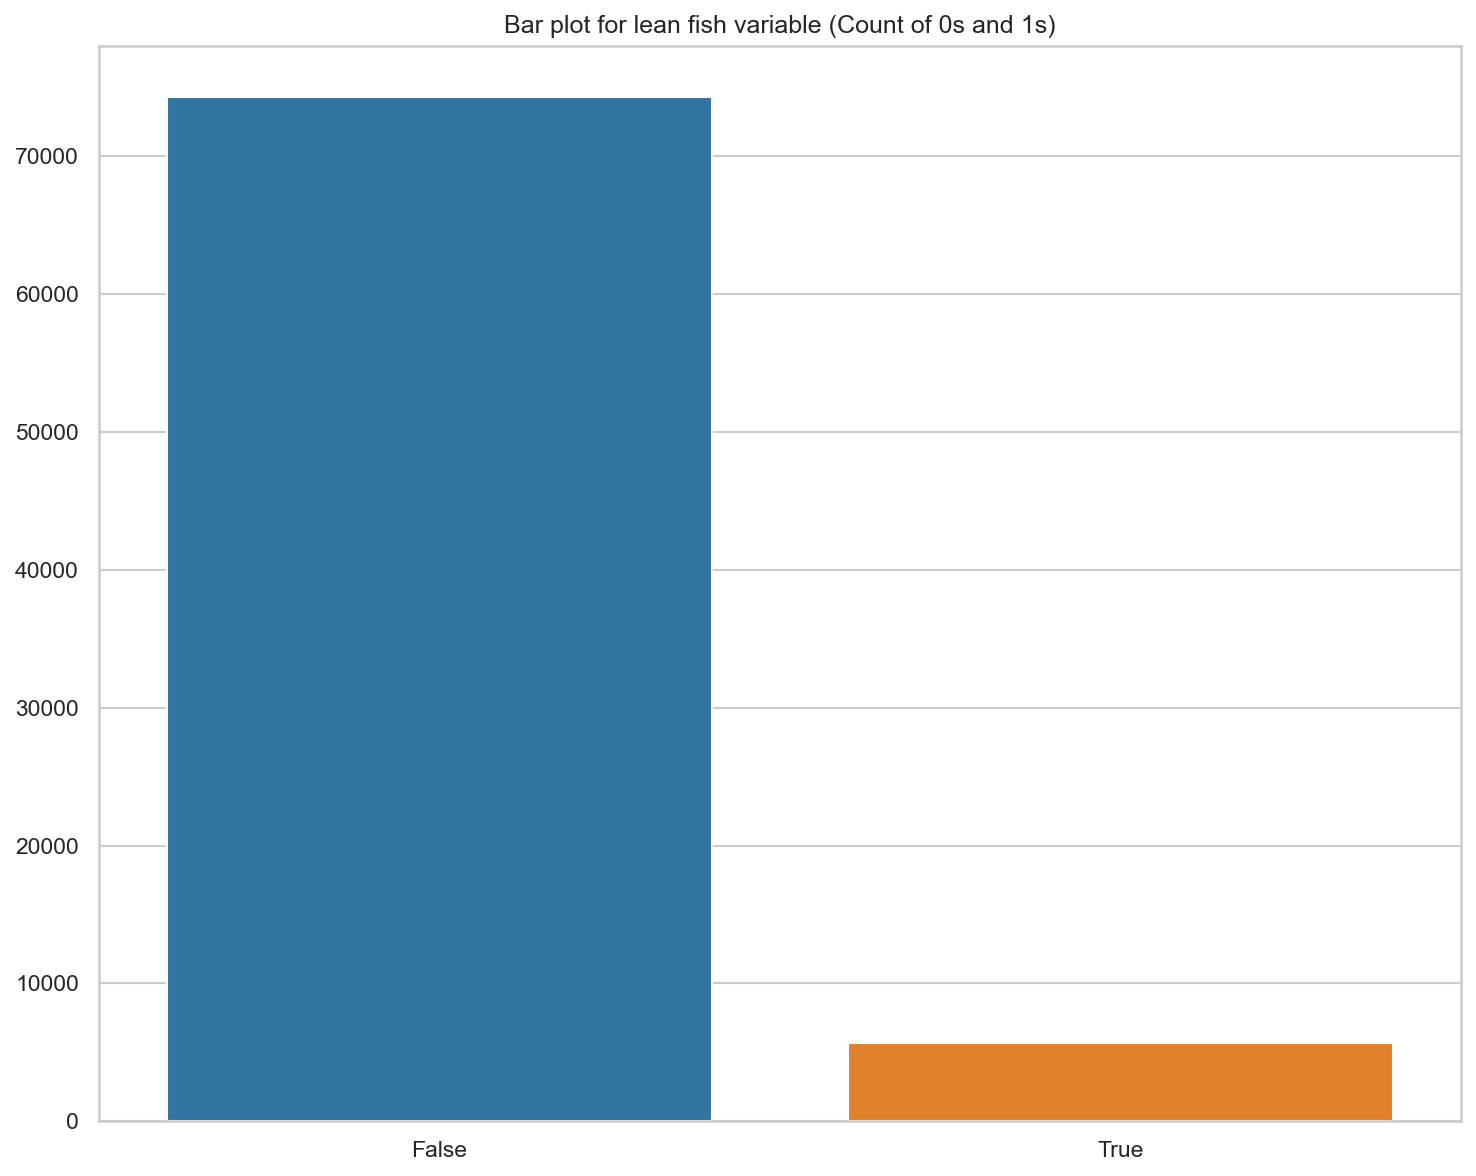

None


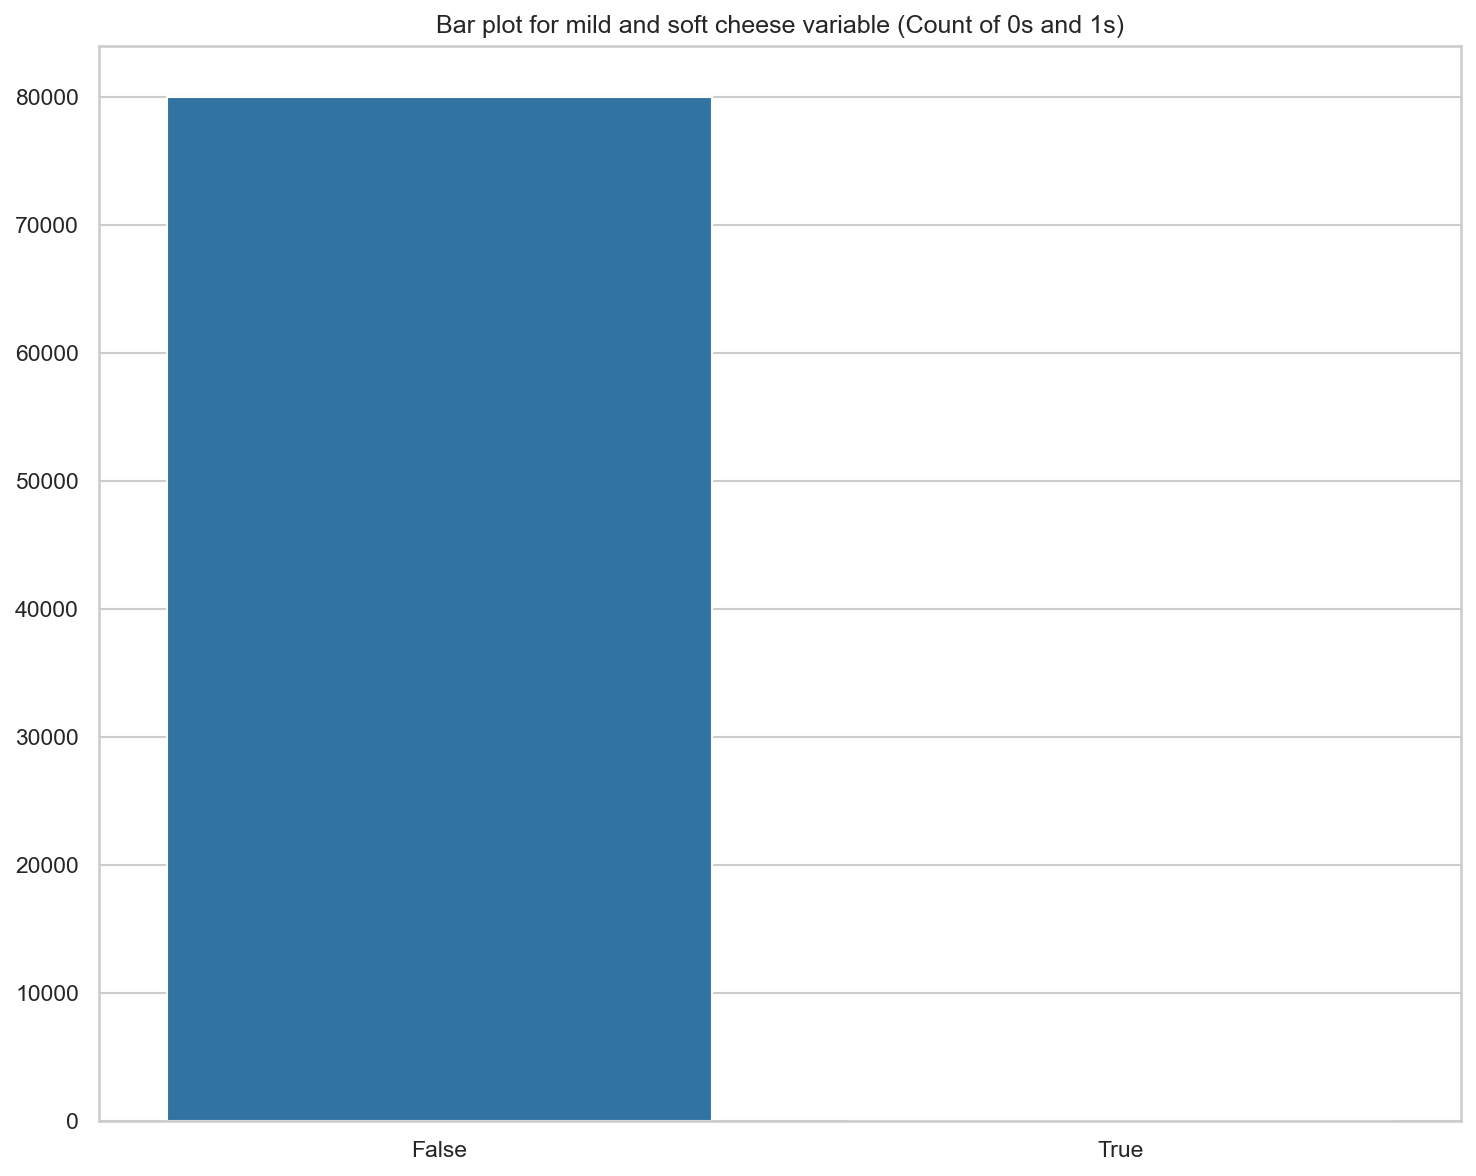

None


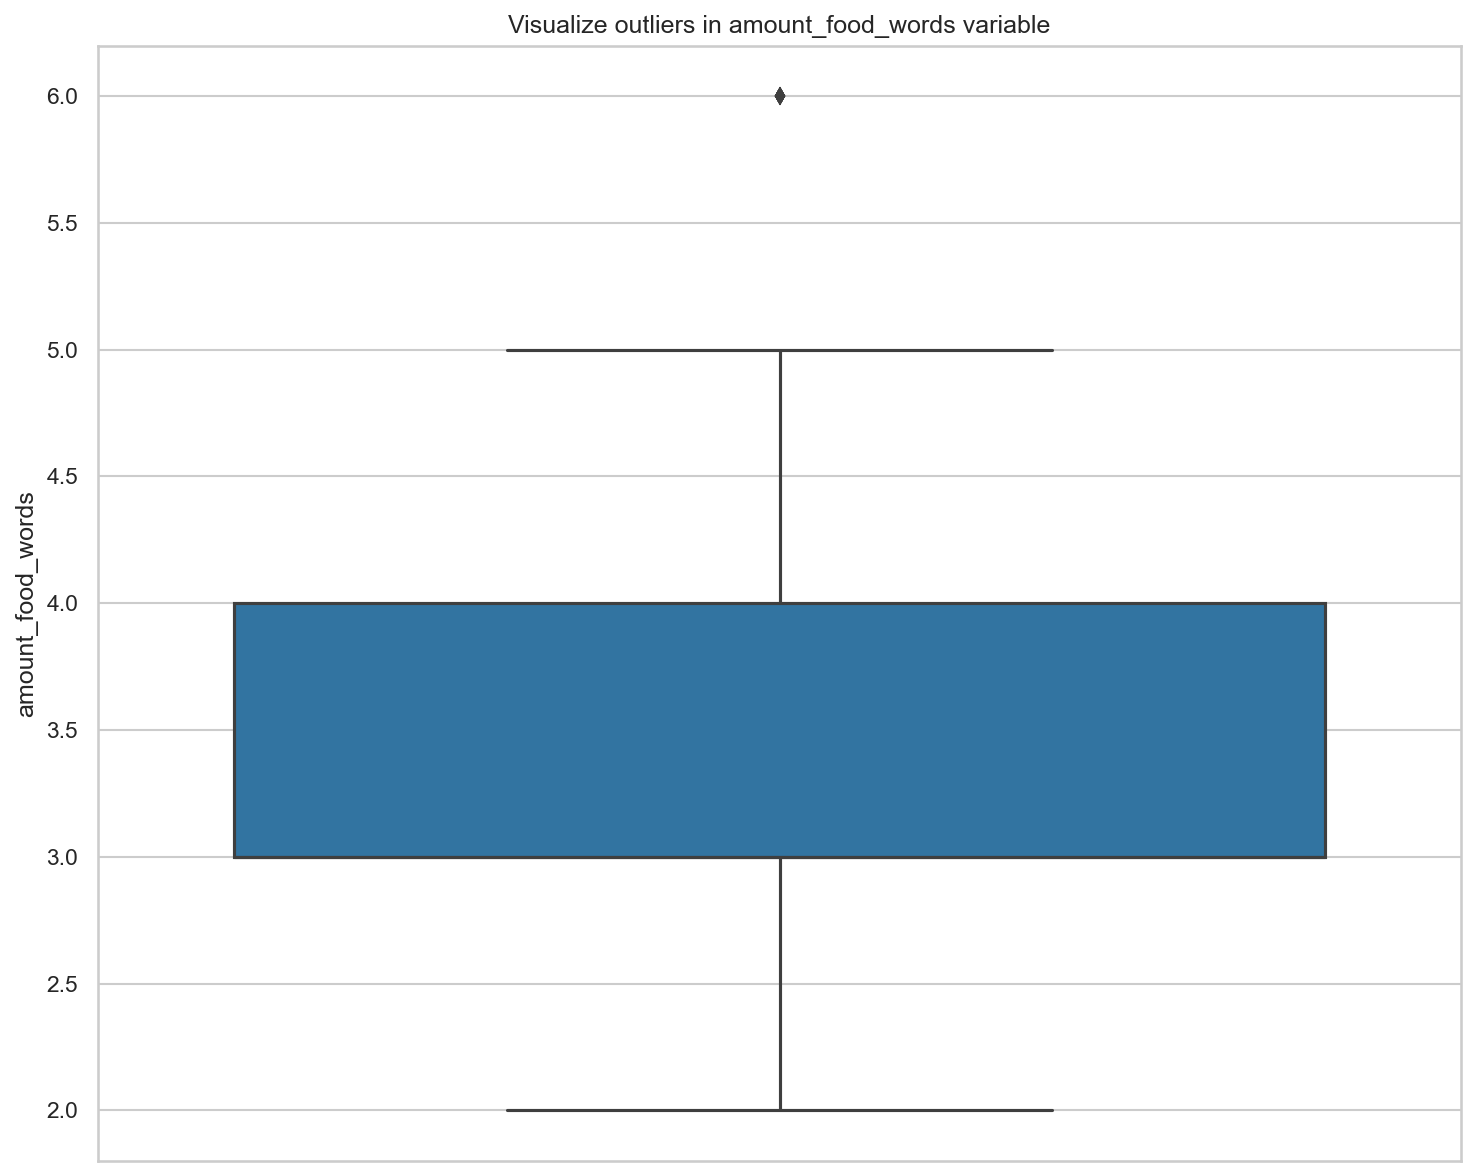

None


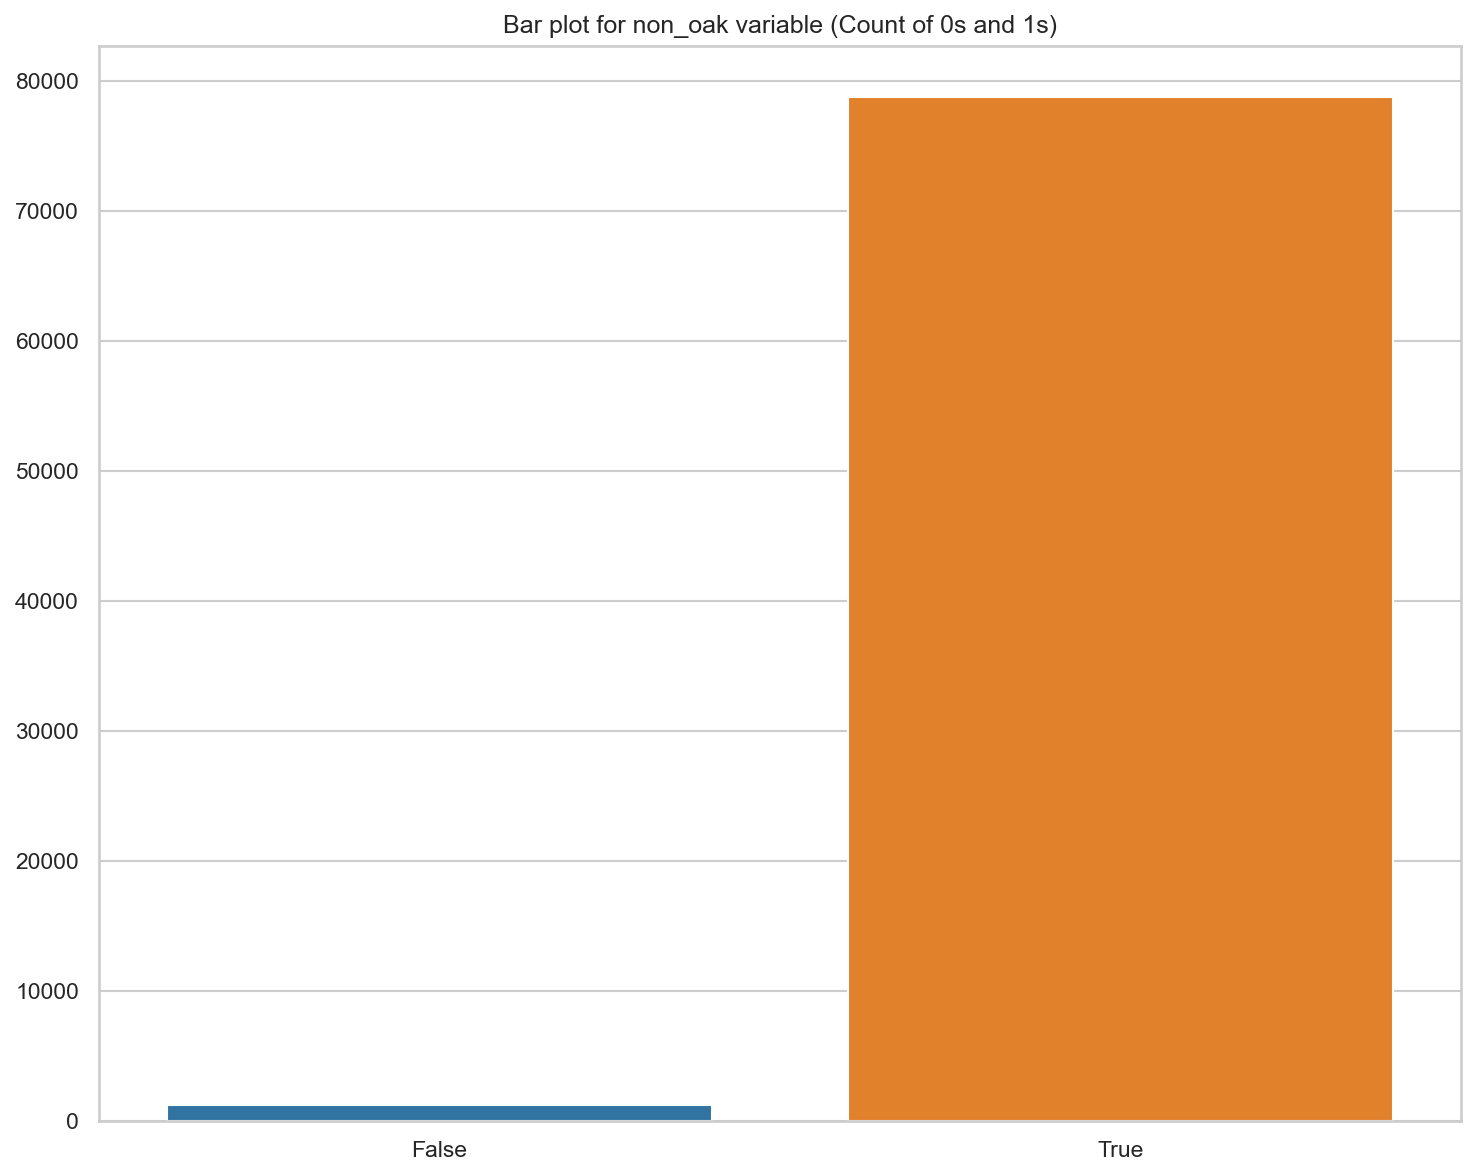

None


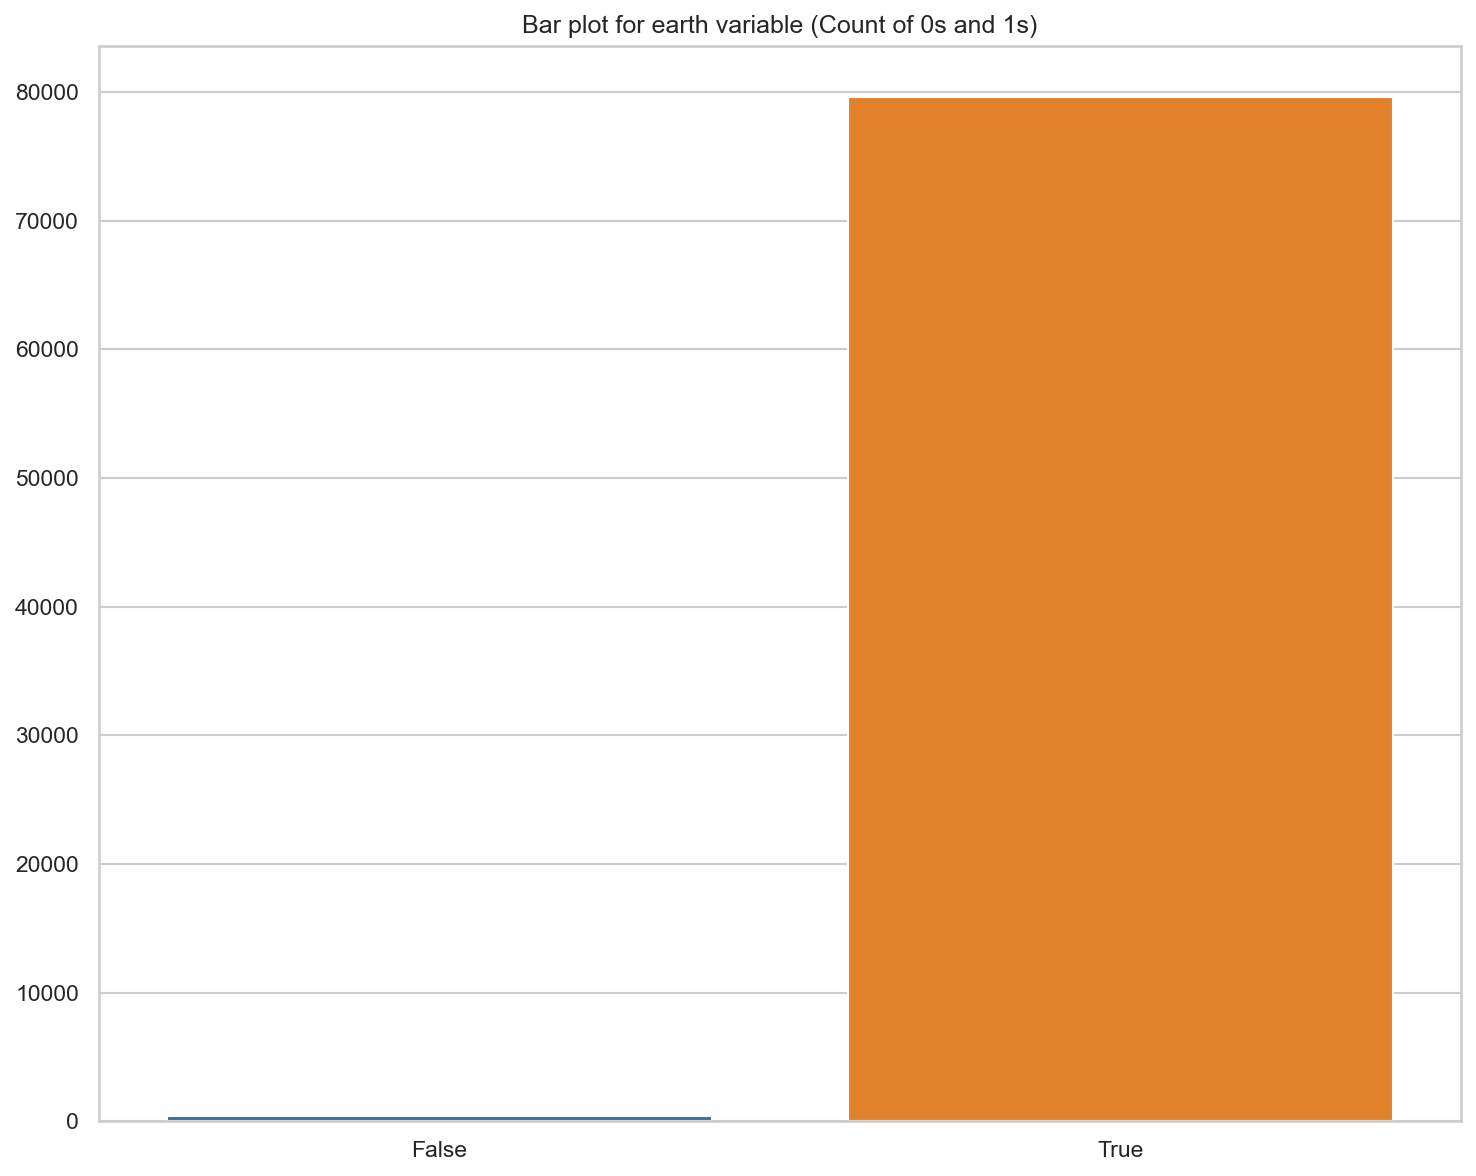

None


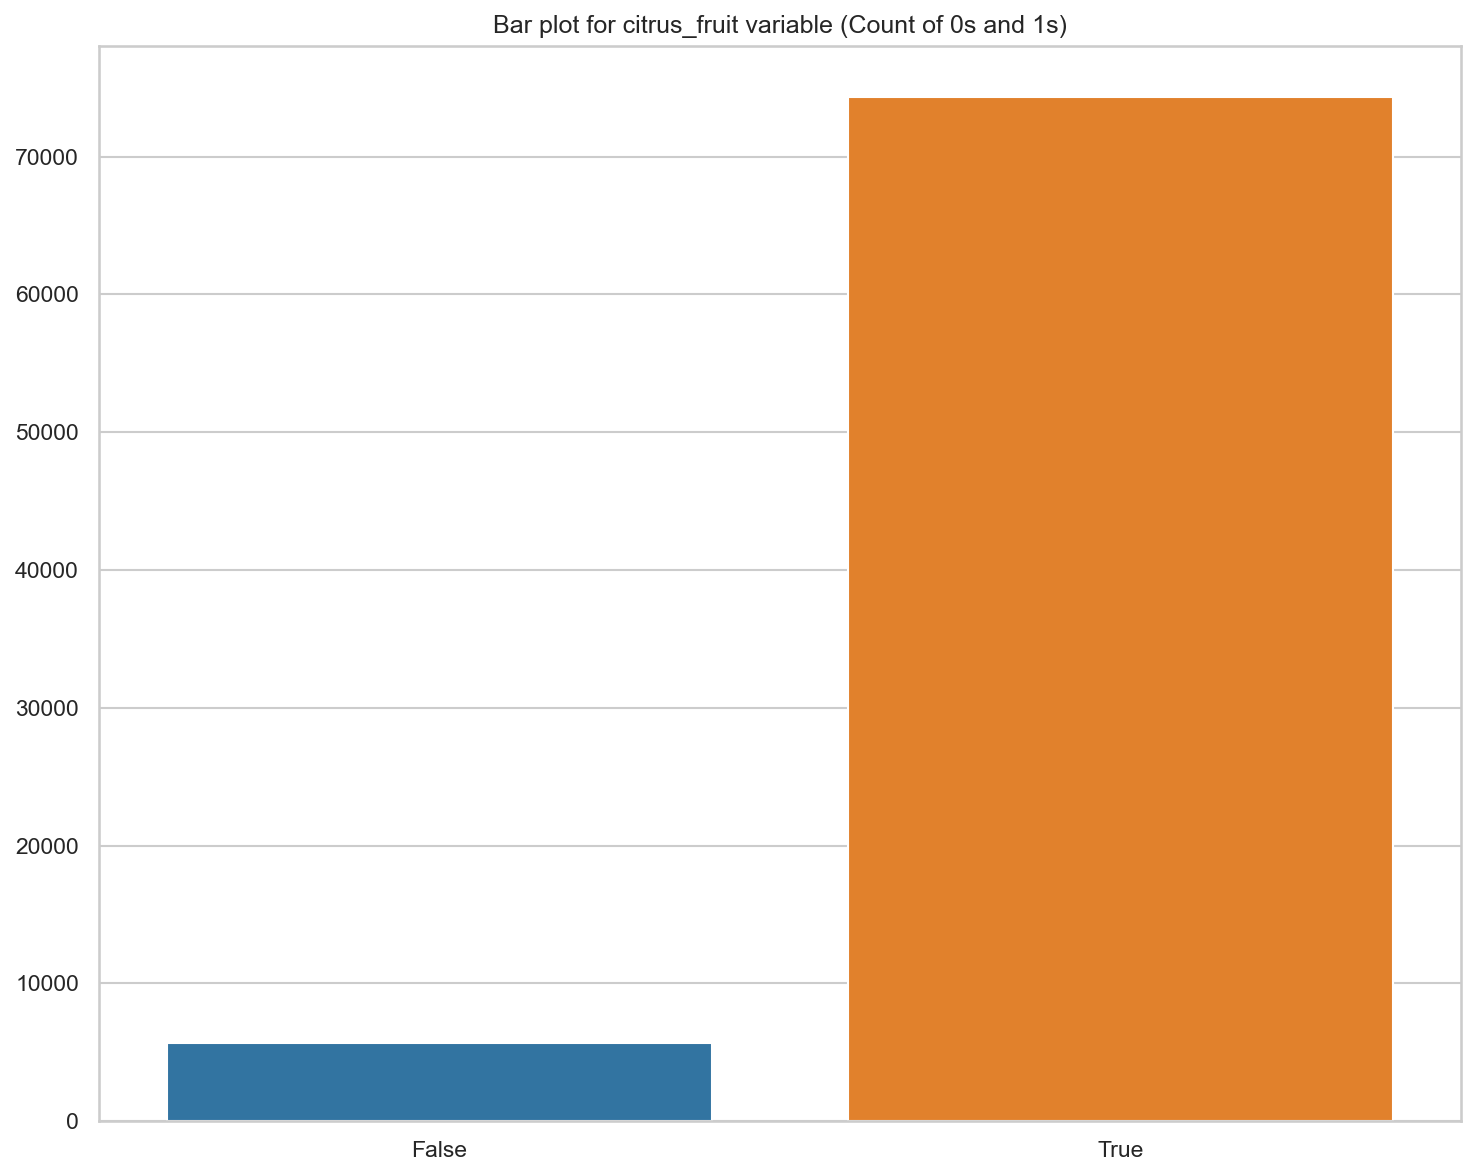

None


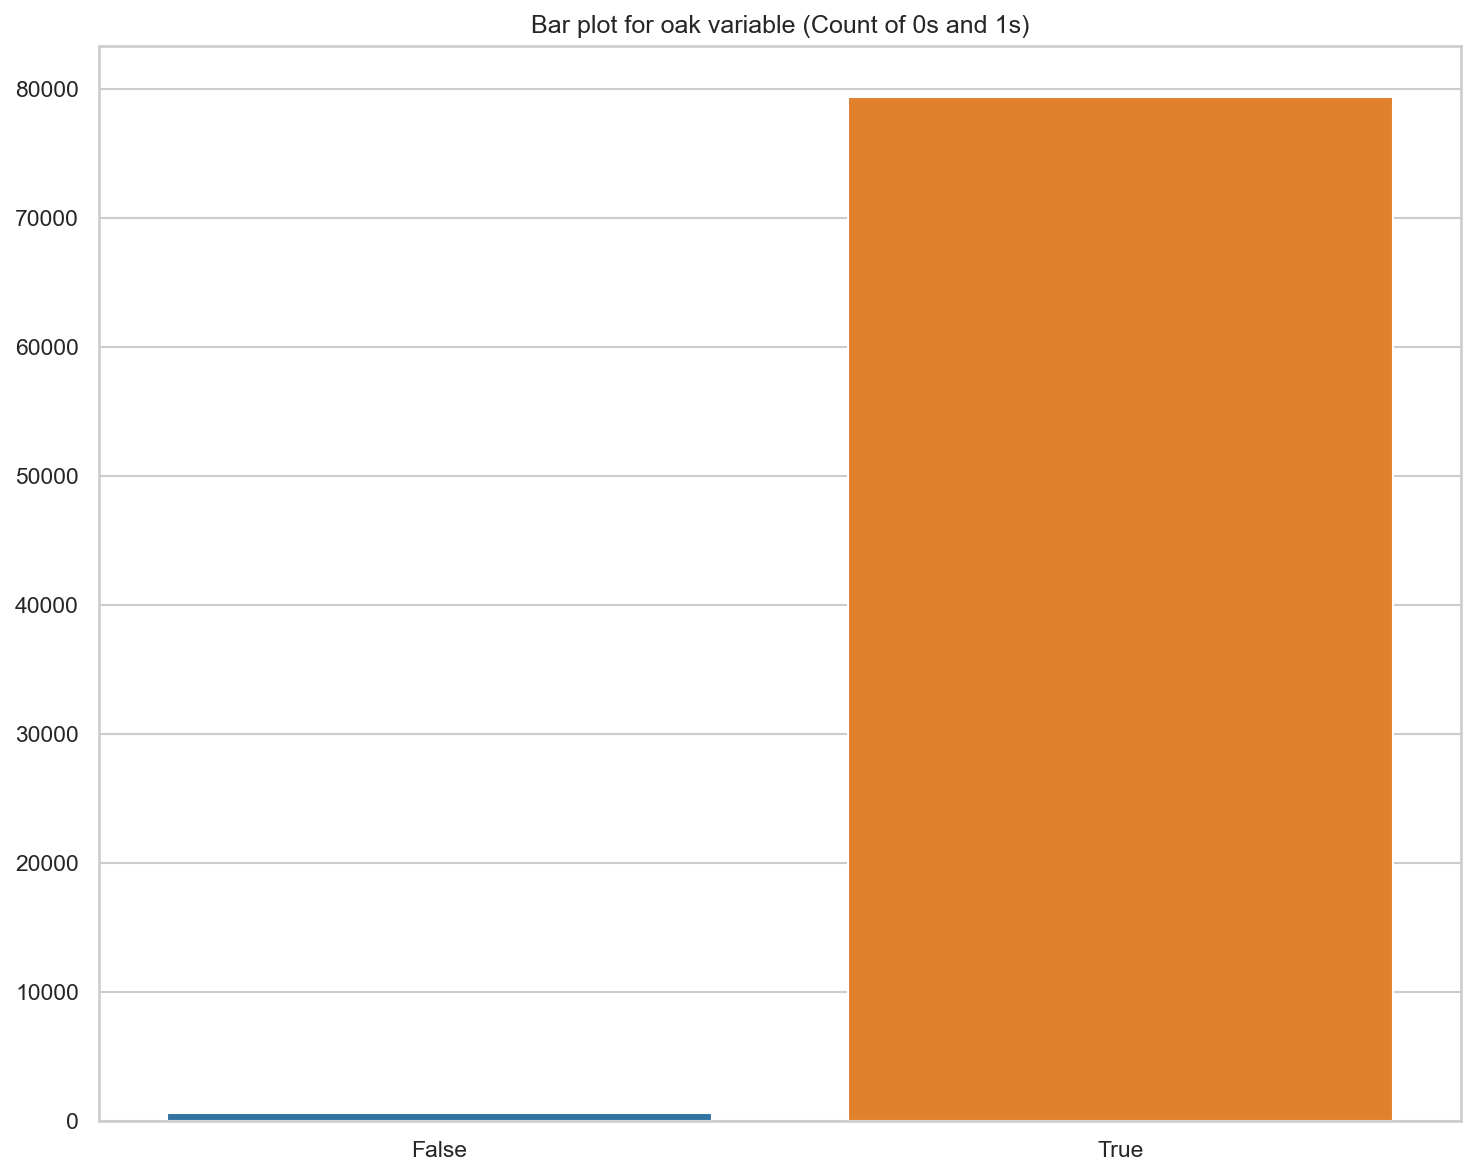

None


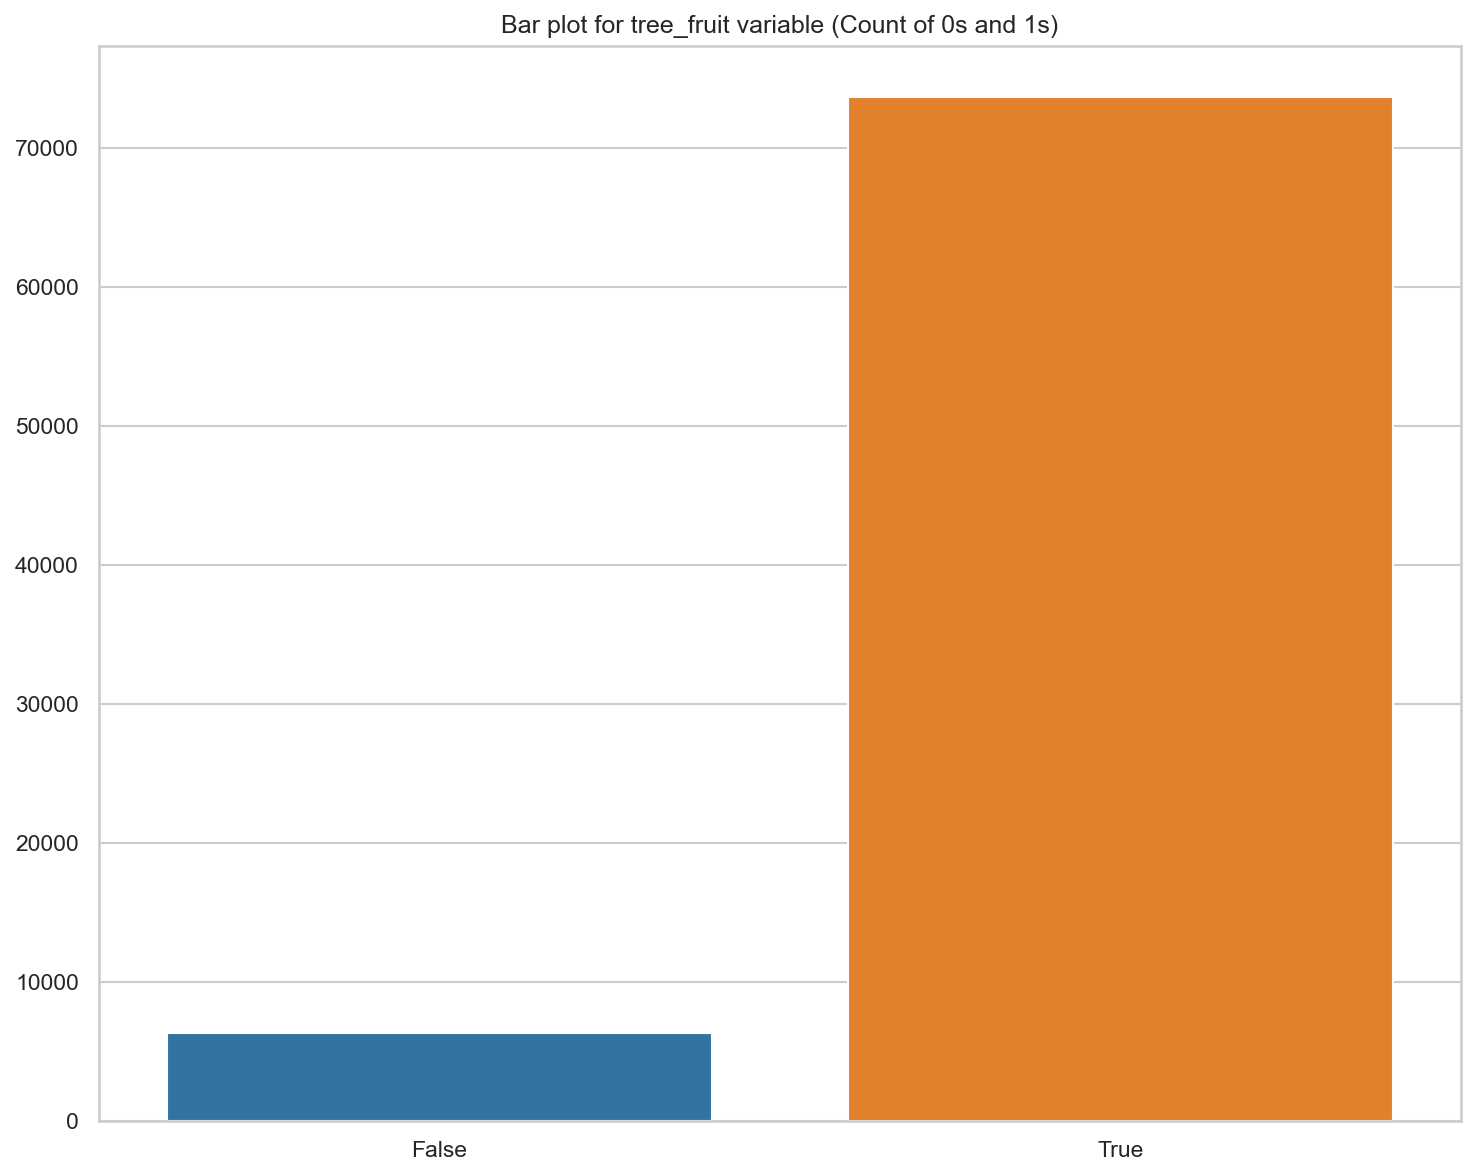

None


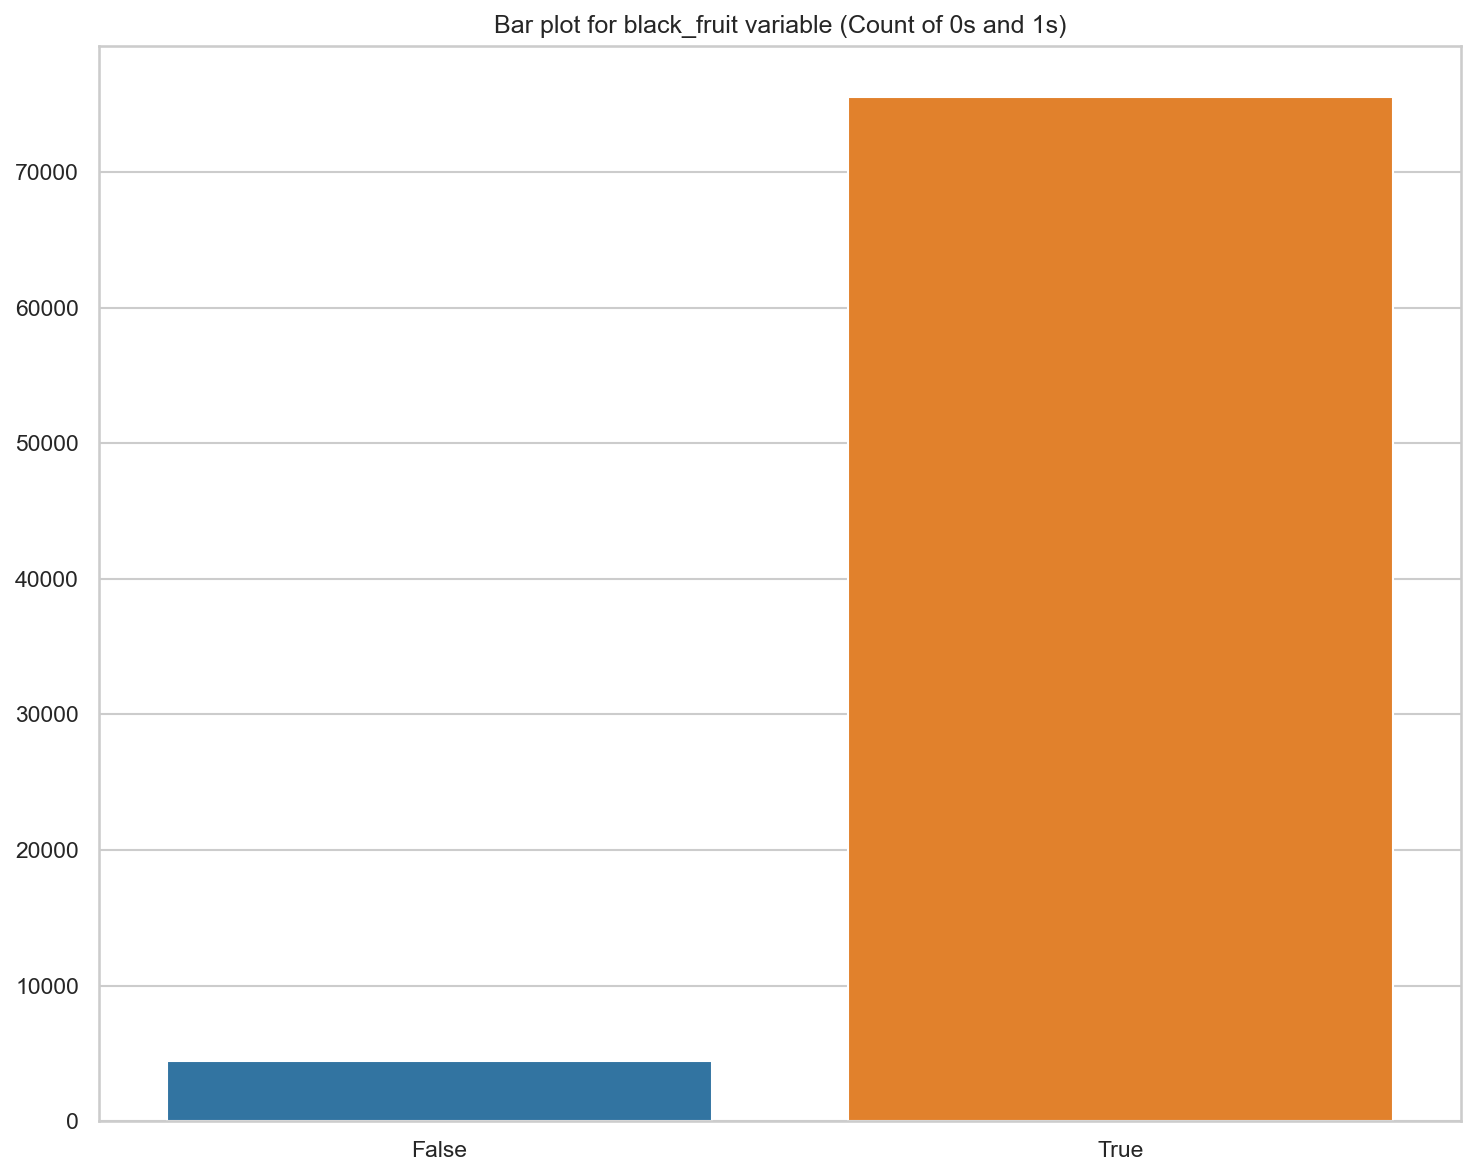

None


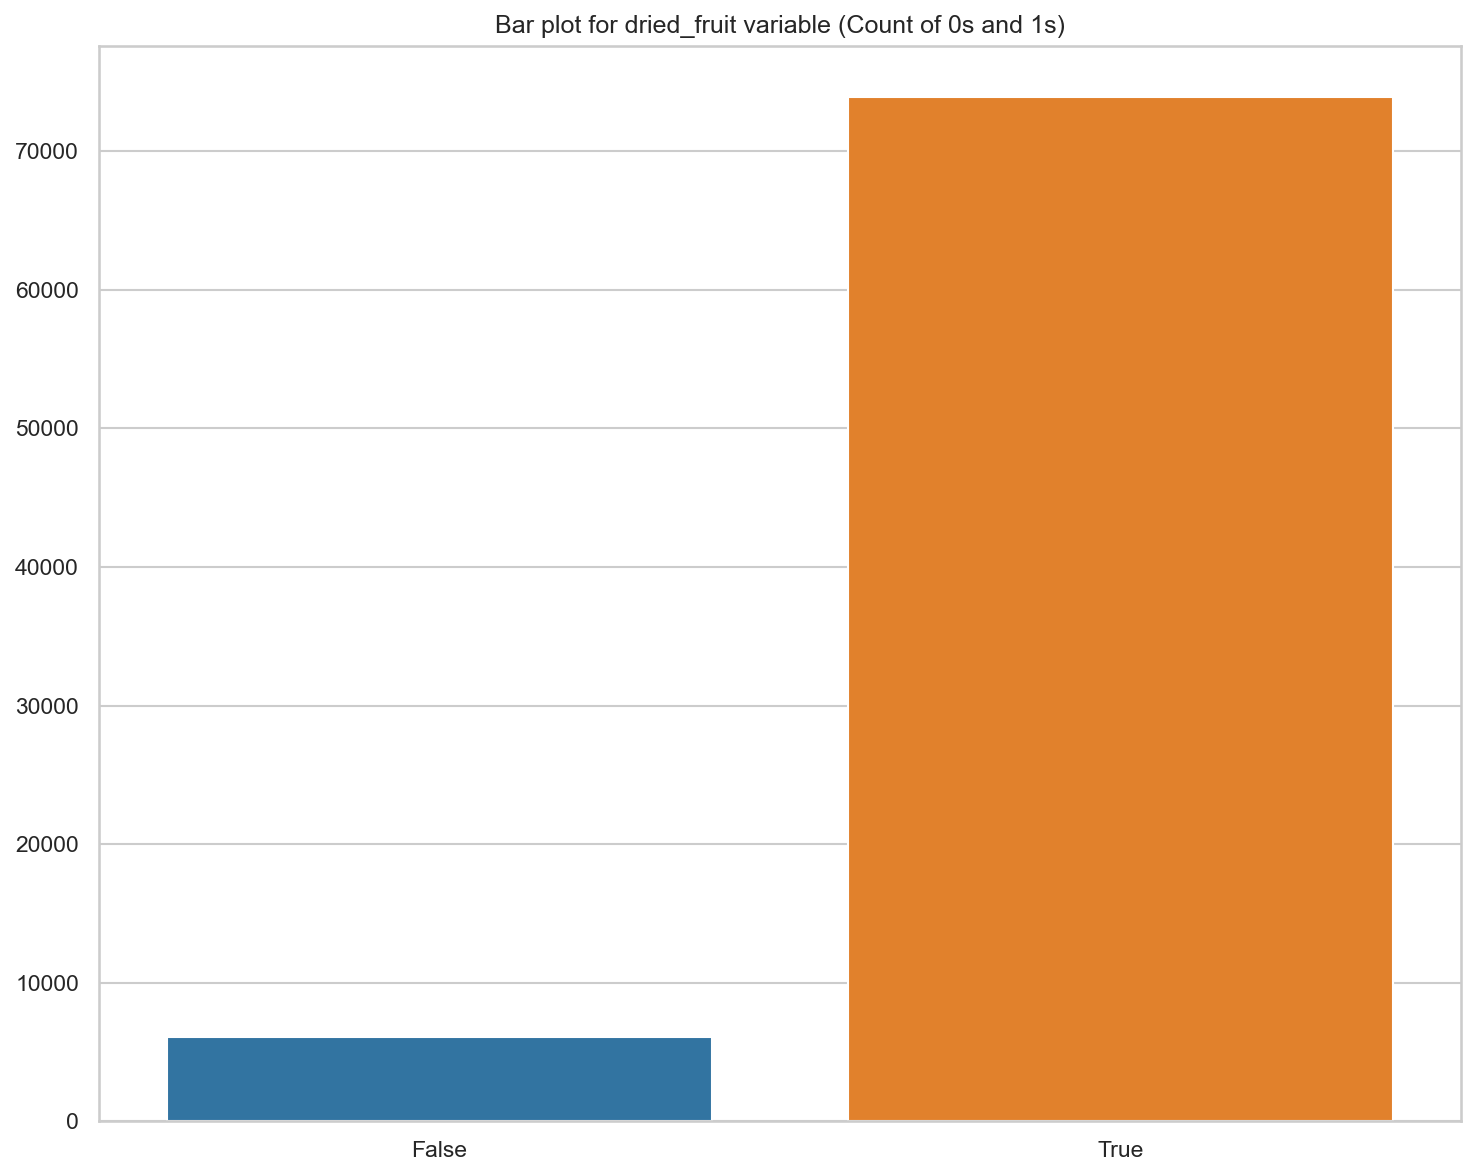

None


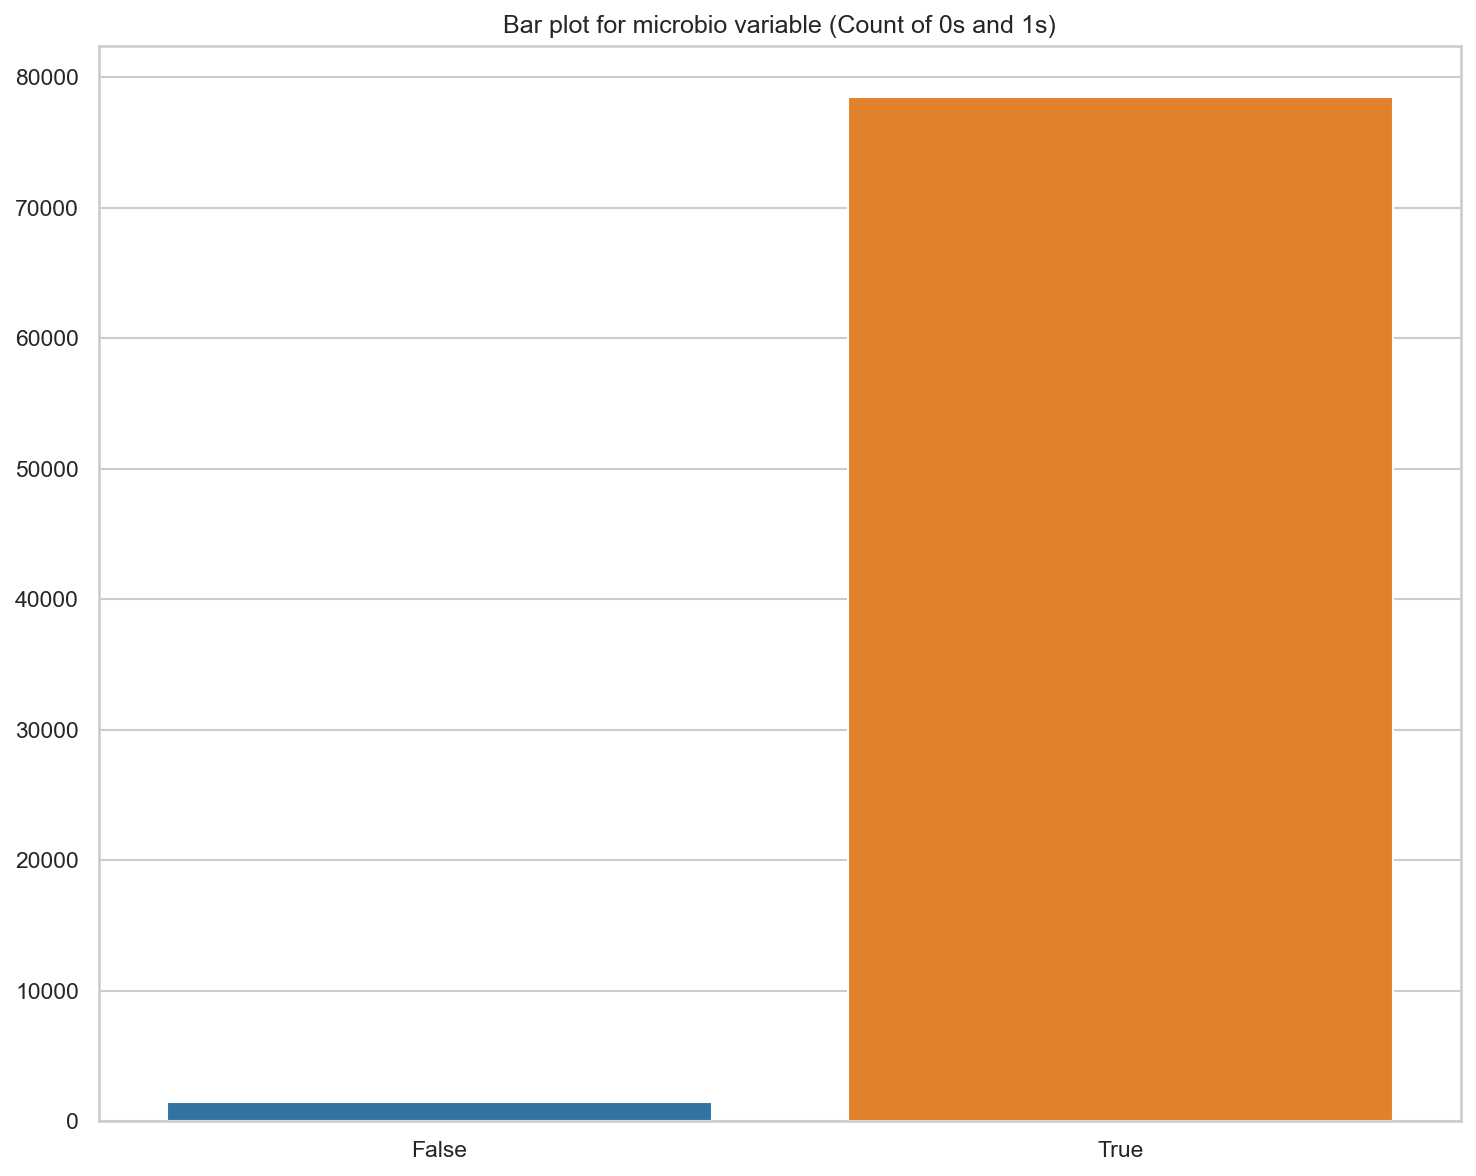

None


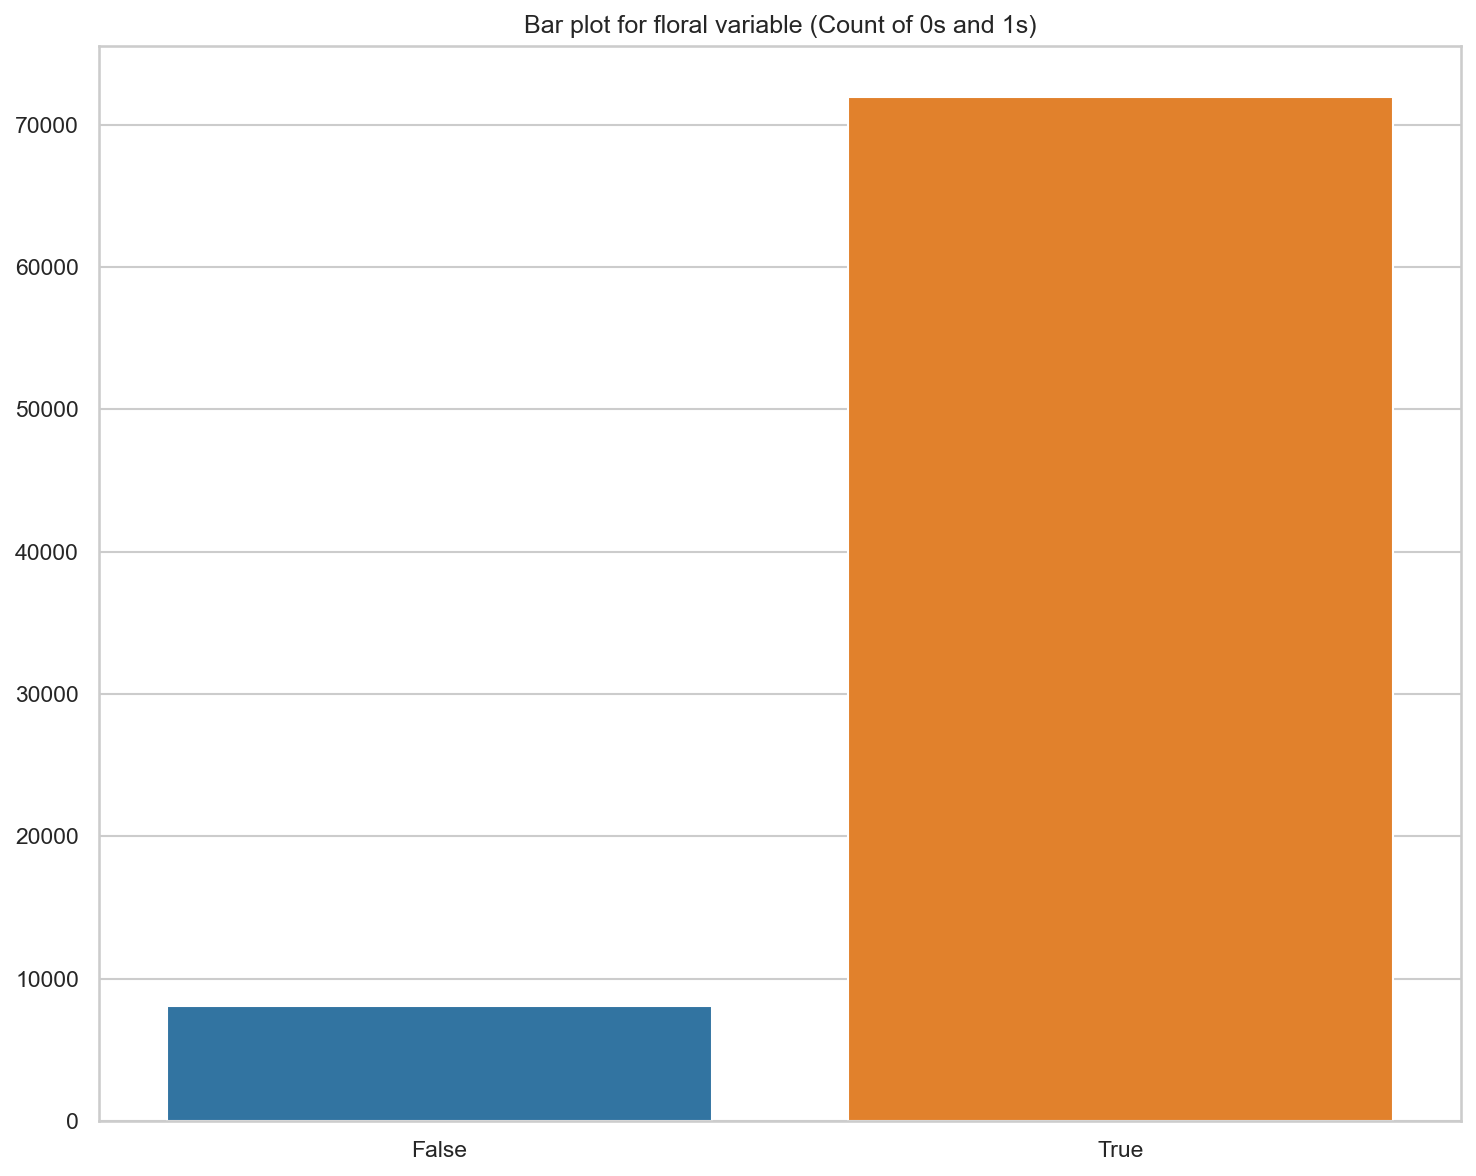

None


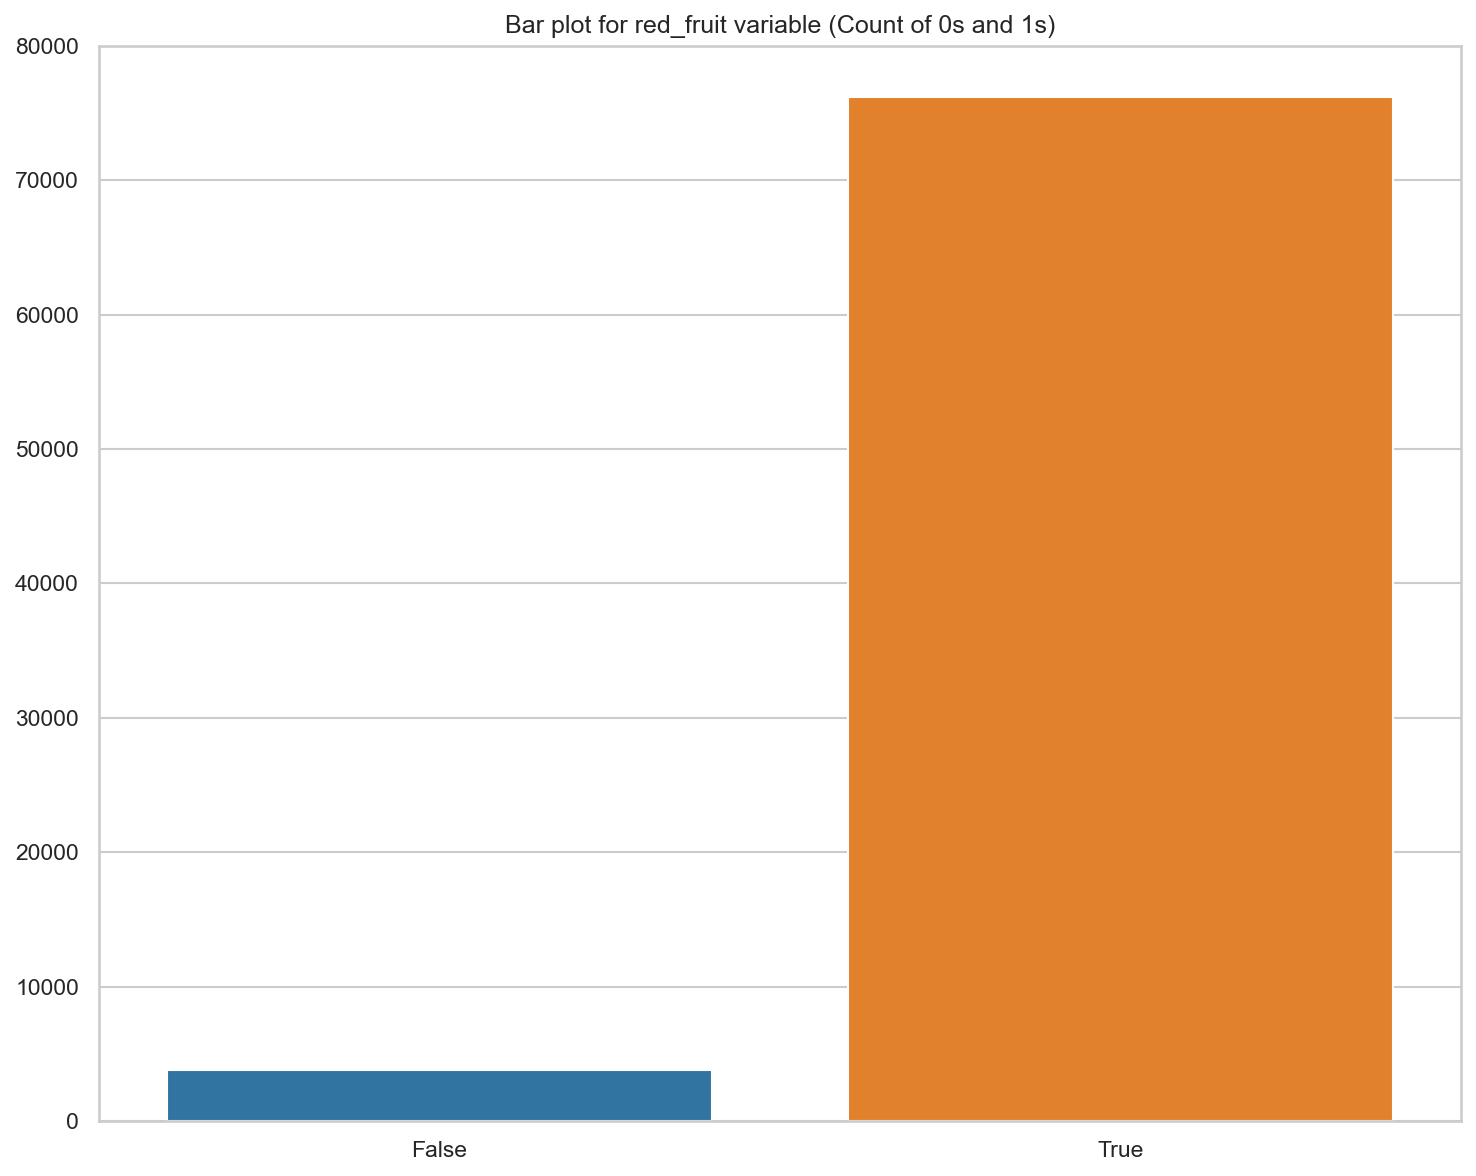

None


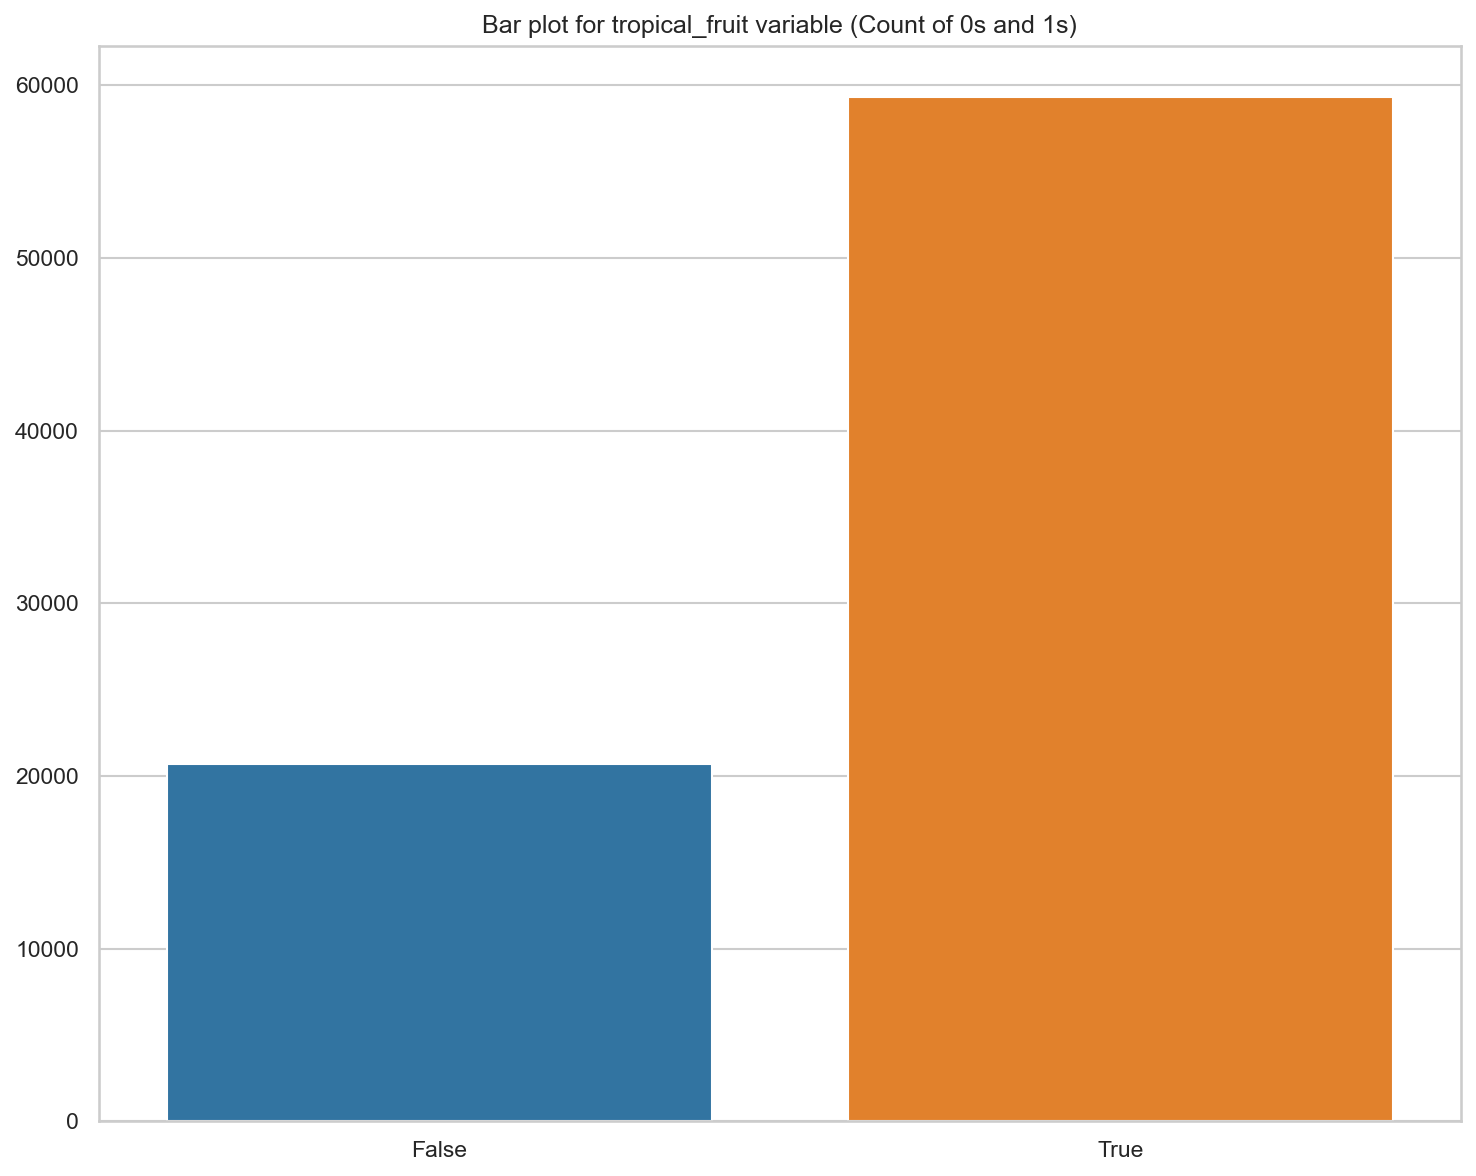

None


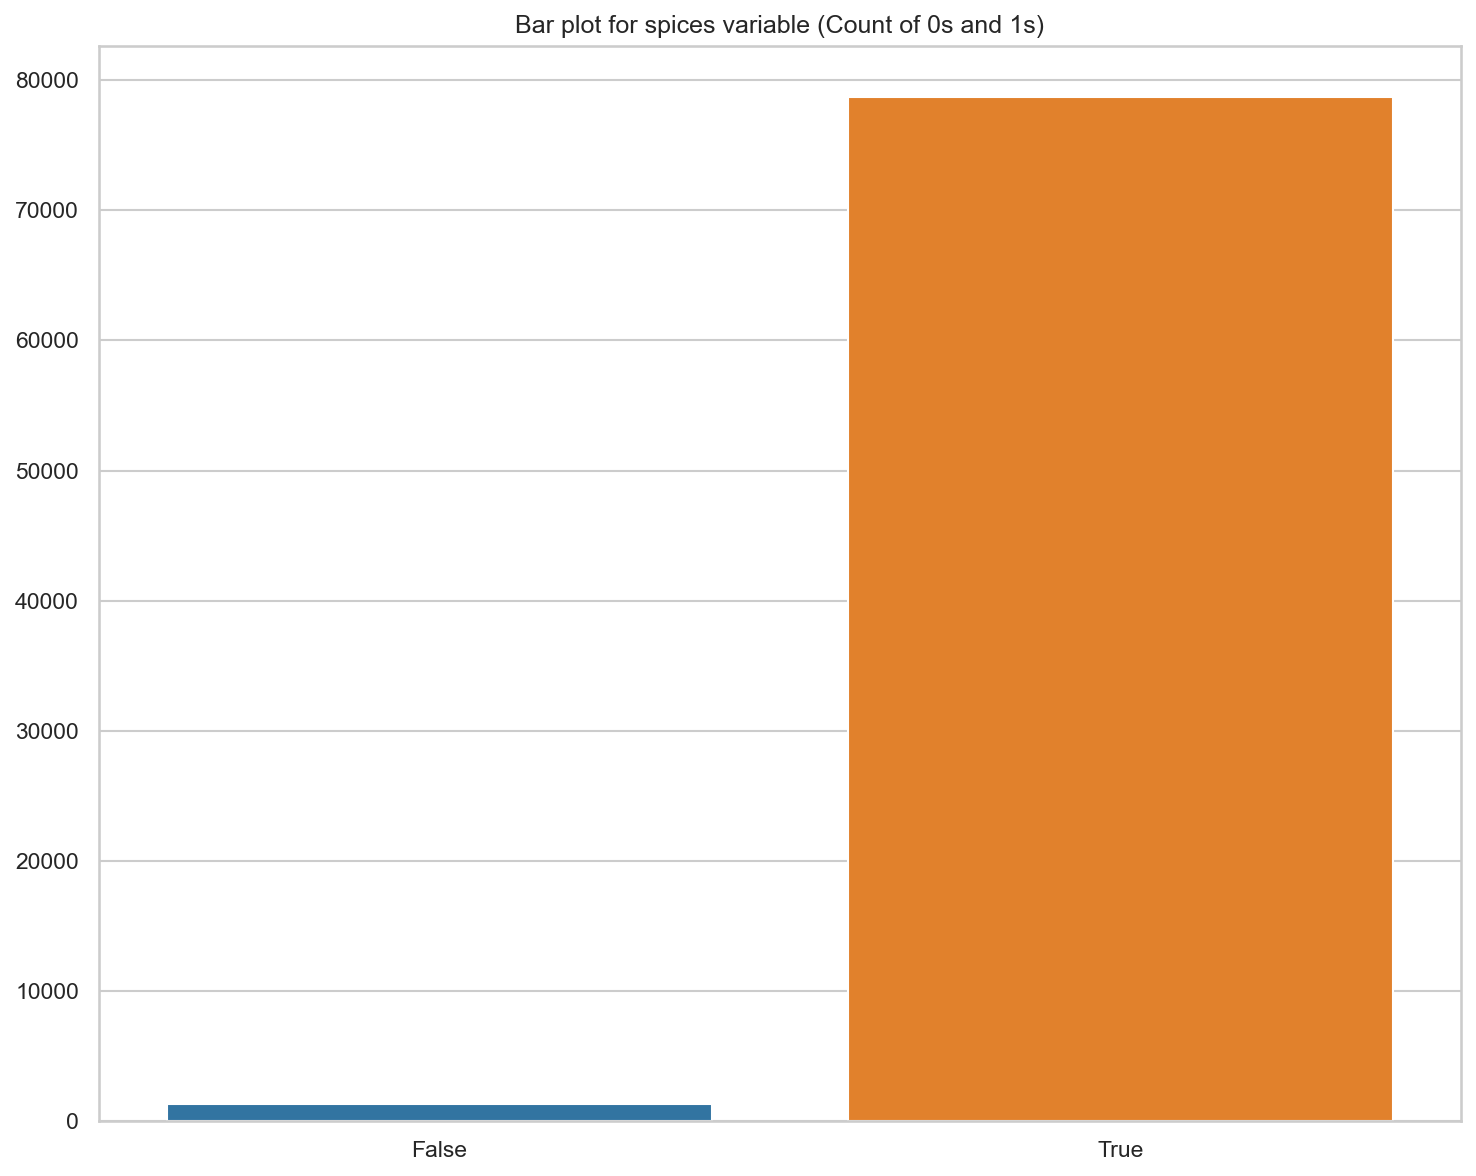

None


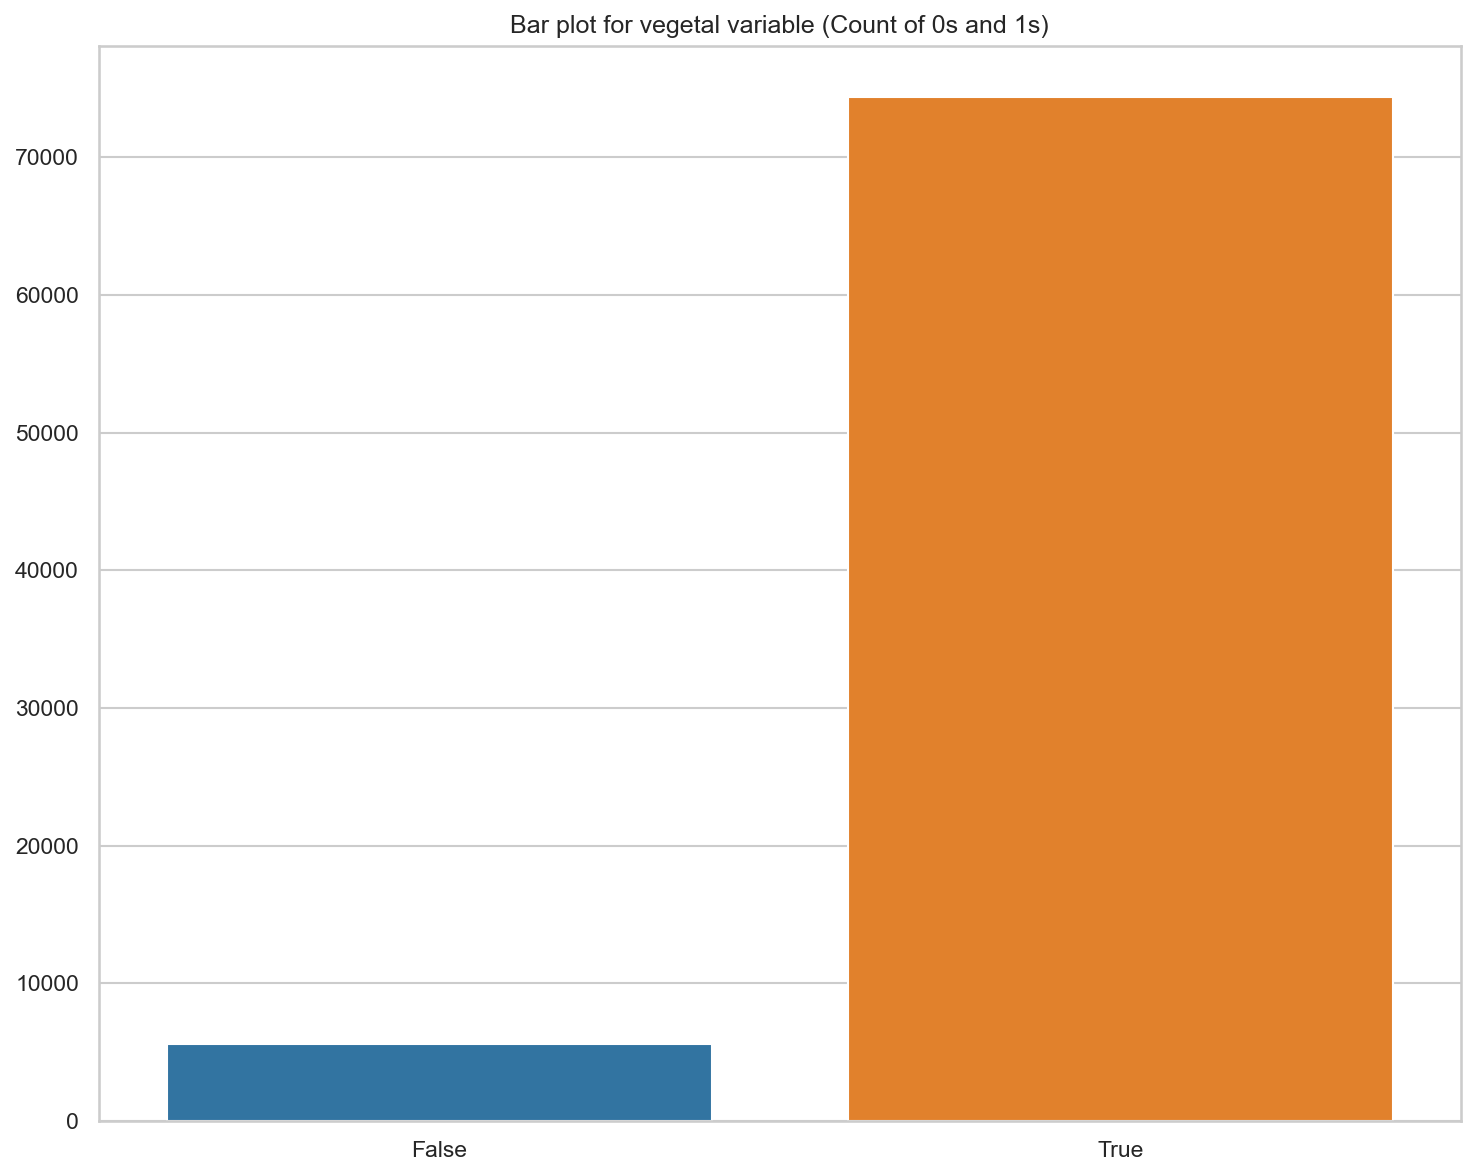

None


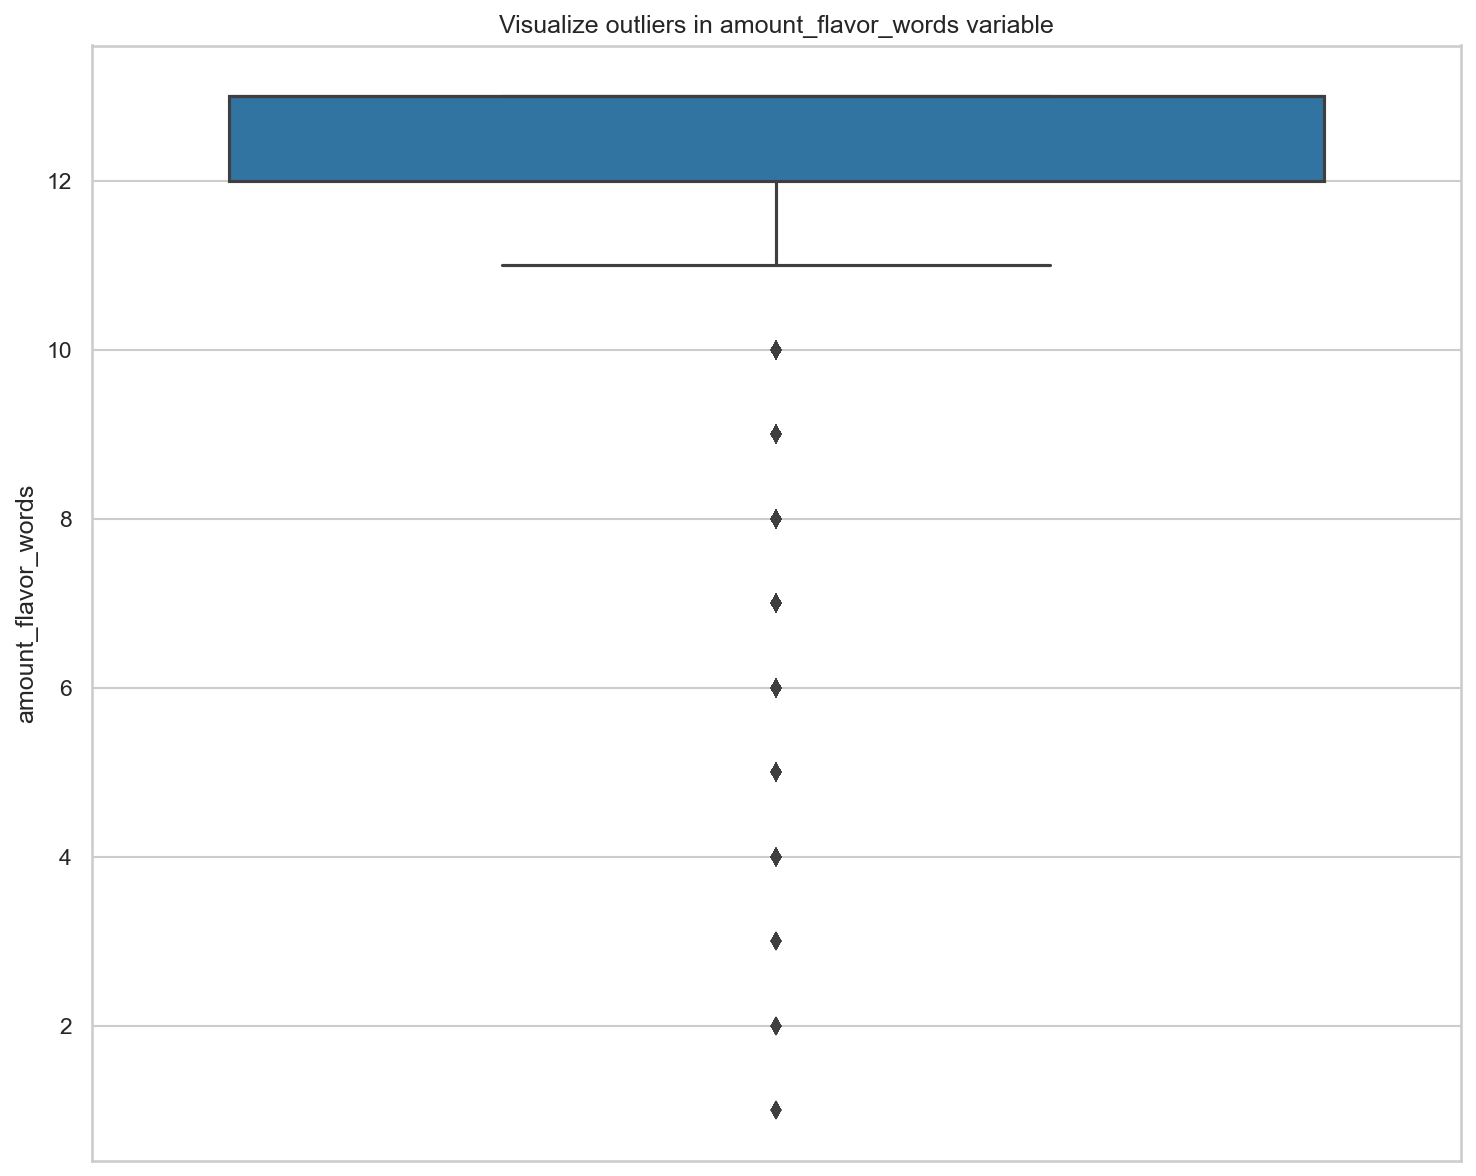

None


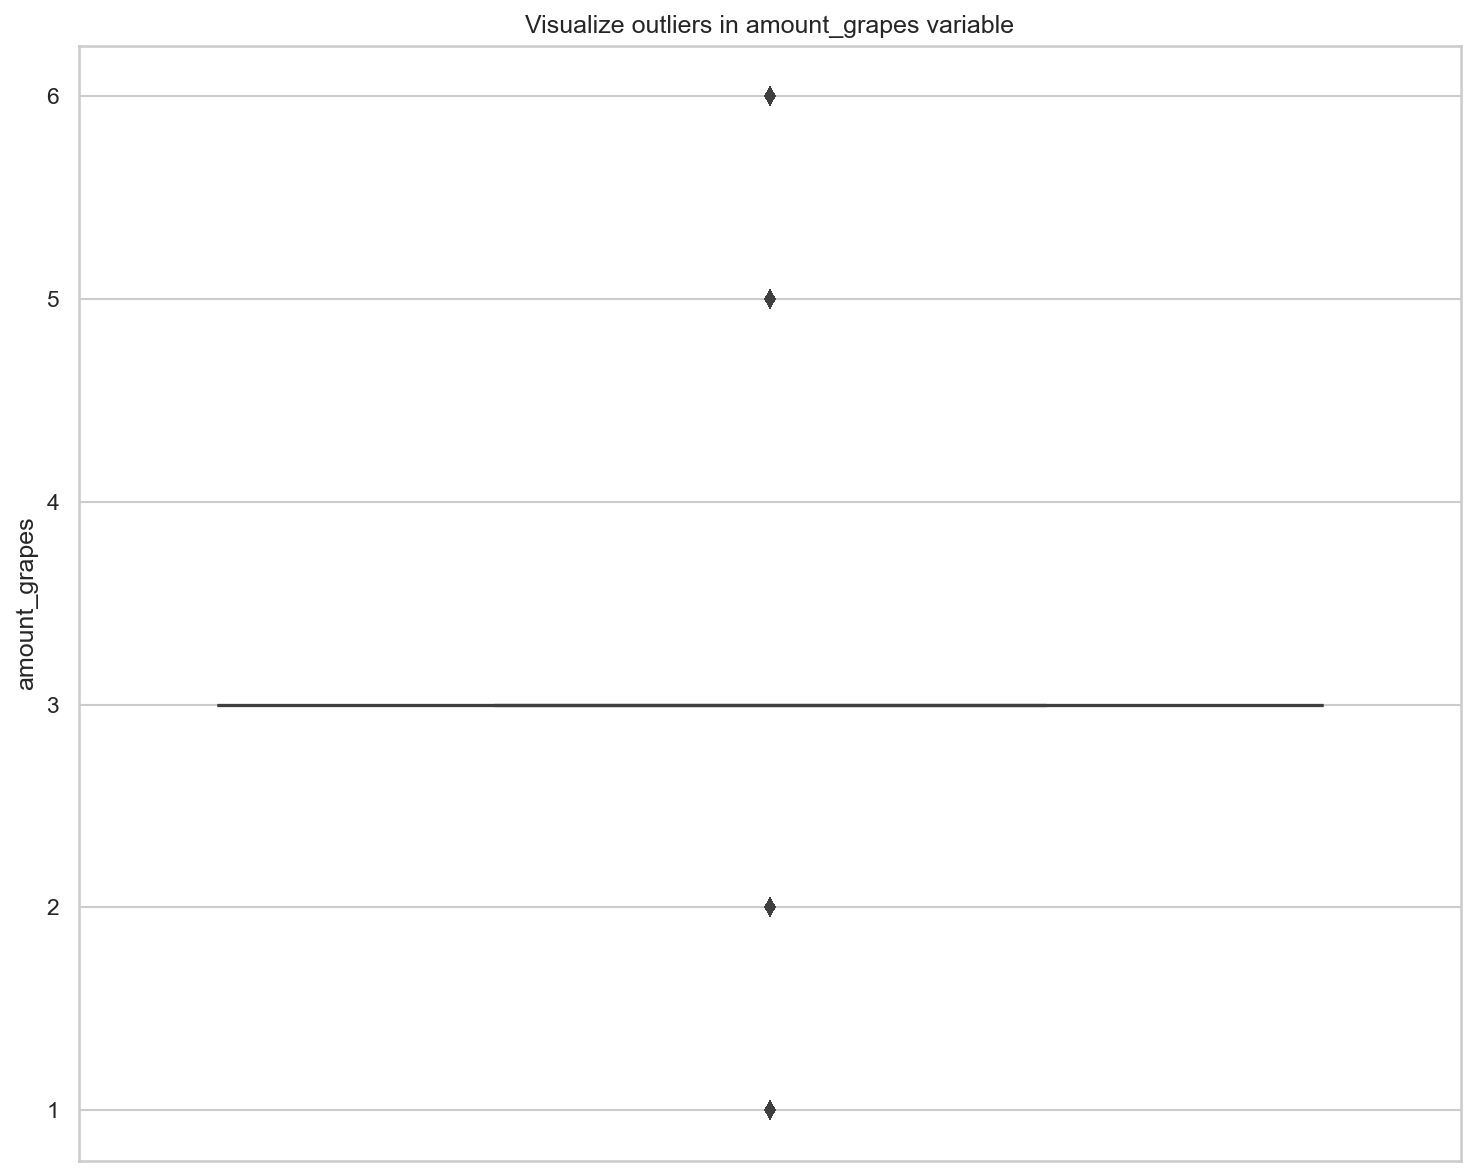

None


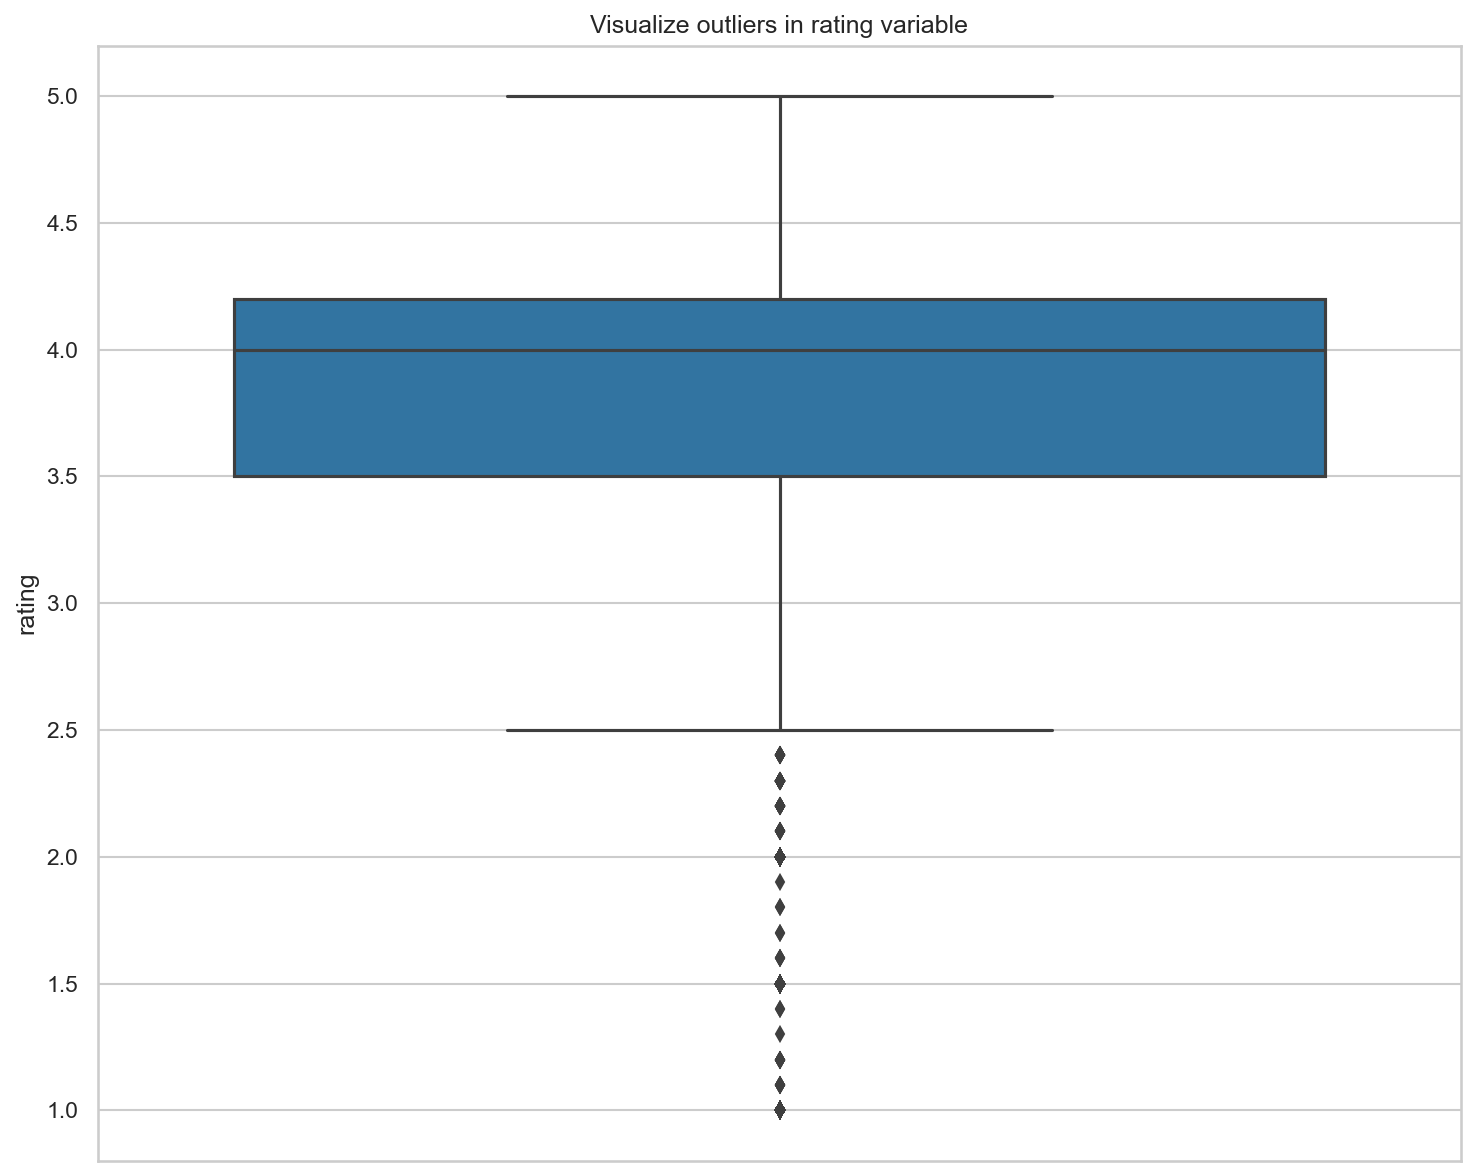

None


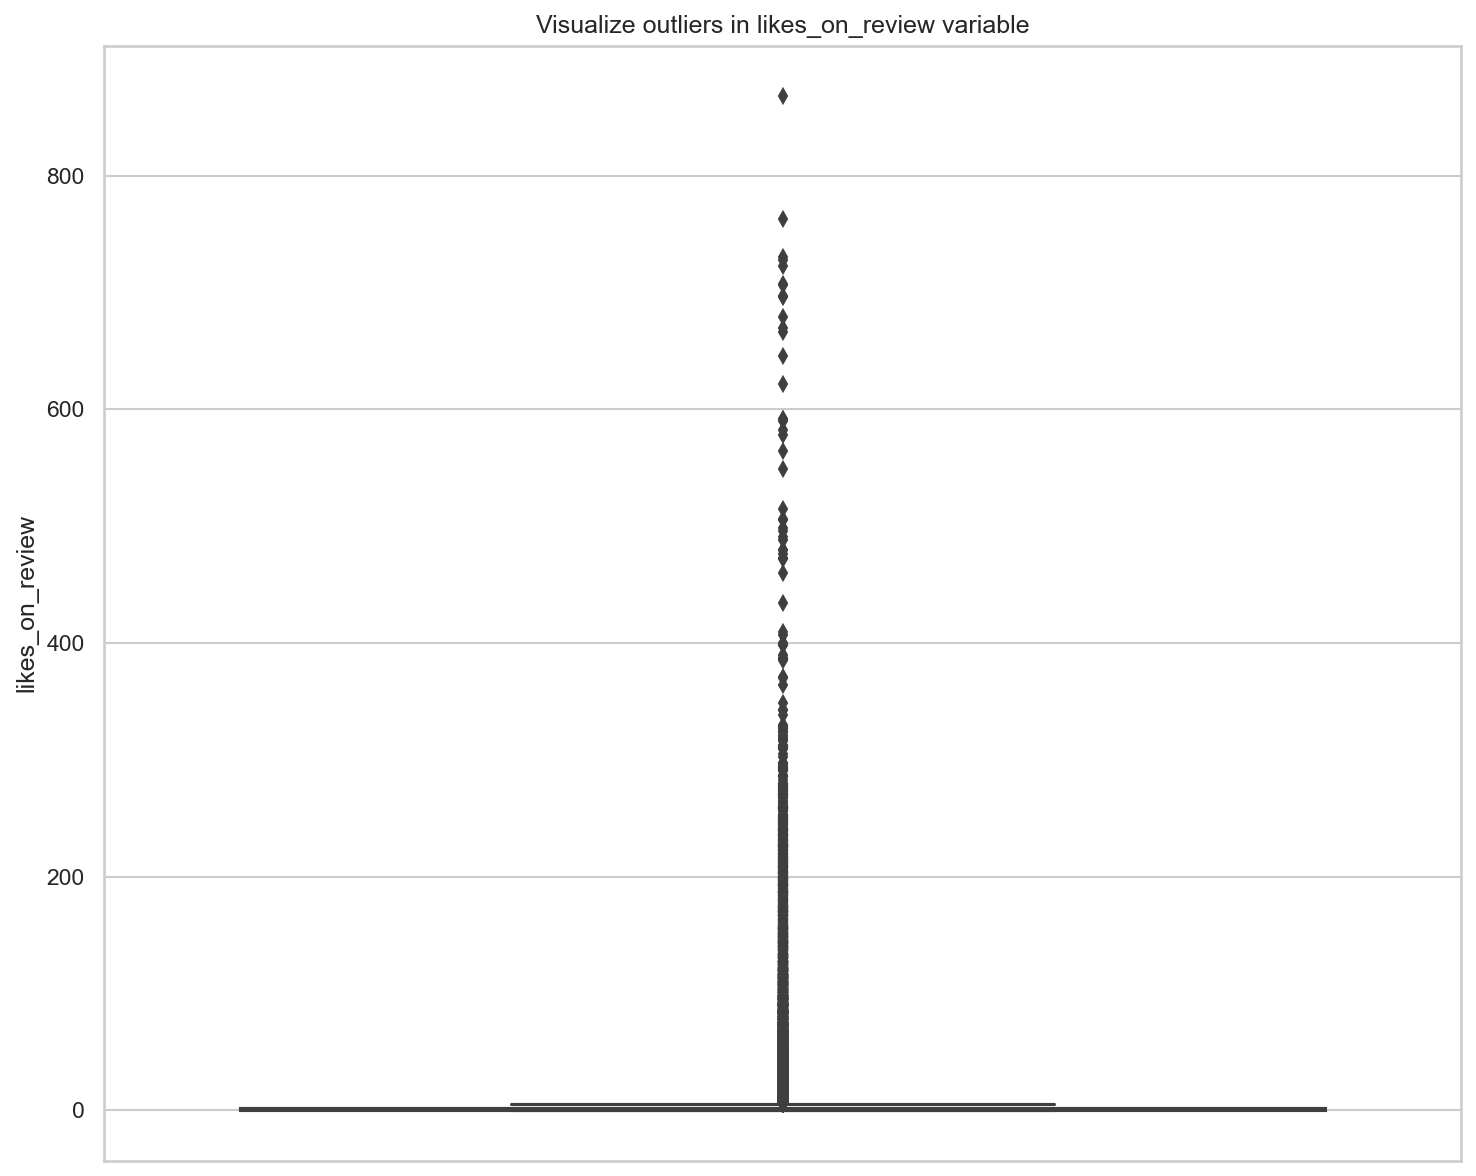

None


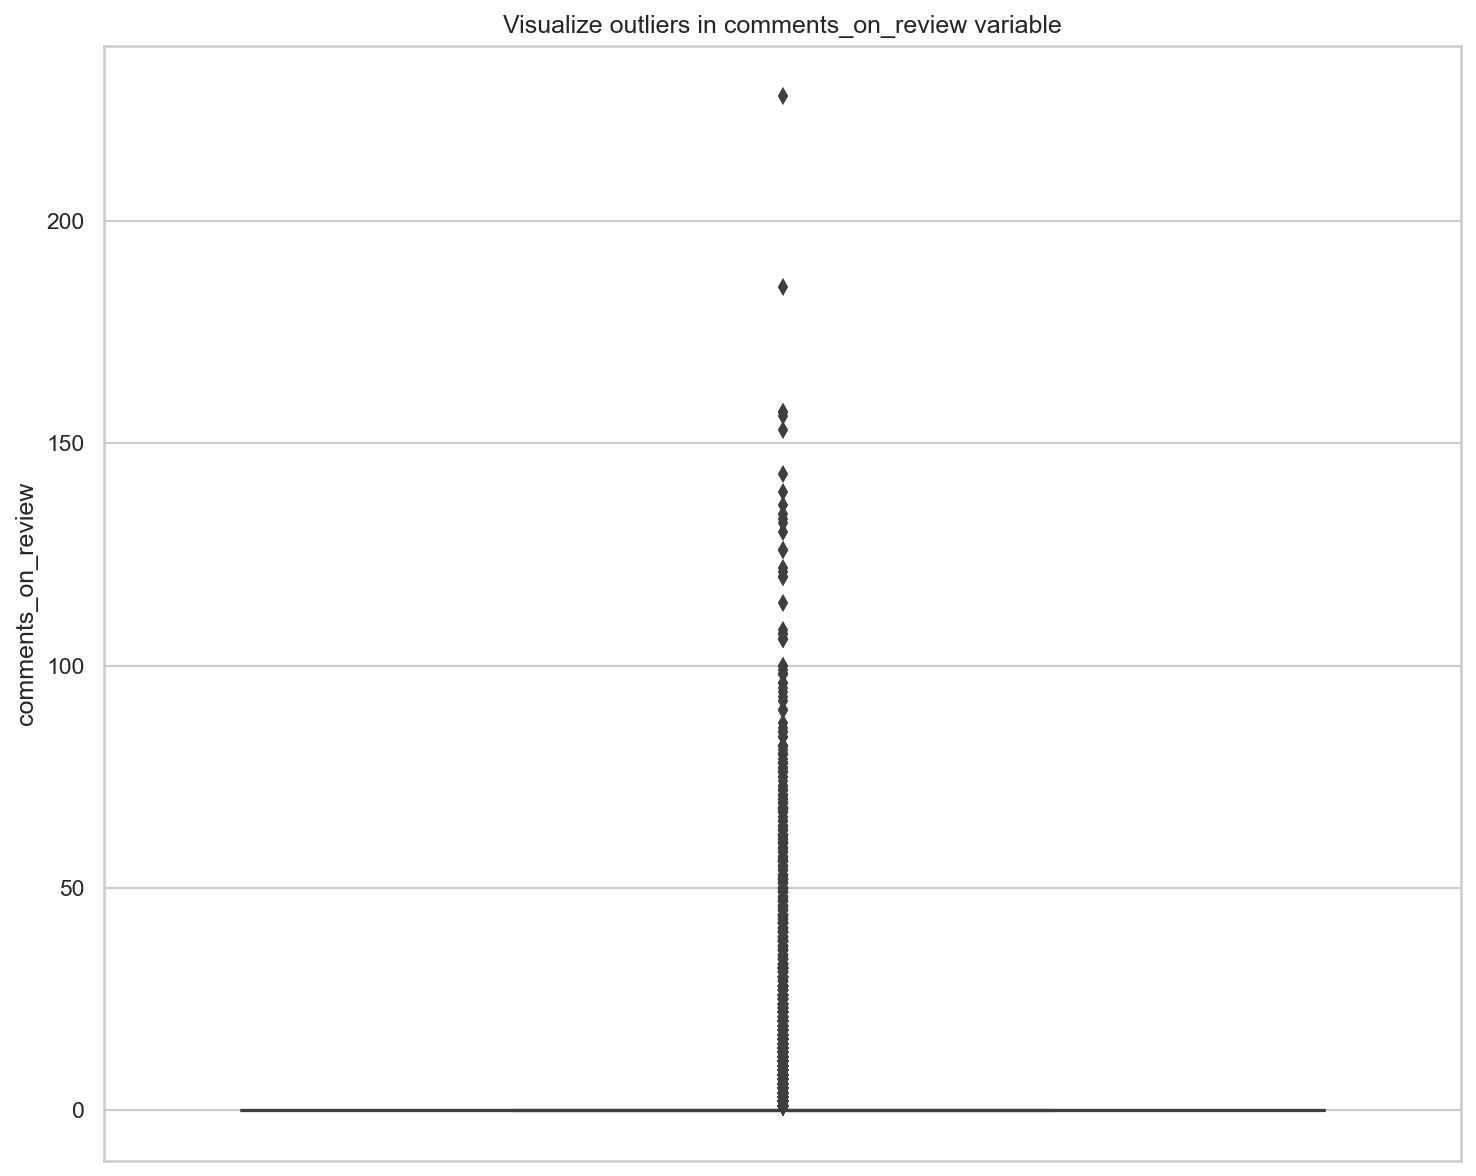

None


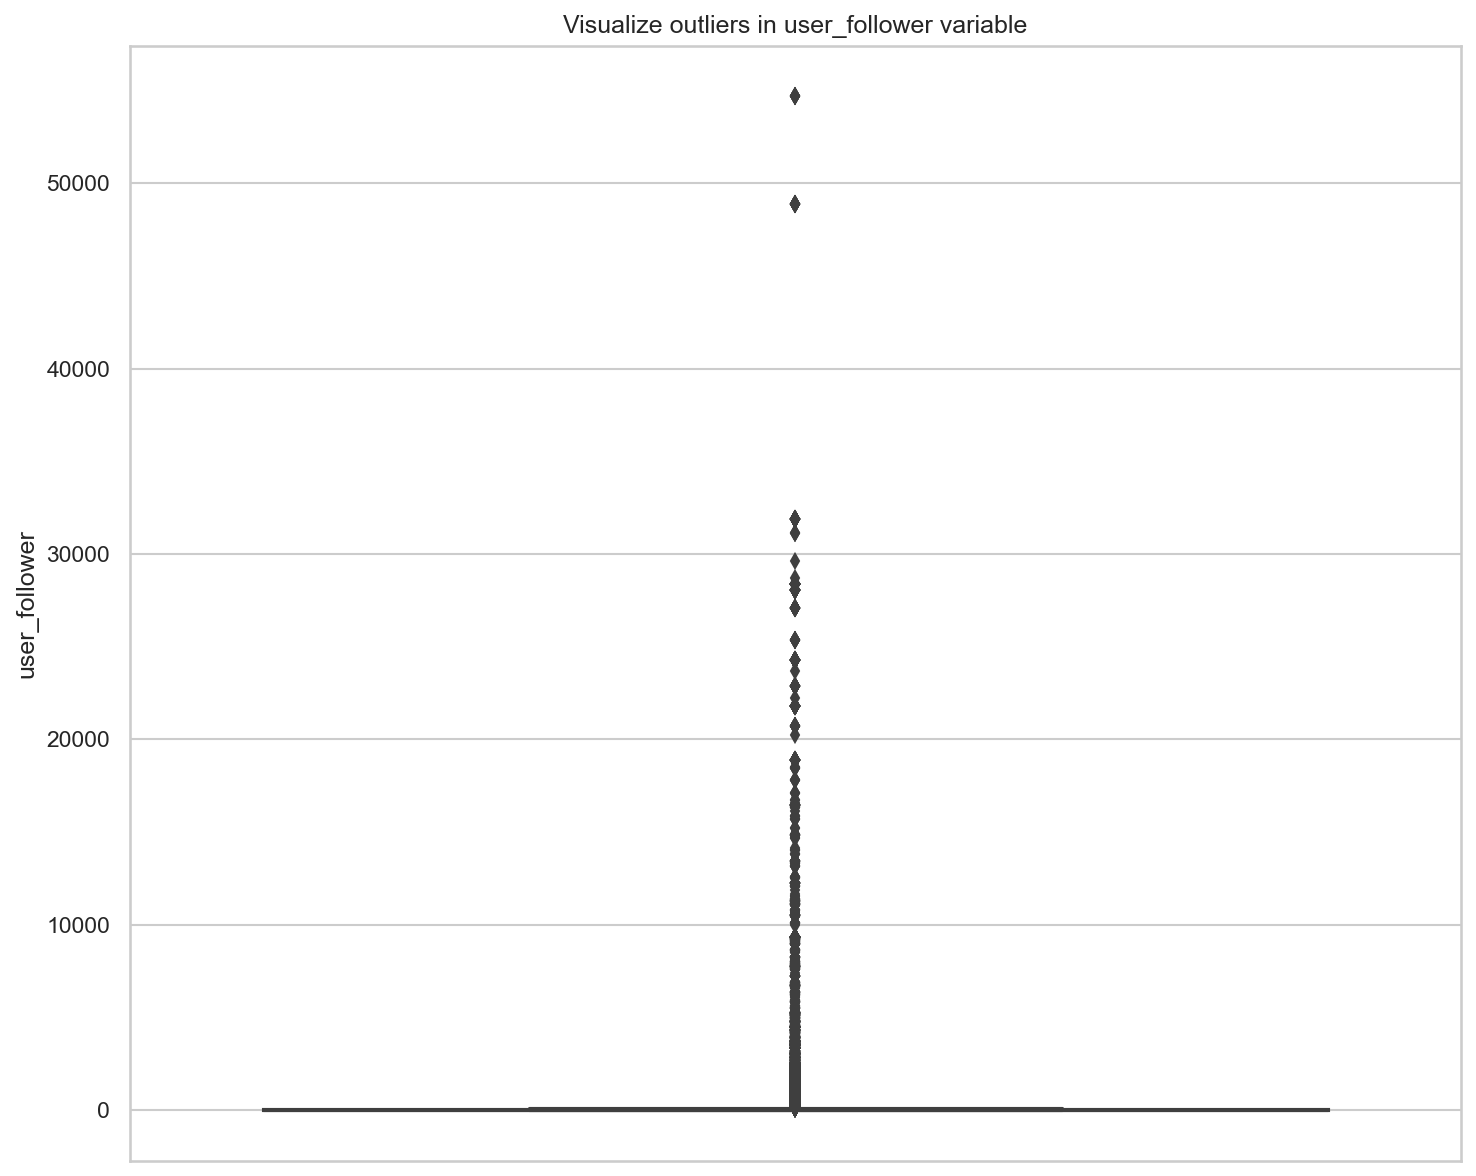

None


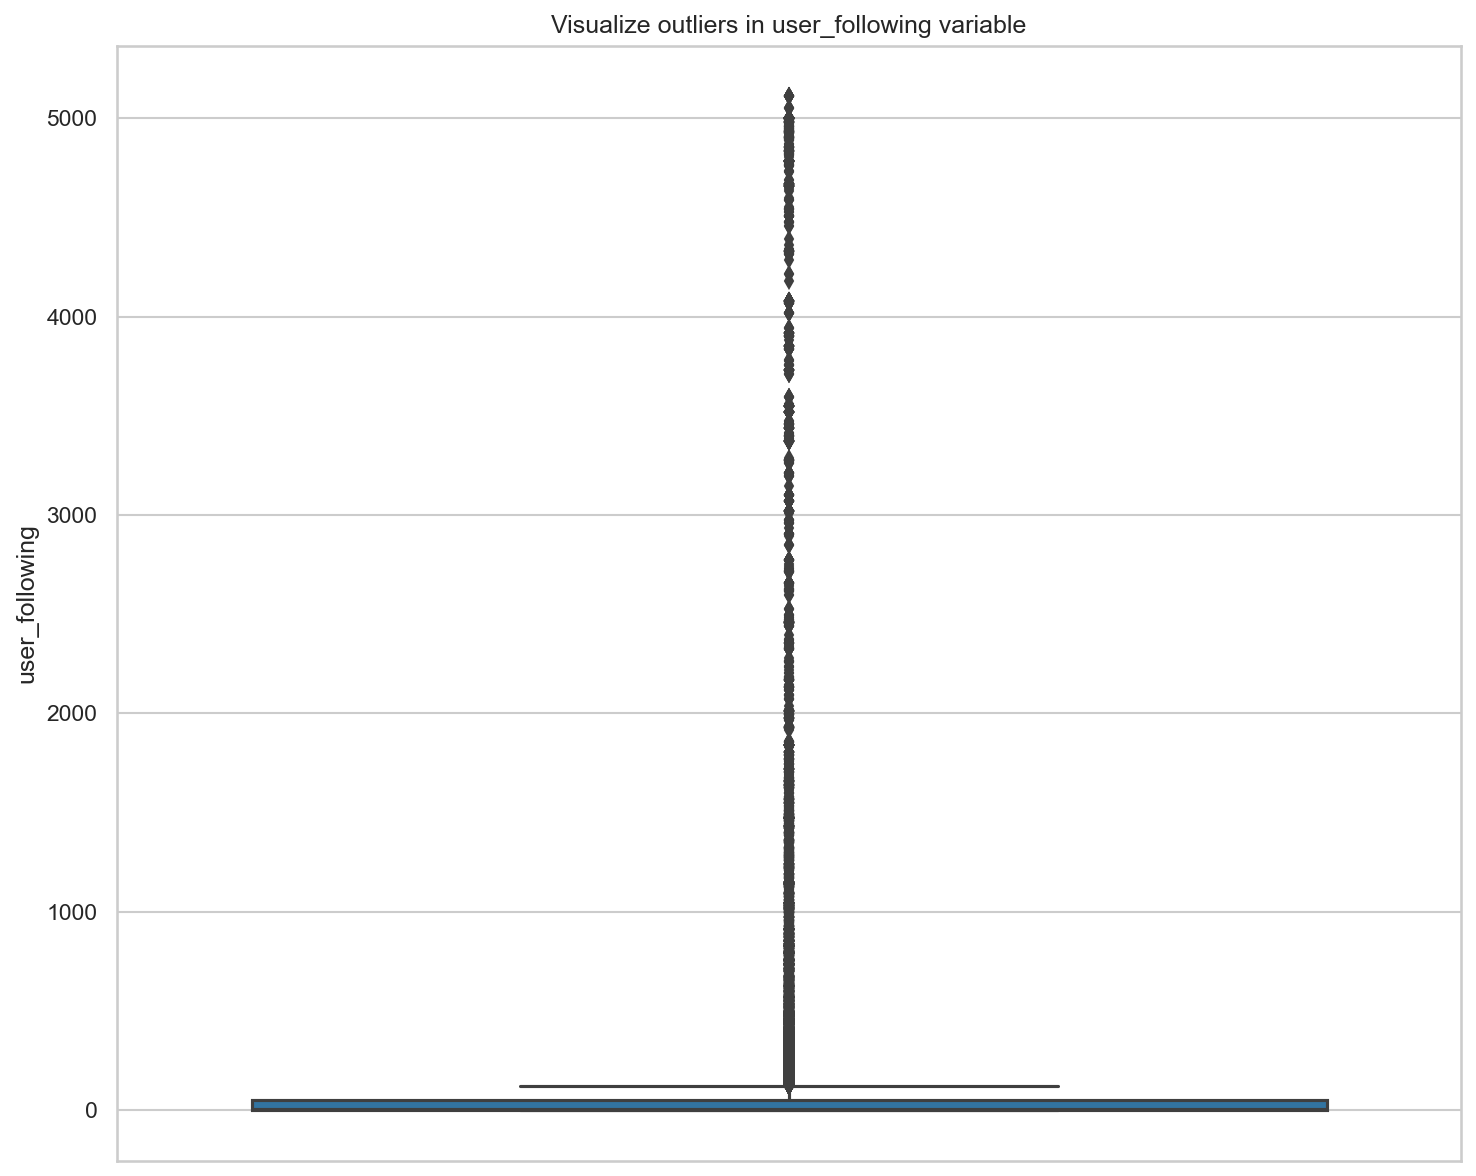

None


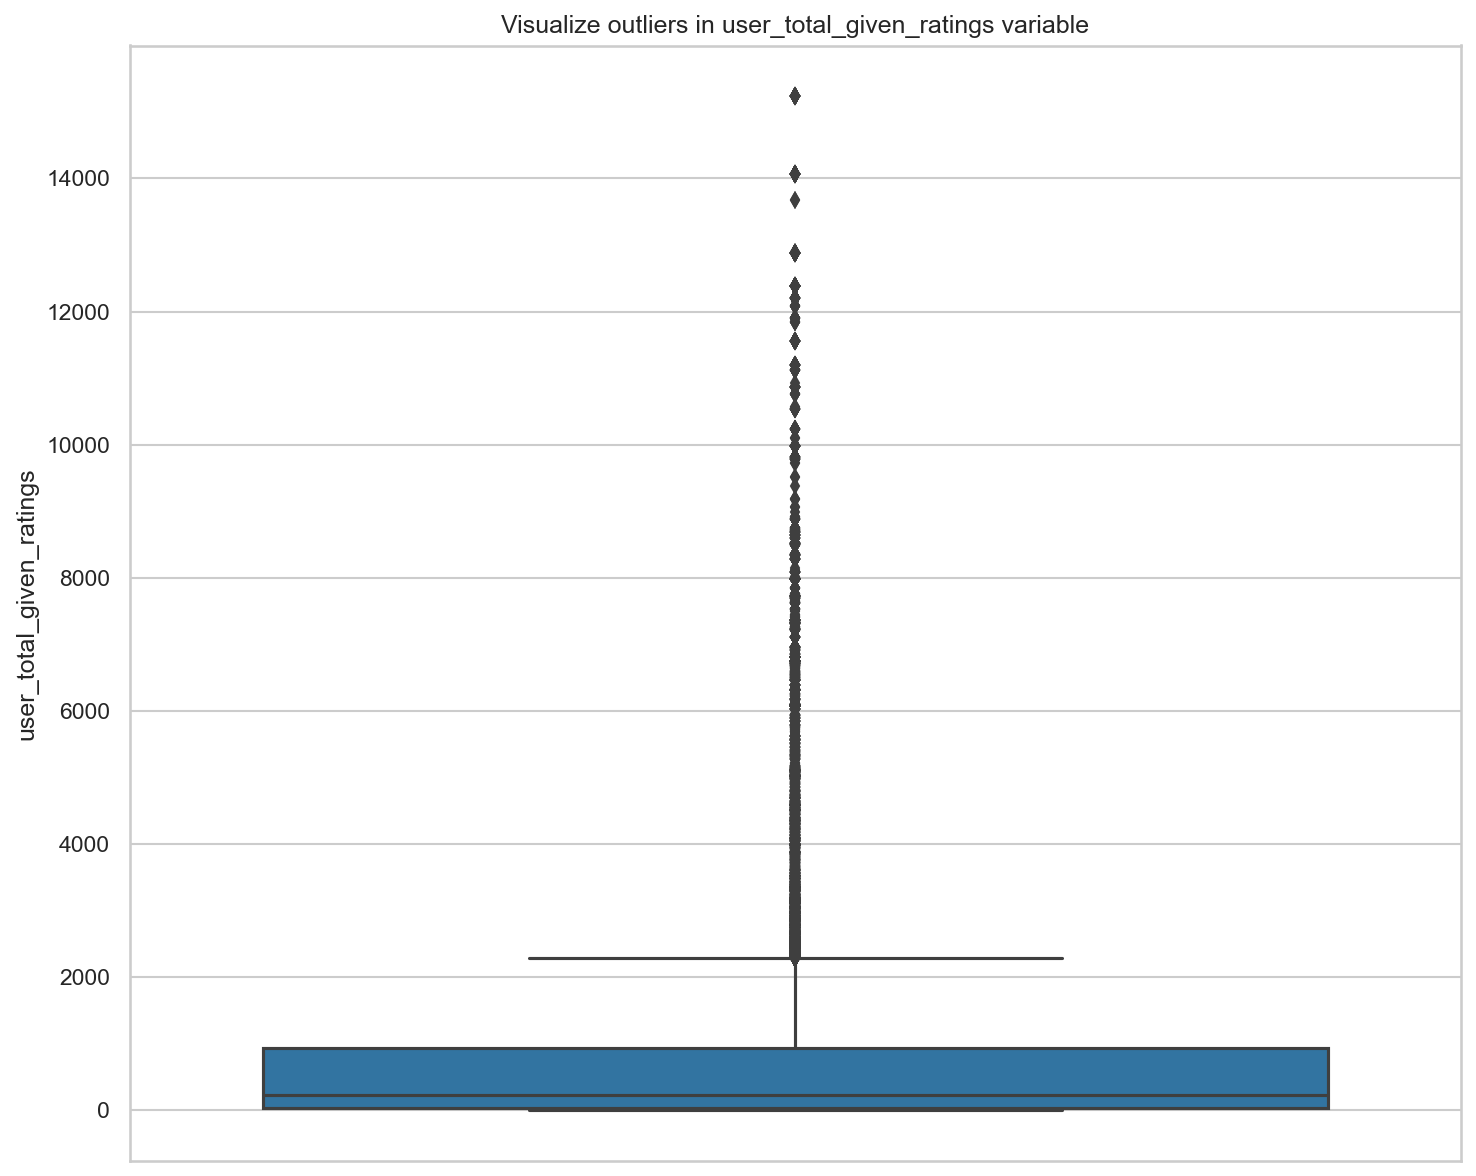

None


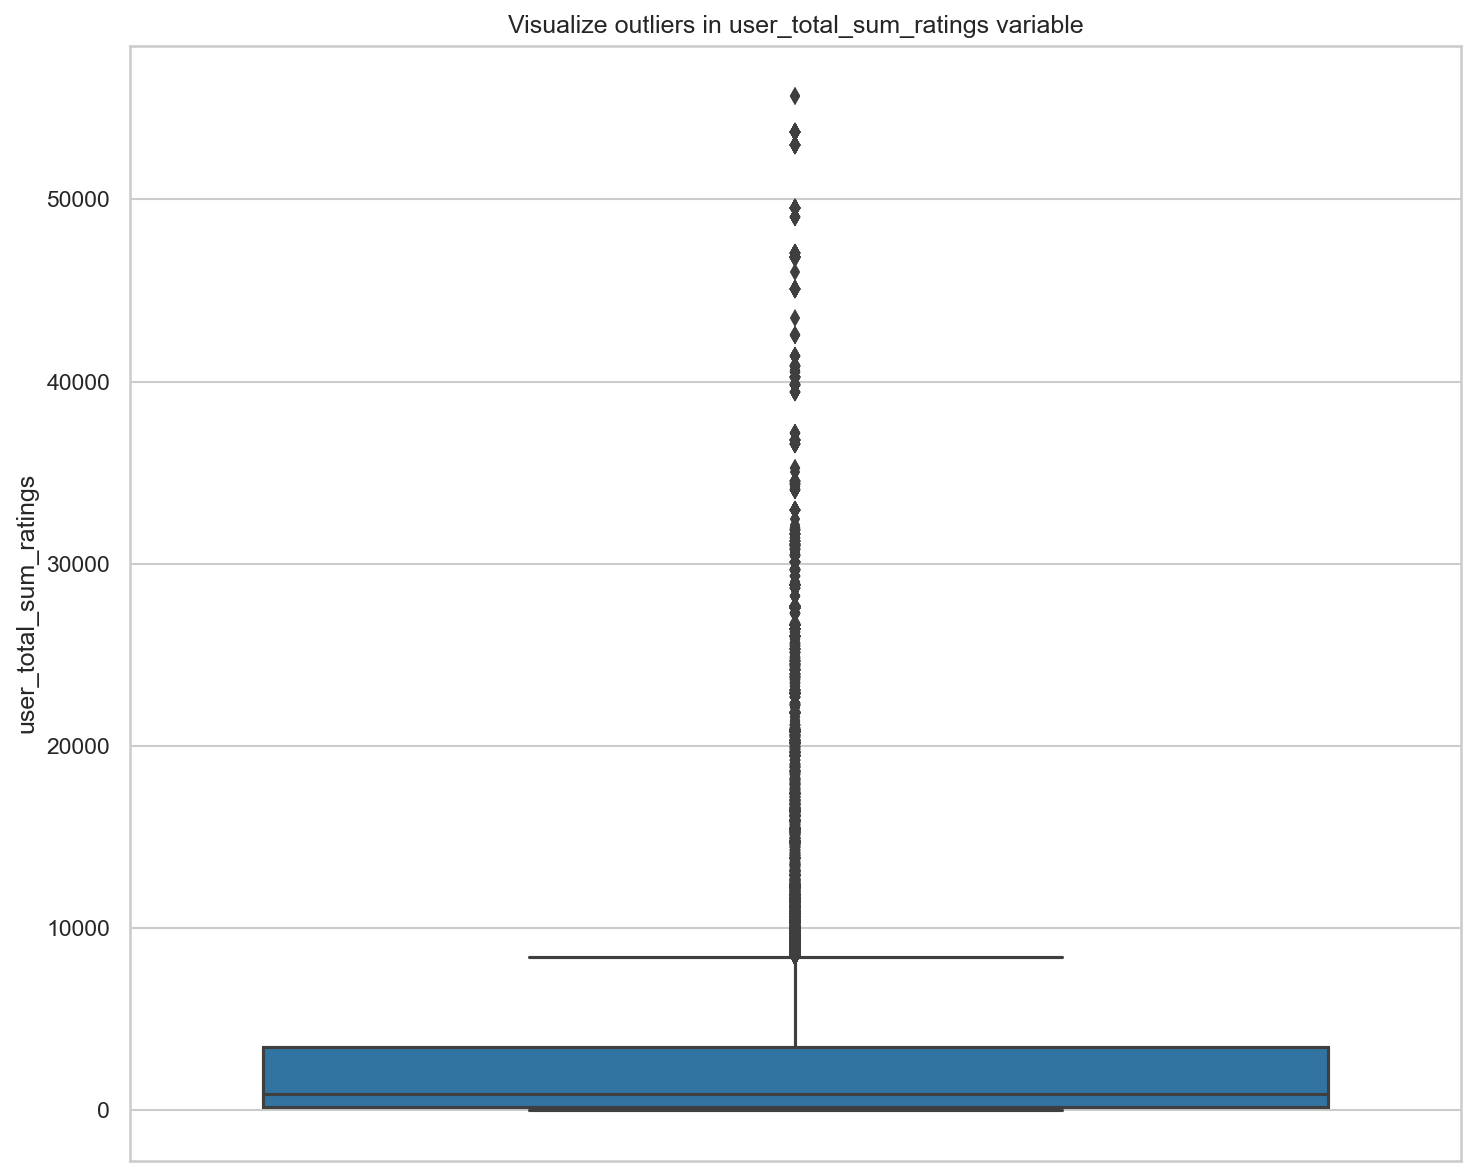

None


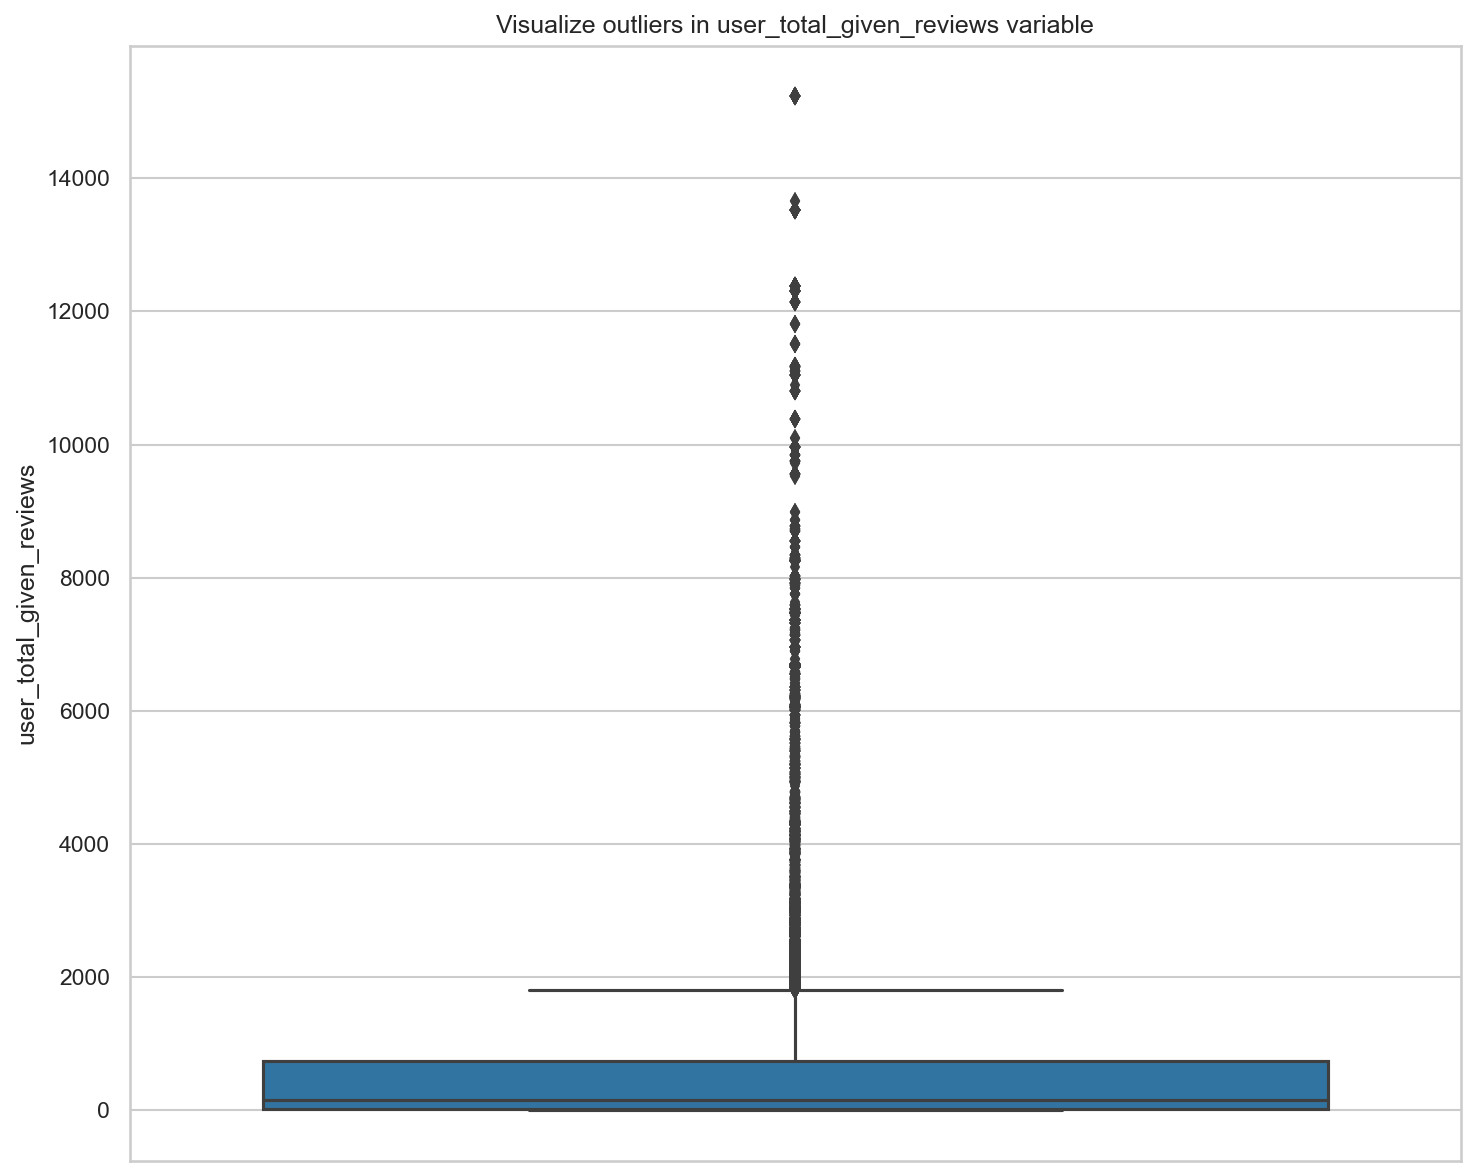

None


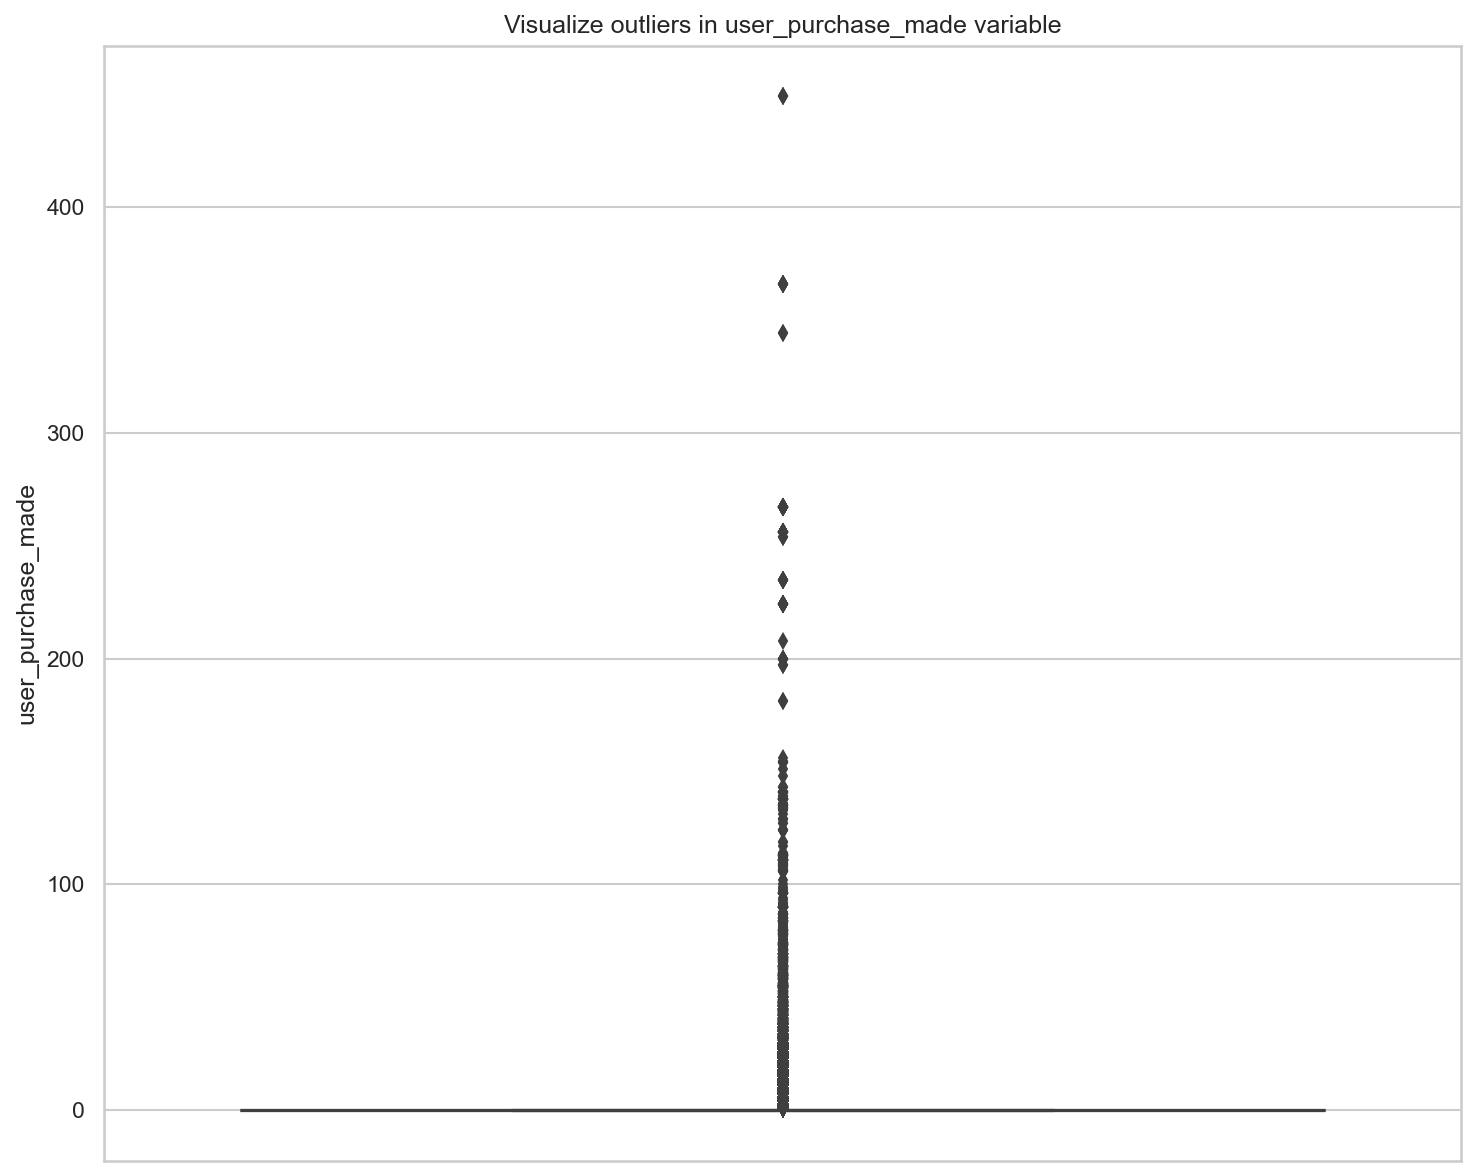

None


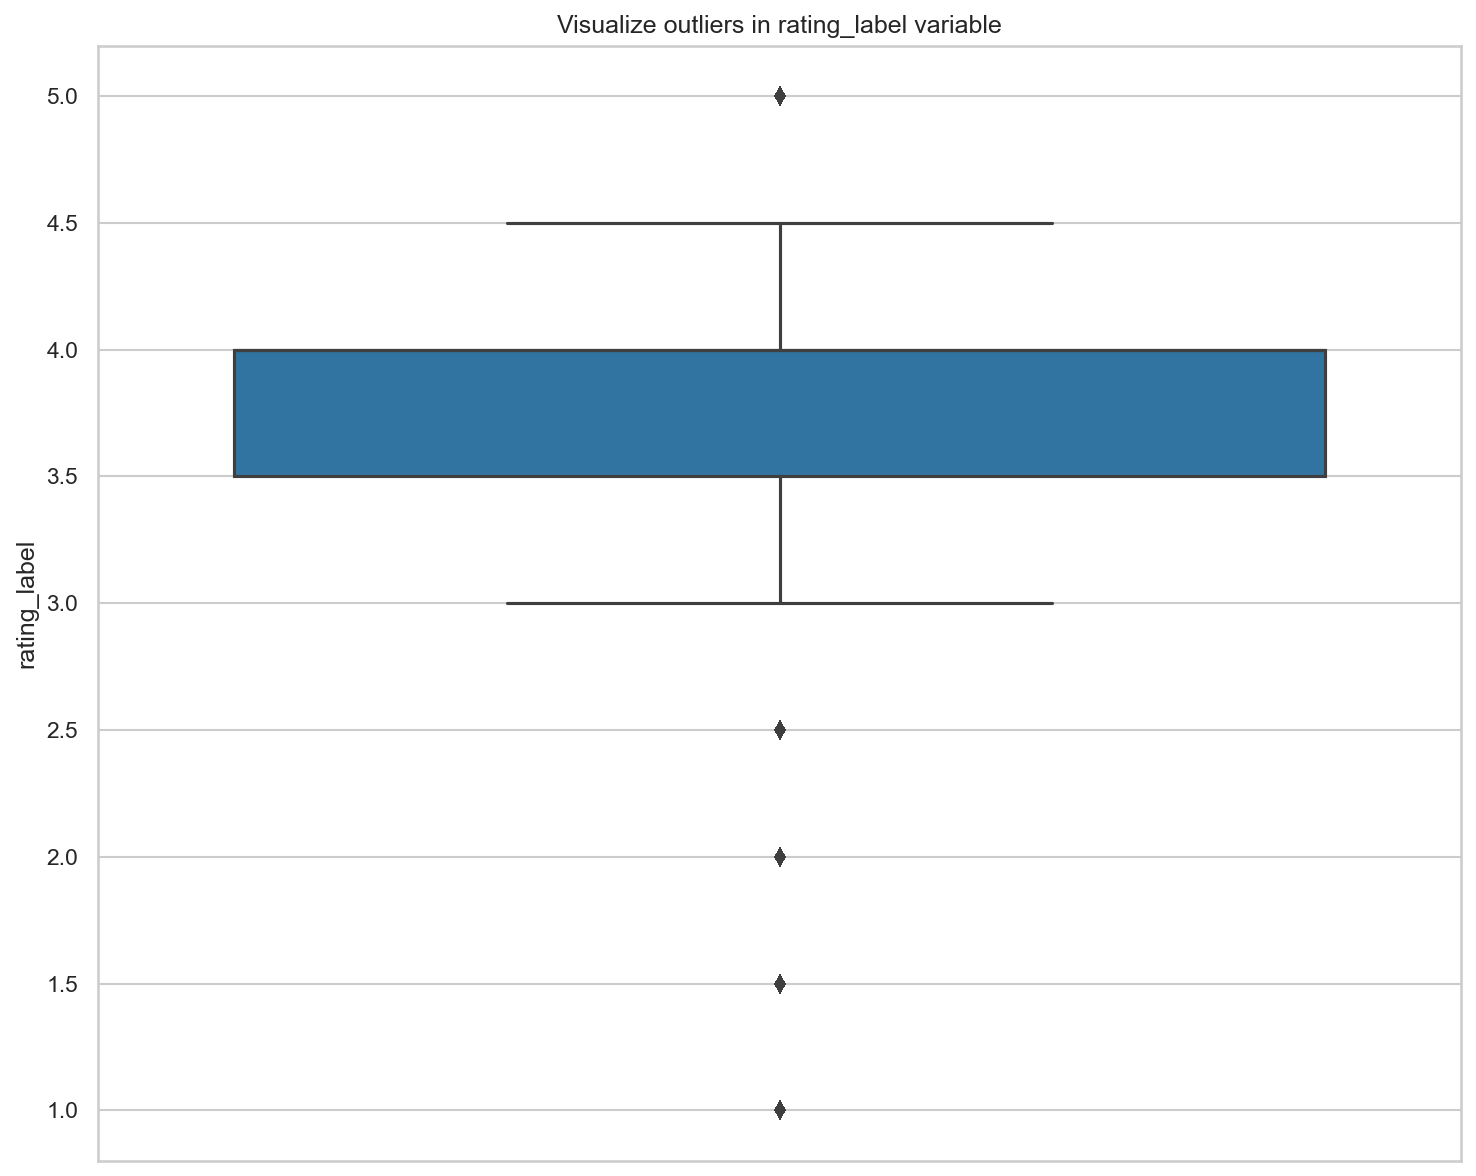

None


In [26]:
for var in numeric_features:
    if var not in ['wine_id', 'user_id', 'review_id']:
        print(box_plot_or_bar_plot(var, wine_df))

In [36]:
wine_df[numeric_features].skew().sort_values(ascending=False)

mild and soft cheese             81.643534
fizziness                        22.467464
user_purchase_made               13.599206
comments_on_review               12.810649
user_follower                    12.532082
likes_on_review                   9.853849
rich fish (salmon & tuna etc)     7.946746
user_following                    6.962935
pork                              5.134078
fruity desserts                   5.049193
aperitif                          4.897197
price                             4.636263
user_total_given_reviews          4.091670
user_total_sum_ratings            3.803976
user_total_given_ratings          3.768399
lean fish                         3.334416
ratings_number                    2.797098
cured meat                        2.591522
vegetarian                        2.357395
veal                              2.048235
all_vintage_ratings_count         1.891240
game (deer & vension)             1.853285
poultry                           1.773743
lamb       

#### target

In [37]:
# absolute distribution
wine_df['rating_label'].value_counts()

rating_label
4.0    34920
3.5    14847
4.5    11317
5.0     8237
3.0     7497
2.5     1483
2.0     1087
1.0      434
1.5      199
Name: count, dtype: int64

In [38]:
# absolute distribution
wine_df['rating_label'].value_counts(normalize=True)

rating_label
4.0    0.436385
3.5    0.185539
4.5    0.141425
5.0    0.102935
3.0    0.093688
2.5    0.018533
2.0    0.013584
1.0    0.005424
1.5    0.002487
Name: proportion, dtype: float64

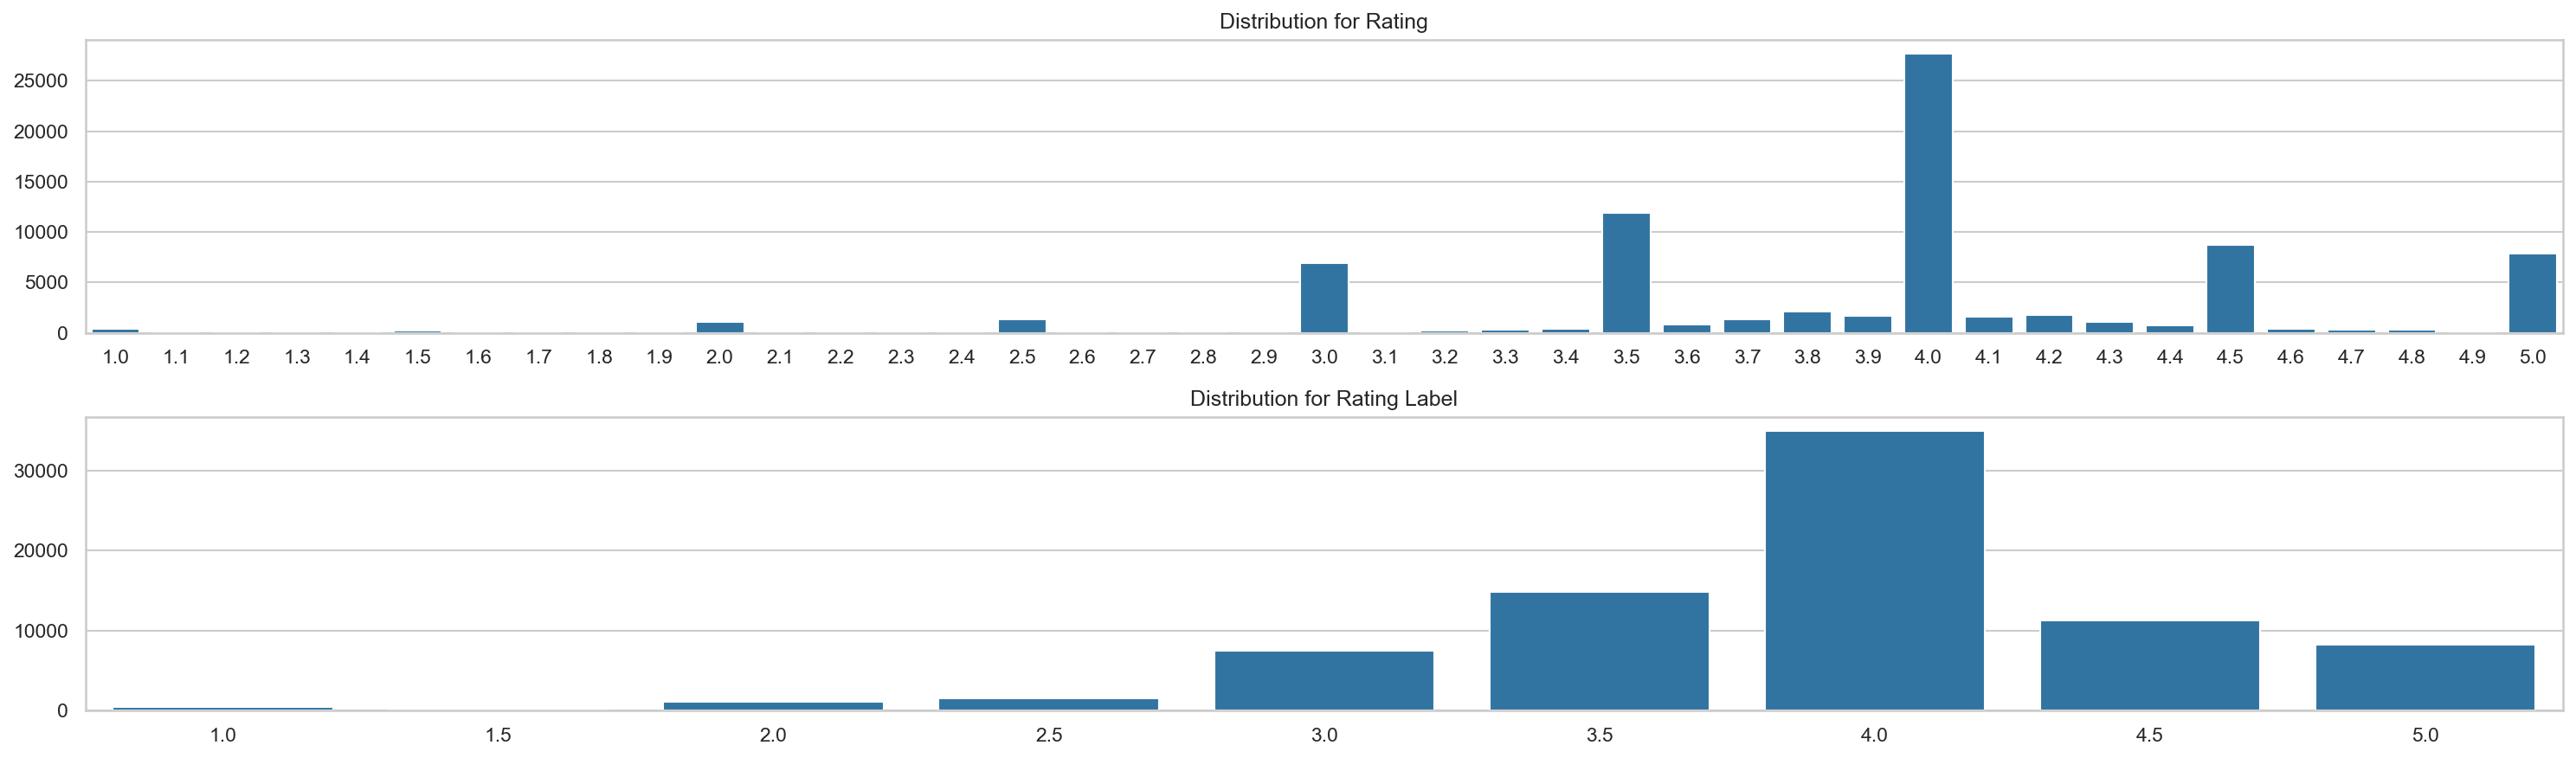

In [39]:
# Create subplots in one area
plt.figure(figsize=(20, 6))

# First subplot
plt.subplot(2, 1, 1)
sns.countplot(x='rating', data=wine_df, color="#1f77b4")
plt.title('Distribution for Rating')
plt.xlabel('')
plt.ylabel('')

# Second subplot
plt.subplot(2, 1, 2)
sns.countplot(x='rating_label', data=wine_df, color="#1f77b4")
plt.title('Distribution for Rating Label')
plt.xlabel('')
plt.ylabel('')

# Show the plot
plt.tight_layout()
plt.show()

### text

In [40]:
from collections import Counter

comments = wine_df['review']

words = re.findall(r'\b\w+\b', ' '.join(comments).lower())
unique_word_count = Counter(words)

print((f'{len(unique_word_count)} unique words in all comments'))

30979 unique words in all comments


##### attributes distribution

In [41]:
attribute_df = pd.read_csv(path.join(data_directory, 'attribute_df.csv'))

In [42]:
attribute_df['attribute_type'].value_counts()

attribute_type
extrinsic    35
intrinsic    26
personal     12
Name: count, dtype: int64

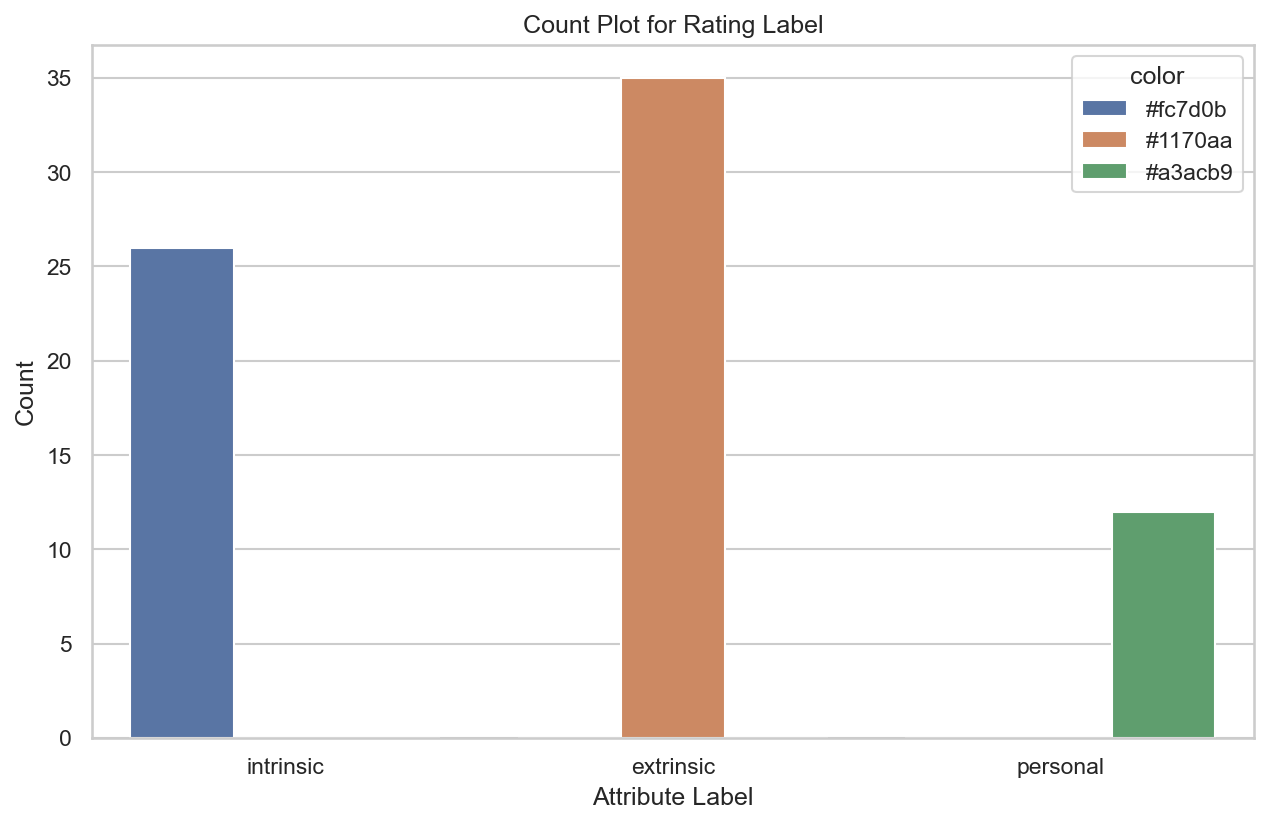

In [43]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.countplot(x='attribute_type', data=attribute_df, hue= 'color')
# Adding titles and labels
plt.title('Count Plot for Rating Label')
plt.xlabel('Attribute Label')
plt.ylabel('Count')

# Show the plot
plt.show()